                                                                                   Marta Granero i Martí
                                                                                        
# Segunda lista - Problema individual 6

## Barcelona motor del IBEX

### La predicción bursátil es un problema complejo, pero a veces se pueden observar relaciones con variables que aparentemente no debrían influenciar. El portal de datos abiertos del ayuntamiento de Barcelona recoge informaciones diarias sobre la ciudad y esto nos ofrece la oportunidad de avieriguar si lo que pasa en Barcelona tiene alguna influencia en el mercado del IBEX. Vamos a trabajar con un extracto de esos datos para el año 2021, con un subconjunto de variables que hemos elegido según nuestro criterio *experto* para desentrañar esa influencia. El objetivo es aproximar el valor de la cotización del IBEX a partir de otras variables.

### Puedes obtener estos datos mediante la función load_BCN_IBEX de la librería apafib. Resuelve los siguientes apartados ilustrando los resultados de la manera que te parezca más adecuada.

In [1]:
#!pip install apafib --upgrade --user --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from statsmodels.genmod.generalized_linear_model import GLM

from yellowbrick.regressor import AlphaSelection
from yellowbrick.target.feature_correlation import feature_correlation

from scipy import stats
from scipy.stats import normaltest

### Exploración previa de los datos 

En este segundo problema de la lista lo que pretendemos es intentar analizar como influye el comportamiento de la sociedad en la ciudad de Barcelona para establecer y ver como este afecta al valor de la cotización del IBEX a partir de los datos agrupados por las variables que tenemos.

#### Cargamos el conjunto de datos desde la librería $\texttt{apafib}$

##### Minipreproceso del conjunto de datos

Antes de empezar a trabajar con el conjunto de datos, he decidido tratar un poco el nombre de las columnas del dataset, ya que estas contenian acentos varios, espacios, comas y algunos caracteres que no se pueden usar al trabajar con ciertas funciones de algunas librerías, como por ejemplo con el statsmodel de la librería GLM. 

In [3]:
from apafib import load_BCN_IBEX
bcn_ibex_data = load_BCN_IBEX()

bcn_ibex_data.head()


# quitamos espacios y símbolos para evitar problemas con el statsmodel GLM
bcn_ibex_data.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_').replace("'",'_').replace(':','_').replace('(','_').replace(')','_').replace('__','_')
                                for c in bcn_ibex_data.columns]

# quitamos acentos también para evitar problemas con el statsmodel GLM
bcn_ibex_data.columns = [c.replace('ó','o').replace('ò','o').replace('à','a').replace('í','i').replace('è','e')
                                for c in bcn_ibex_data.columns]

bcn_ibex_data['estat_del_transit_segons_trams_horaris__nit_0_5_']

0      1.1320
1      1.3092
2      1.1893
3      1.2005
4      1.2213
        ...  
360    1.2031
361    1.1709
362    1.1683
363    1.1497
364    1.1700
Name: estat_del_transit_segons_trams_horaris__nit_0_5_, Length: 365, dtype: float64

##### Breve información de las features del dataset

In [4]:
bcn_ibex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges                  365 non-null    float64
 1   dades_meteorologiques_precipitacio__barcelona__zona_universitaria                          365 non-null    float64
 2   dades_meteorologiques_temperatura__barcelona__zona_universitaria                           365 non-null    float64
 3   dades_meteorologiques_vent__barcelona__zona_universitaria                                  365 non-null    float64
 4   estat_del_transit_segons_trams_horaris__mati_6_13_                                         365 non-null    float64
 5   estat_del_transit_segons_trams_horaris__nit_0_5_  

##### Breve estadística descriptiva sobre el conjunto de datos

Como tratamos con un dataset que no tiene una extensión muy grande, podemos intentar ver la estadístca descriptiva de todas las variables

In [5]:
bcn_ibex_data.describe().T

count         mean  \
compra_venda_d_habitatges_a_barcelona_nombre_de...  365.0   258.920548   
dades_meteorologiques_precipitacio__barcelona__...  365.0     0.928493   
dades_meteorologiques_temperatura__barcelona__z...  365.0    17.186411   
dades_meteorologiques_vent__barcelona__zona_uni...  365.0     4.623973   
estat_del_transit_segons_trams_horaris__mati_6_13_  365.0     1.864942   
estat_del_transit_segons_trams_horaris__nit_0_5_    365.0     1.230517   
estat_del_transit_segons_trams_horaris__tarda_1...  365.0     1.943377   
estat_del_transit_segons_trams_horaris__vespre_...  365.0     1.557425   
ipc_interanual__barcelona                           365.0     2.735068   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  365.0     6.276712   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  365.0   172.273973   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  365.0   223.775342   
preu_electricitat_majorista__                       365.0   111.925550   
matriculacions_de_vehicles_a_barcelona__turismes    365.0    59.202740   
mercat_bursatil_ibex_35_                            365.0  8679.076438   

                                                           std          min  \
compra_venda_d_habitatges_a_barcelona_nombre_de...   99.042957    27.000000   
dades_meteorologiques_precipitacio__barcelona__...    4.056891     0.000000   
dades_meteorologiques_temperatura__barcelona__z...    6.033962     4.640000   
dades_meteorologiques_vent__barcelona__zona_uni...    1.754966     1.630000   
estat_del_transit_segons_trams_horaris__mati_6_13_    0.225878     1.317400   
estat_del_transit_segons_trams_horaris__nit_0_5_      0.061187     1.132000   
estat_del_transit_segons_trams_horaris__tarda_1...    0.252567     1.272600   
estat_del_transit_segons_trams_horaris__vespre_...    0.160126     1.230400   
ipc_interanual__barcelona                             1.739372    -0.100000   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...    4.245570     1.000000   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...   75.919575    31.000000   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  135.201920    28.000000   
preu_electricitat_majorista__                        72.460326     1.419583   
matriculacions_de_vehicles_a_barcelona__turismes     38.920707     0.000000   
mercat_bursatil_ibex_35_                            347.512527  7750.200000   

                                                            25%          50%  \
compra_venda_d_habitatges_a_barcelona_nombre_de...   210.000000   266.000000   
dades_meteorologiques_precipitacio__barcelona__...     0.000000     0.000000   
dades_meteorologiques_temperatura__barcelona__z...    12.360000    16.360000   
dades_meteorologiques_vent__barcelona__zona_uni...     3.450000     4.330000   
estat_del_transit_segons_trams_horaris__mati_6_13_     1.656700     1.955500   
estat_del_transit_segons_trams_horaris__nit_0_5_       1.190900     1.218100   
estat_del_transit_segons_trams_horaris__tarda_1...     1.736100     1.999600   
estat_del_transit_segons_trams_horaris__vespre_...     1.475400     1.536000   
ipc_interanual__barcelona                              1.800000     2.500000   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...     2.000000     6.000000   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...    94.000000   192.000000   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...    78.000000   243.000000   
preu_electricitat_majorista__                         61.391667    88.952083   
matriculacions_de_vehicles_a_barcelona__turismes      35.000000    51.000000   
mercat_bursatil_ibex_35_                            8397.700000  8753.300000   

                                                            75%        max  
compra_venda_d_habitatges_a_barcelona_nombre_de...   310.000000   491.0000  
dades_meteorologiques_precipitacio__barcelona__...     0.000000    50.8000  
dades_meteorologiques_temperatura__barcelona__z...    23.460000    28.6600  
dades_meteoro

Podemos hacer una breve exploración de los datos y nos podemos fijar que tenemos **14 variables predictivas** y **365 muestras**. 

Además nuestra variable objetivo es `mercat_bursatil_ibex_35_`

A continuación visualizaremos este conjunto de datos, todos numéricos usando histogramas para mostrar la distribución de estas variables numéricas. Esta visualización nos va a permitir extraer información sobre la possible gaussianidad de ciertas variables, sobre el desbalance de ciertas clases y sobre la correcta codificación de estas. Hacer una visualización de los datos es esencial, pues nos dará una visión preliminar de las características de las que disponen nuestros datos. Lo vemos a continuación:

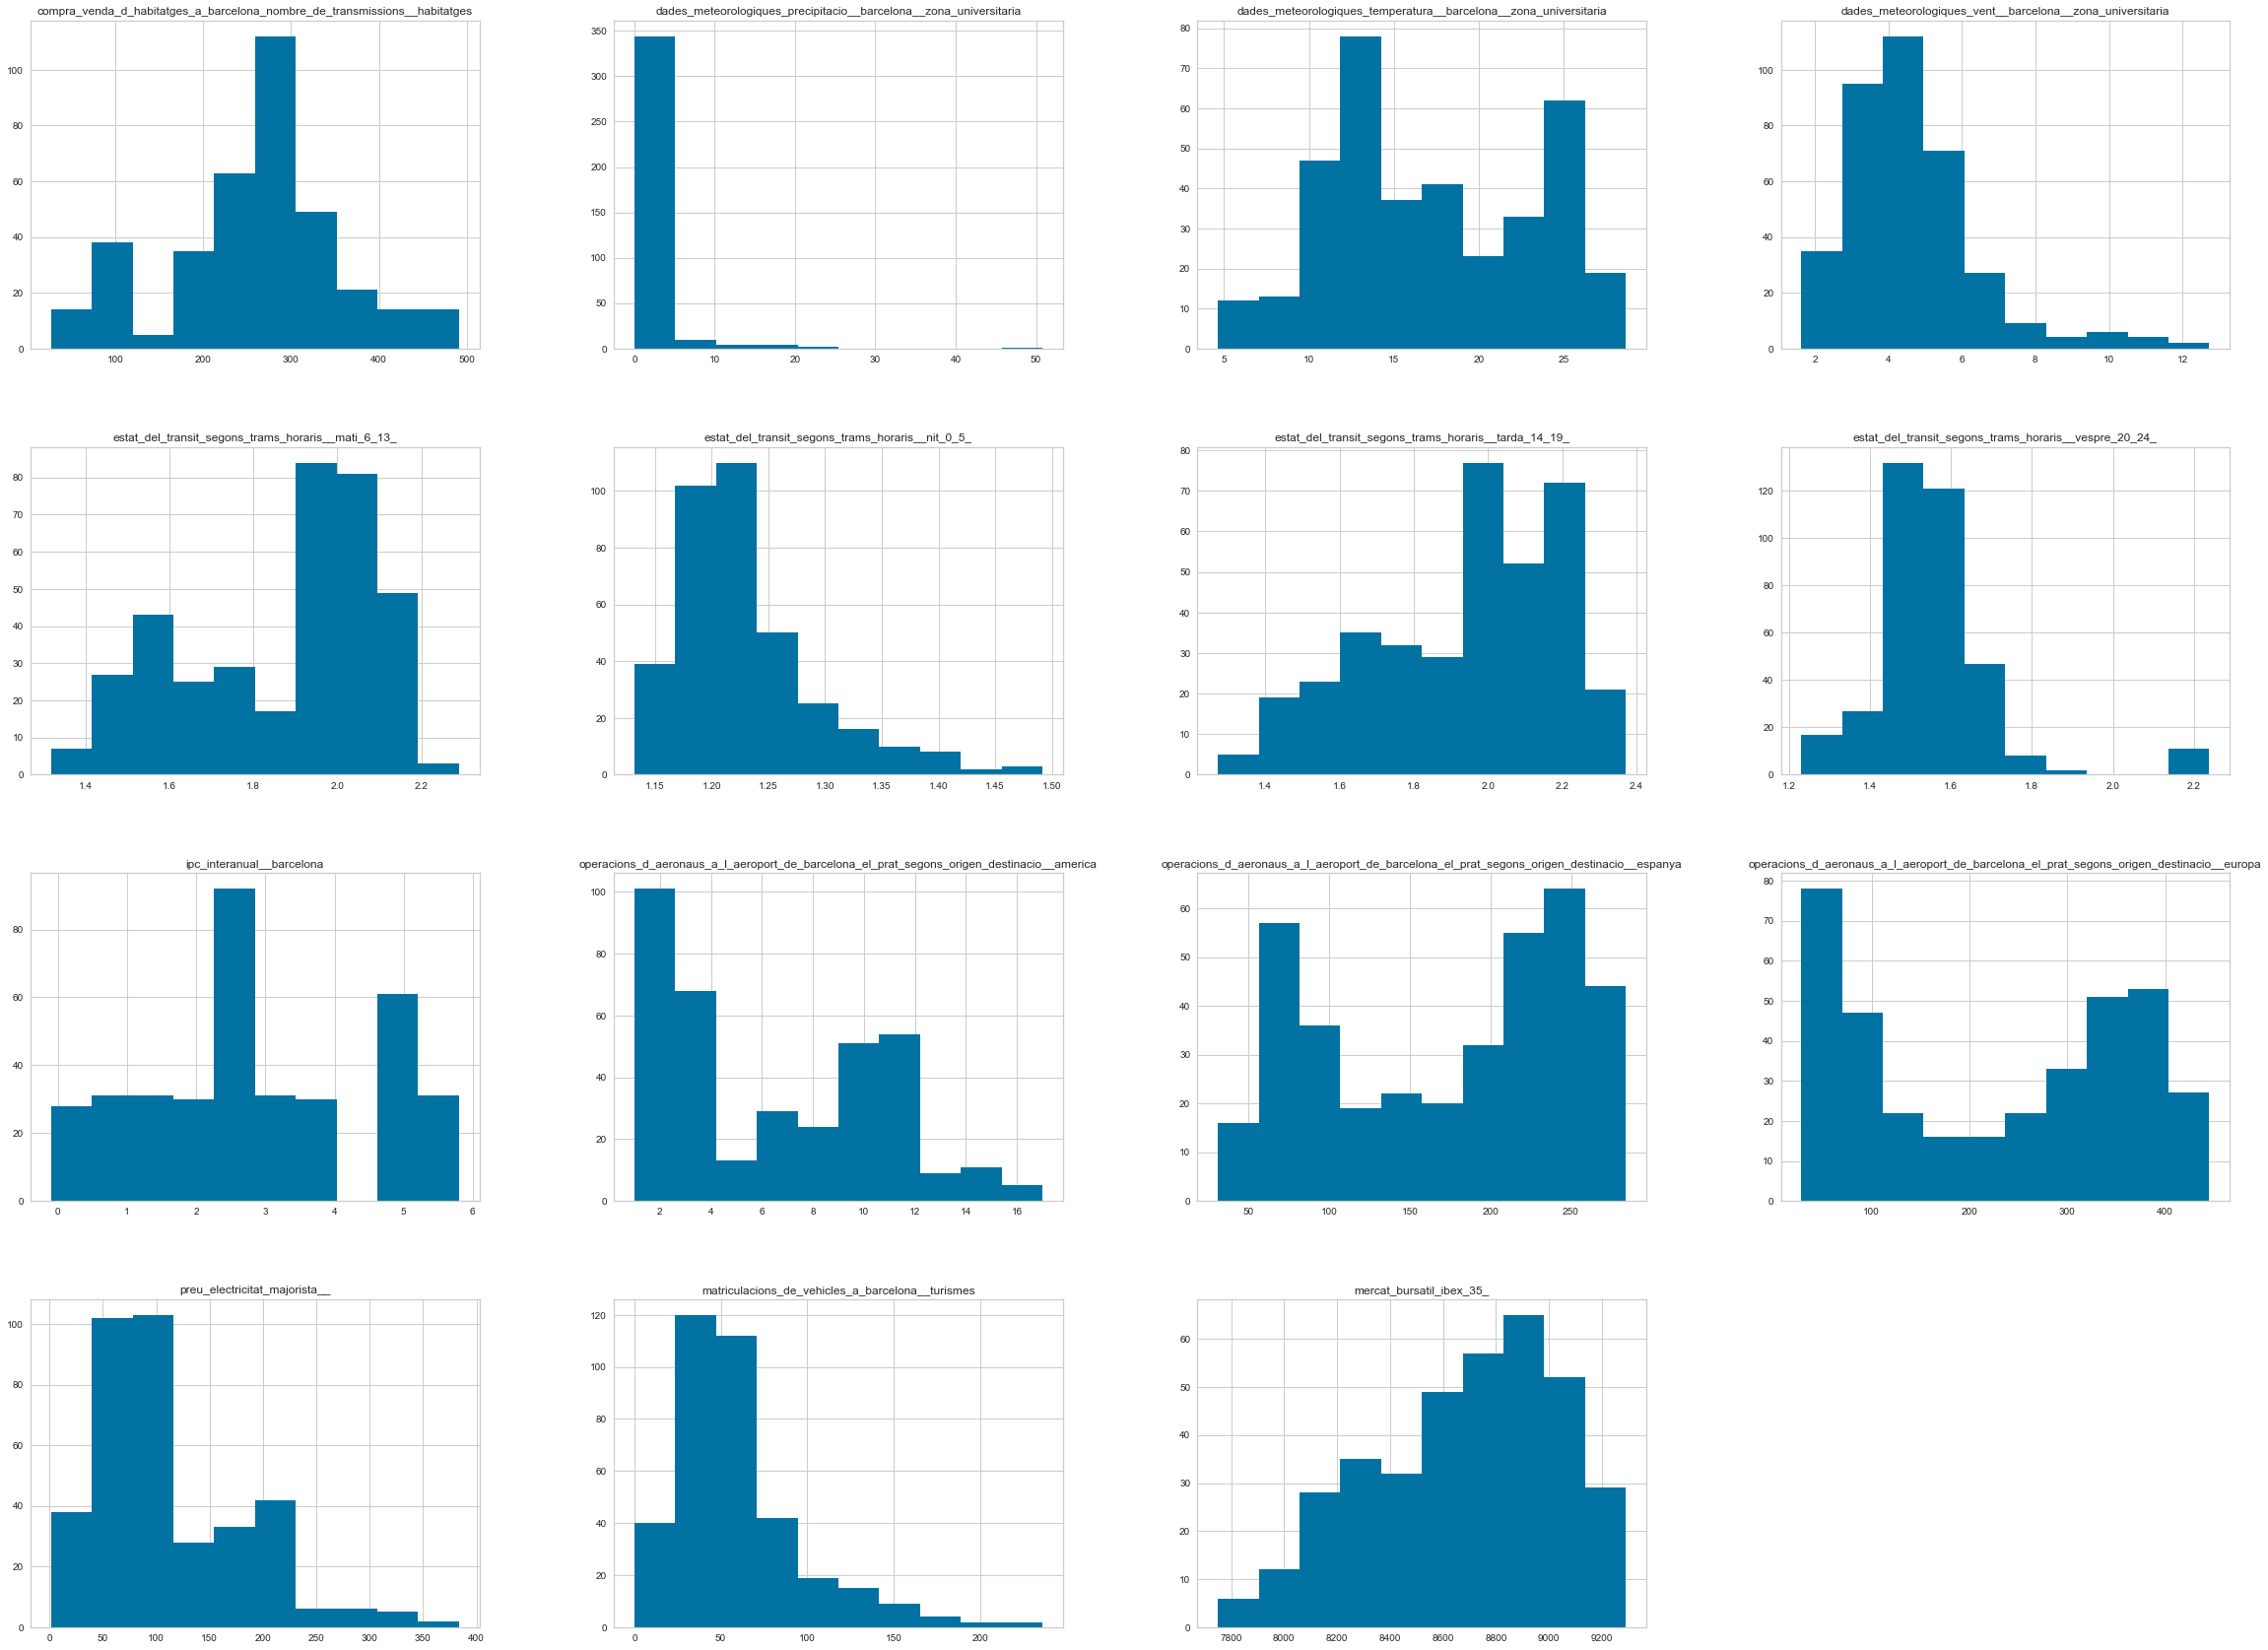

In [6]:
bcn_ibex_data.hist(figsize=(40,30));

Como podemos observar con los histogramas anteriores es que tenemos una variable predictiva, `dades_meteorologiques_precipitacio__barcelona__zona_universitaria` que parece estar ciertamente desbalanceada. Plotearemos más tarde su boxplot para saber que le ocurre en concreto.

##### Comprobaremos si algunas de nuestras variables numéricas siguen una distribución Normal.

Podemos ver el valor del estadístico y del p-valor para las distintas variables y como vemos, estas no siguen una distribuación normal.

In [7]:
bcn_ibex_data.columns

print(normaltest(bcn_ibex_data['ipc_interanual__barcelona'], nan_policy='omit'))
print(normaltest(bcn_ibex_data['dades_meteorologiques_vent__barcelona__zona_universitaria'], nan_policy='omit'))
print(normaltest(bcn_ibex_data['dades_meteorologiques_precipitacio__barcelona__zona_universitaria'], nan_policy='omit'))
print(normaltest(bcn_ibex_data['estat_del_transit_segons_trams_horaris__nit_0_5_'], nan_policy='omit'))
print(normaltest(bcn_ibex_data['estat_del_transit_segons_trams_horaris__mati_6_13_'], nan_policy='omit'))
print(normaltest(bcn_ibex_data['matriculacions_de_vehicles_a_barcelona__turismes'], nan_policy='omit'))

NormaltestResult(statistic=45.7137920277478, pvalue=1.1840667553338163e-10)
NormaltestResult(statistic=117.98708247776773, pvalue=2.395689734994954e-26)
NormaltestResult(statistic=526.8590852419866, pvalue=3.9264789127459224e-115)
NormaltestResult(statistic=99.24043199550214, pvalue=2.8197720493470506e-22)
NormaltestResult(statistic=75.92676357713295, pvalue=3.2562127676406775e-17)
NormaltestResult(statistic=114.59633577407266, pvalue=1.305334641036055e-25)


Asimismo podemos ver la posible normalidad de las variables usando los boxplots.

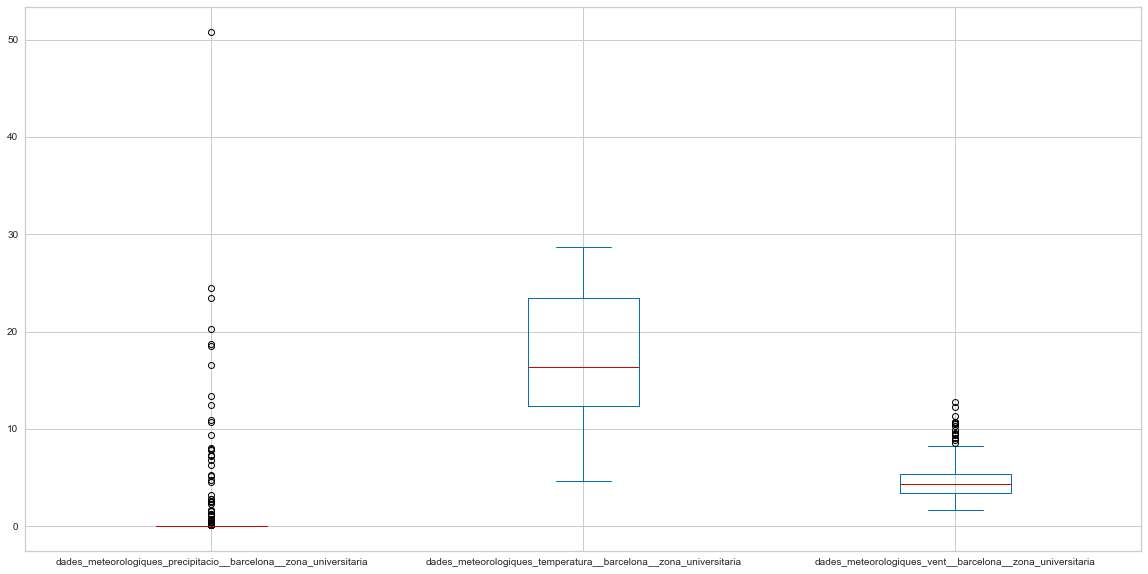

In [8]:
#Obtenemos los boxplots para las variables predictivas
bcn_ibex_data.loc[:,['dades_meteorologiques_precipitacio__barcelona__zona_universitaria', 'dades_meteorologiques_temperatura__barcelona__zona_universitaria',
                     'dades_meteorologiques_vent__barcelona__zona_universitaria']].plot.box(figsize=(20,10));

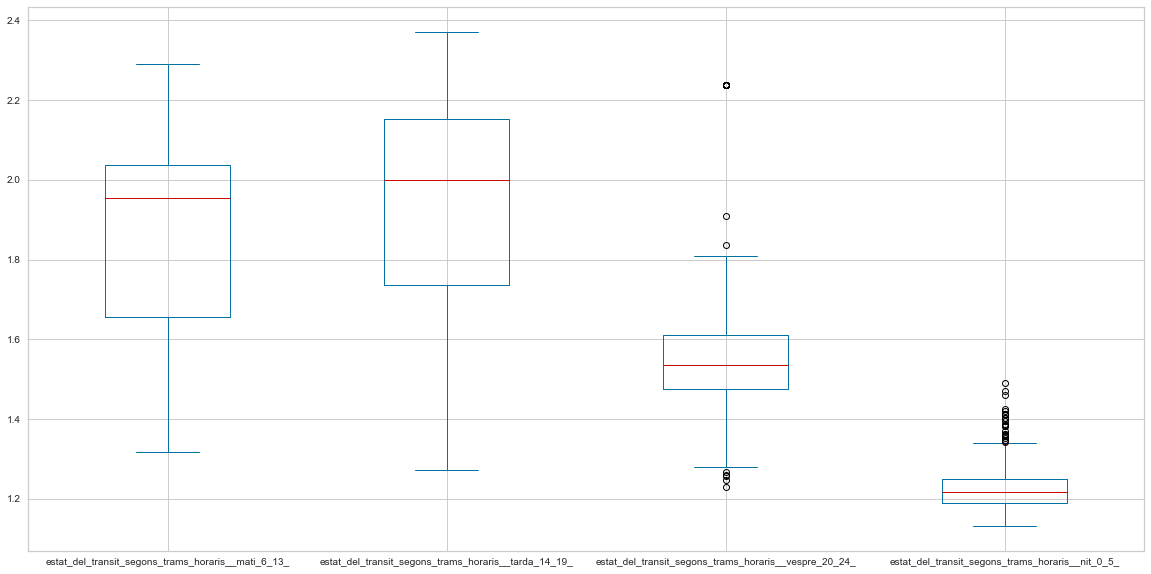

In [9]:
#Obtenemos los boxplots para las variables predictivas
bcn_ibex_data.loc[:,['estat_del_transit_segons_trams_horaris__mati_6_13_', 'estat_del_transit_segons_trams_horaris__tarda_14_19_',
                     'estat_del_transit_segons_trams_horaris__vespre_20_24_','estat_del_transit_segons_trams_horaris__nit_0_5_']].plot.box(figsize=(20,10));

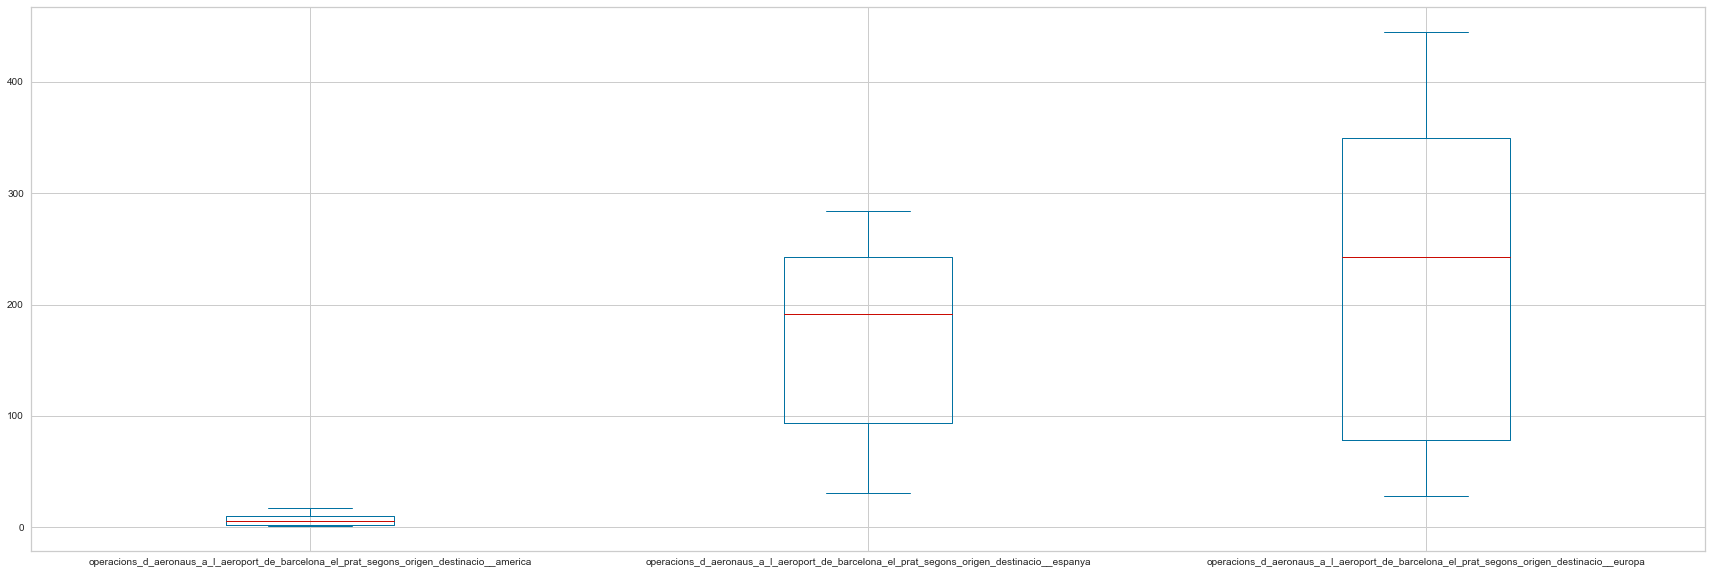

In [10]:
#Obtenemos los boxplots para las variables predictivas
bcn_ibex_data.loc[:,['operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america', 'operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya',
                     'operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa']].plot.box(figsize=(30,10));

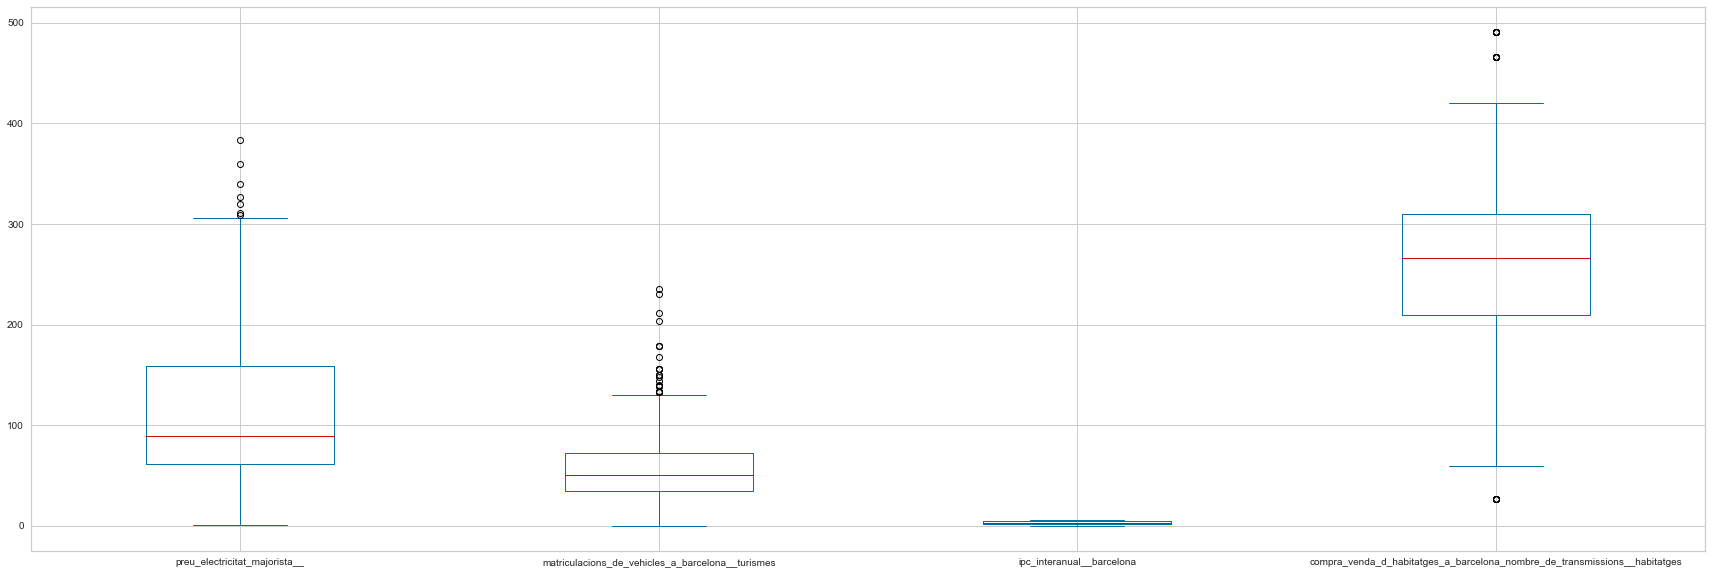

In [11]:
#Obtenemos los boxplots para las variables predictivas
bcn_ibex_data.loc[:,['preu_electricitat_majorista__', 'matriculacions_de_vehicles_a_barcelona__turismes',
                     'ipc_interanual__barcelona','compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges']].plot.box(figsize=(30,10));

Cabe destacar que contamos con variables que estan compuestas por un número grande outliers, como se puede apreciar en las variables:
    
- dades_meteorologiques_precipitacio__barcelona__zona_universitaria
- estat_del_transit_segons_trams_horaris__nit_0_5_

Ante un número tan grande de outliers en la primera variable mencionada, deberemos tener en mente que alomejor hará falta tomar ciertas medidas para que estos no afecten a nuestro análisis estadístico de los datos. Ya sea considerando eliminar la variable en cuestión o bien si solo son fruto de una variación natural de los datos, que no tiene porqué ser necesariamente un problema.

In [12]:
Q1 = bcn_ibex_data['estat_del_transit_segons_trams_horaris__nit_0_5_'].quantile(0.25)
Q3 = bcn_ibex_data['estat_del_transit_segons_trams_horaris__nit_0_5_'].quantile(0.75)
IQR = Q3 - Q1
big_outliers = bcn_ibex_data['estat_del_transit_segons_trams_horaris__nit_0_5_'] > (Q3 + 1.5 * IQR)
sum(big_outliers) #25
Q1 = bcn_ibex_data['dades_meteorologiques_precipitacio__barcelona__zona_universitaria'].quantile(0.25)
Q3 = bcn_ibex_data['dades_meteorologiques_precipitacio__barcelona__zona_universitaria'].quantile(0.75)
big_outliers = bcn_ibex_data['dades_meteorologiques_precipitacio__barcelona__zona_universitaria'] > (Q3 + 1.5 * IQR)
sum(big_outliers) #83 de 365

83

Anteriormente usando el método .info() ya podíamos ver si teníamos valores perdidos en nuestro data, pero podemos usar también: `.isna().sum()`

In [13]:
bcn_ibex_data.isna().sum()

compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges                    0
dades_meteorologiques_precipitacio__barcelona__zona_universitaria                            0
dades_meteorologiques_temperatura__barcelona__zona_universitaria                             0
dades_meteorologiques_vent__barcelona__zona_universitaria                                    0
estat_del_transit_segons_trams_horaris__mati_6_13_                                           0
estat_del_transit_segons_trams_horaris__nit_0_5_                                             0
estat_del_transit_segons_trams_horaris__tarda_14_19_                                         0
estat_del_transit_segons_trams_horaris__vespre_20_24_                                        0
ipc_interanual__barcelona                                                                    0
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america    0
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el

Al parecer no nos falta ningún valor para cada una de las variables de nuestro dataset.

##### Correlación entre distintas variables predictivas y la variable objetivo

A continuación, podemos visualizar la relación que hay entre las diferentes variables predictivas de nuestro dataset calculando la correlación que existe entre estas.

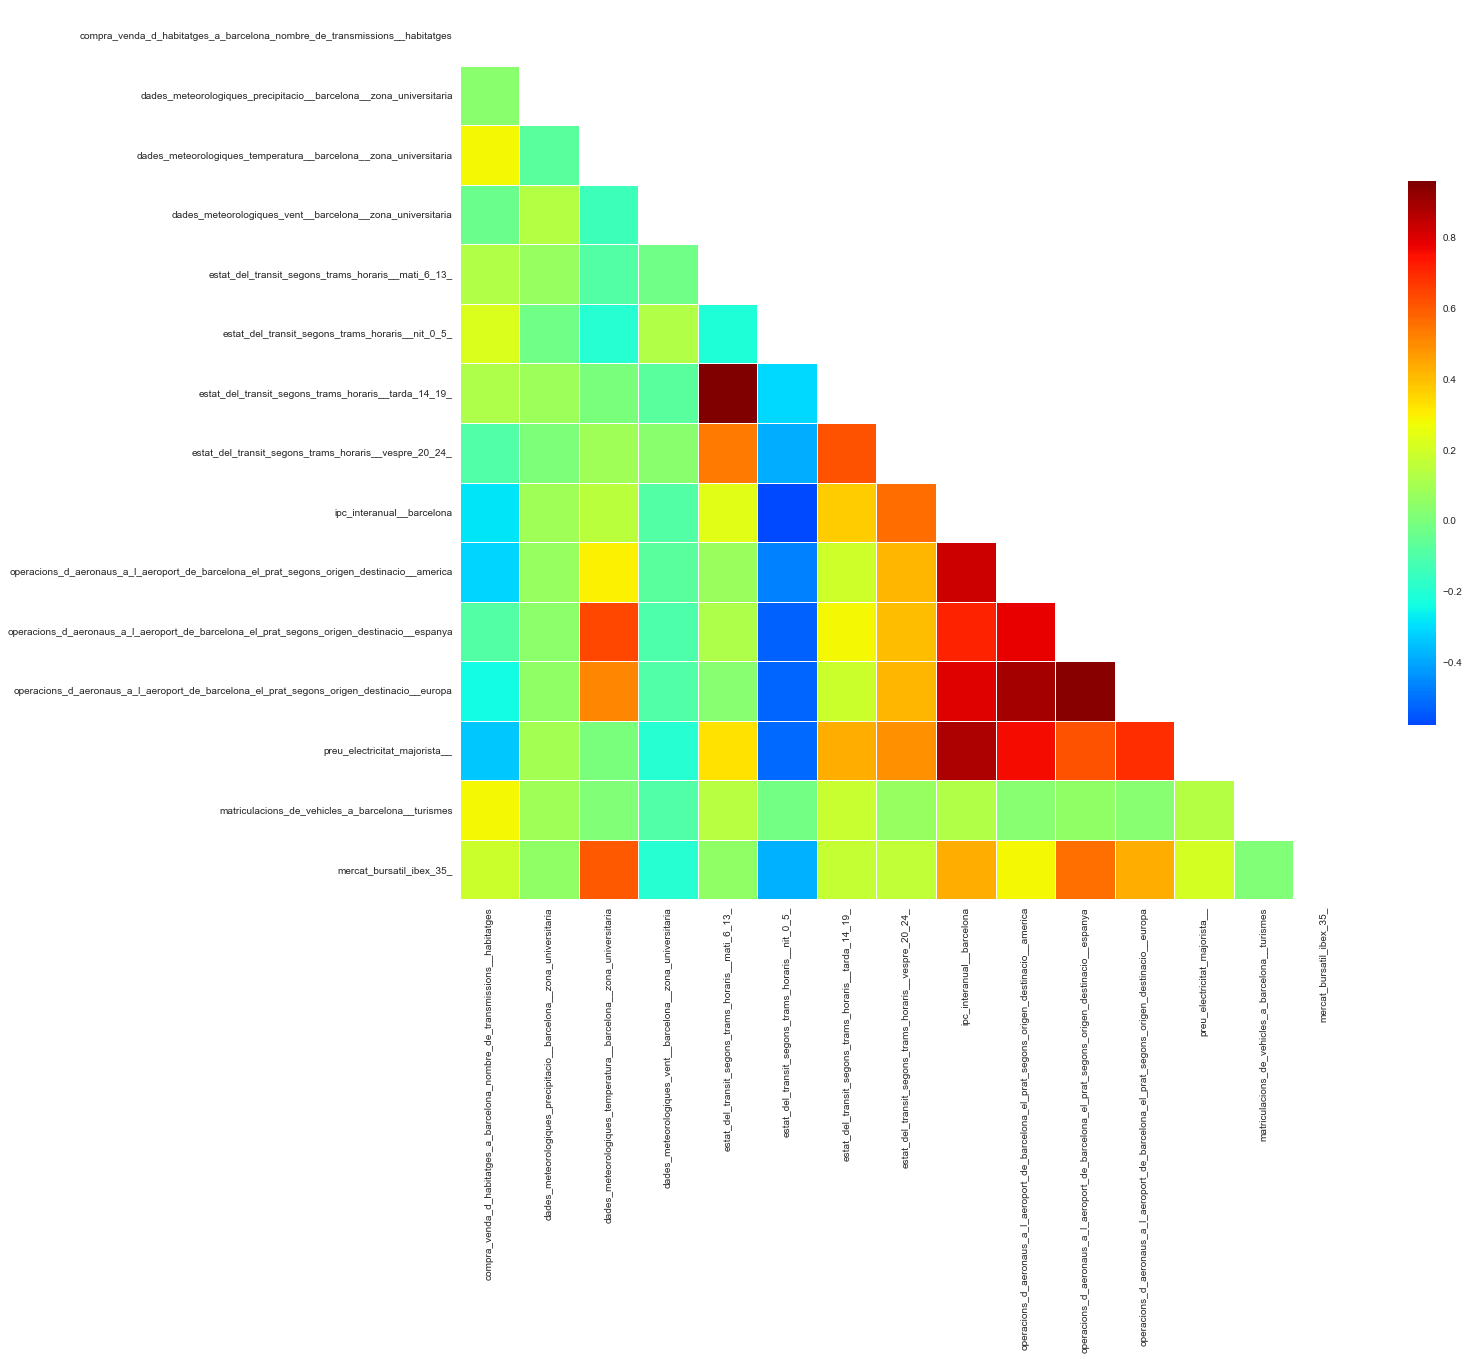

In [14]:
corr = bcn_ibex_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap='jet',  center=0, square=True, linewidths=.8, cbar_kws={"shrink": .5});

Como podemos apreciar, existen múltiples relaciones entre las distintas variables predictoras. Cabe destacar que algunas de estas correlaciones pues, son de esperar, como puede ser la relación entre que hay entre variables como son el **ipc_interanual__barcelona** y **preu_electricitat_majorista__** ya que el precio mayorista de la luz afecta directamente sobre el IPC.

También de forma normal, hay relación de ciertas variables como: **operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa** y **operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya**

Asimismo hay una relación directa entre el **estado del tránsito entre las 6 y las 13h** que afecta a como estará el tránsito en el tramo del **mediodia-tarde entre las 14-19h**.

Una vez hechos estos breves comentarios, procedamos con la resolución de los disintos apartados:

### Procedamos con los ejercicios que se nos piden

#### a) Divide el conjunto de datos en entrenamiento y test (80$\%$/ 20$\%$). Haz una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Describe las cosas que hayas visto que te parezcan interesantes. Transforma las variables adecuadamente para poder ajustar un modelo de regresión tanto para el conjunto de entrenamiento como para el de test.

##### Dividimos el conjunto de datos en entrenamiento y test

In [15]:
X = bcn_ibex_data.loc[:,bcn_ibex_data.columns != 'mercat_bursatil_ibex_35_']
y = bcn_ibex_data['mercat_bursatil_ibex_35_']

bcn_ibex_data.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Antes de hacer una exploración mínima del conjunto de datos de entrenamineto, he considerado antes que nada preprocesar estos datos(y los del conjunto de test) para que ya tengamos las features numéricas bien ajustadas para poder hacer posteriormente el model de regresión. 

##### Transformamos las variables adecuadamente en un mismo rango para poder ajustar un modelo de regresión

In [16]:
#escalamos para que todas las variables tengan el mismo rango para que aprovechemos mejor nuestros modelos
def scaling_preprocessing(X, y, scaler=None):
    numerical_columns = [c for c in X.columns]
    if scaler is None: 
        # datos de entrenamiento
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        # datos de test
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    return X, y, scaler

X_train, y_train, scaler = scaling_preprocessing(X_train,y_train)
X_test, y_test, _ = scaling_preprocessing(X_test,y_test,scaler)

##### Vemos como se ha realizado el escalado de las variables:

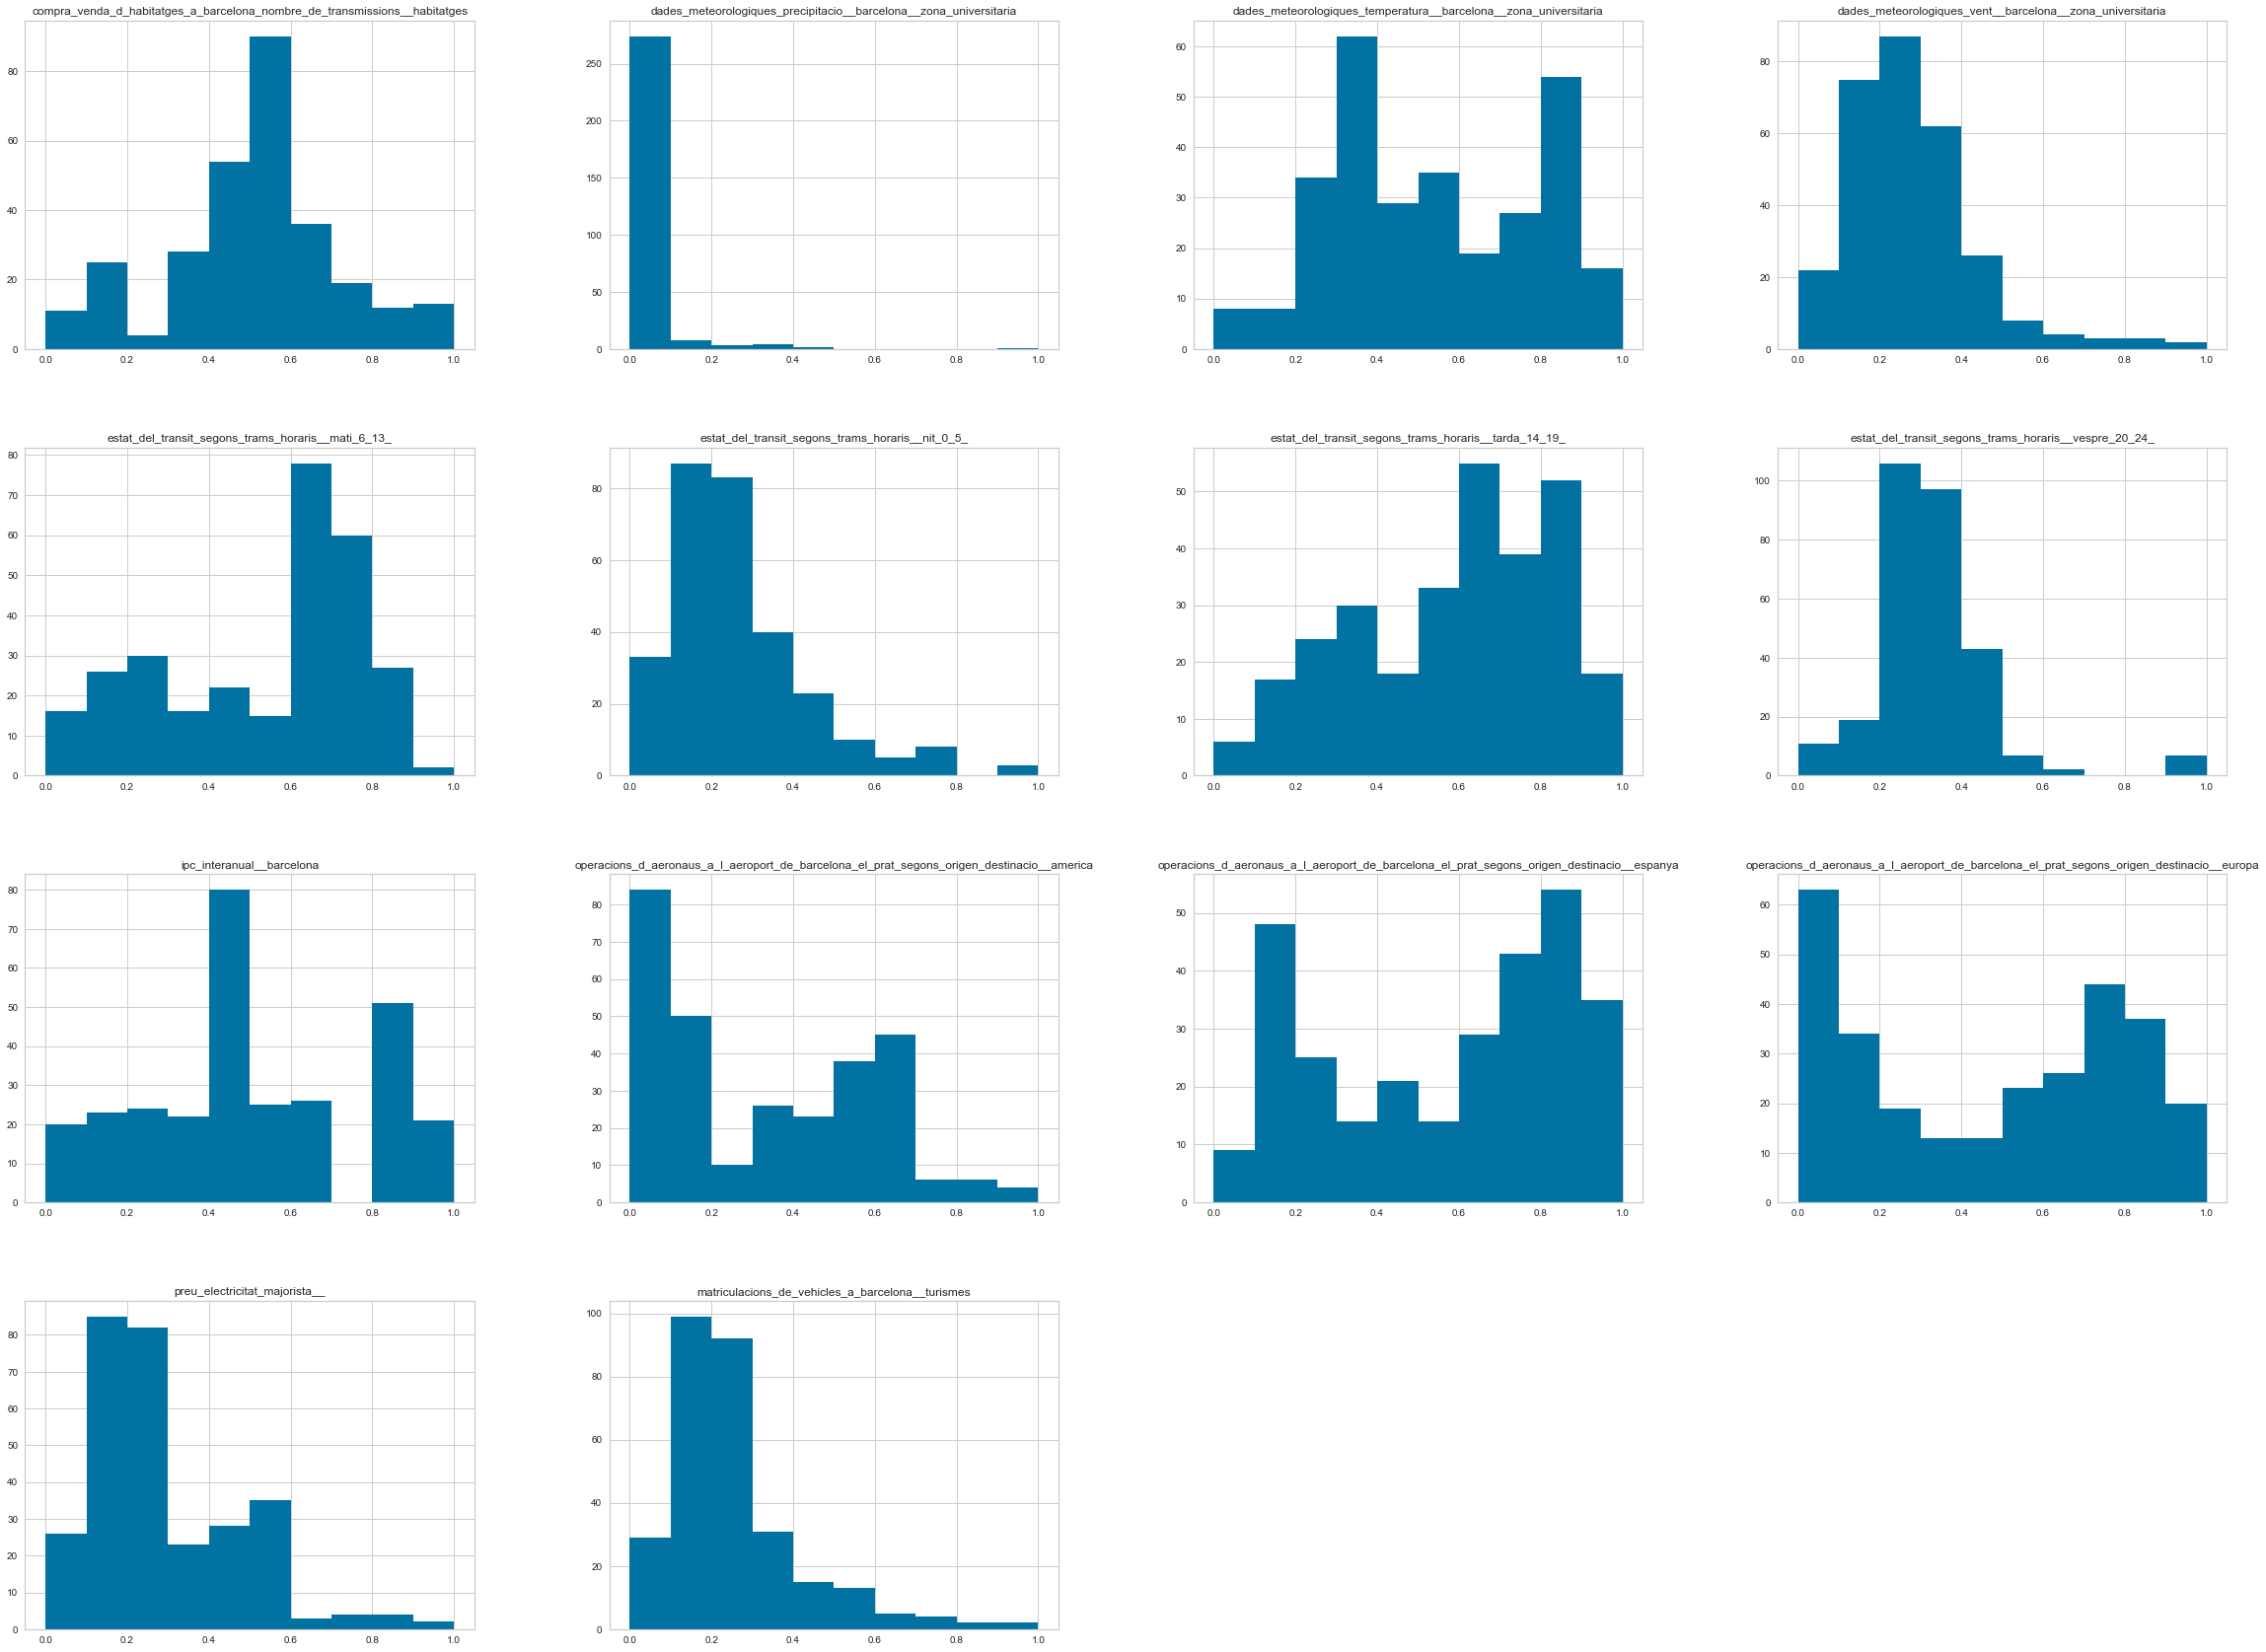

In [17]:
X_train.hist(figsize=(40,30));

##### Gráficos de la relación con la variable objetivo para todas las variables numéricas

Antes de la realización del primer apartado hemos realizado una mini exploración de los datos, ahora podemos realizar la explooración que sigue comparando cada variable predictora con la variable objetivo para ver la relación de ambas. Como se puede ver, para cada par, **variable objetivo-variable predictora** hemos generado un regplot mediante la librería de `seaborn`. Este método se utiliza para plotear los datos y ajustar un modelo de regresión lineal. 

Como podemos ver cada plot nos muestra dos valores, (r y p), los cuáles son la correlación de ambas varibles mediante el coeficiente de Pearson y el p-valor de este.

Debajo de estos, podemos ver lo mismo usando el método `feature_correlation`

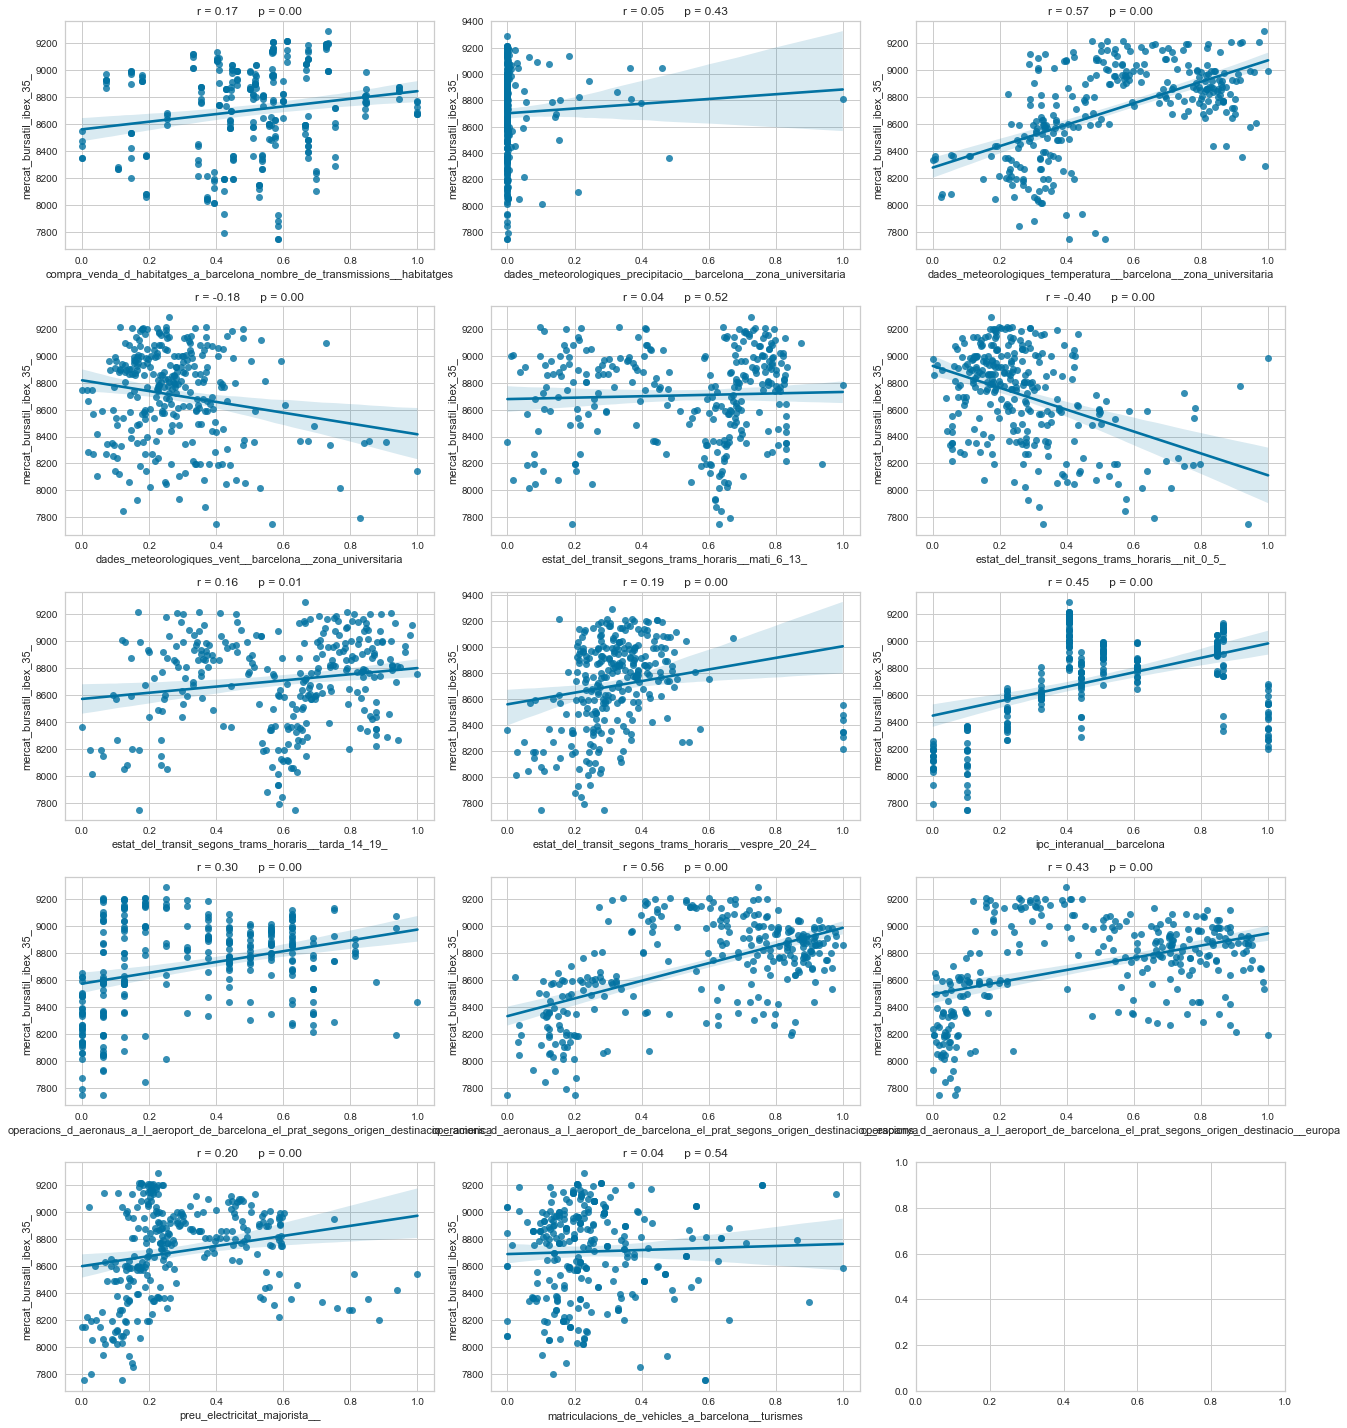

In [18]:
nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*4))

li_num_feats = list(X_train.columns)
li_plot_num_feats = [c for c in list(X_train.columns)]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=X_train[li_plot_num_feats[i]], y=y_train, ax = axs[r][c])
            #primer atributo(r) és la correlación, segundo atributo(p) és p-value
            stp = stats.pearsonr(X_train[li_plot_num_feats[i]], y_train)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=12)
            
plt.tight_layout()    
plt.show()

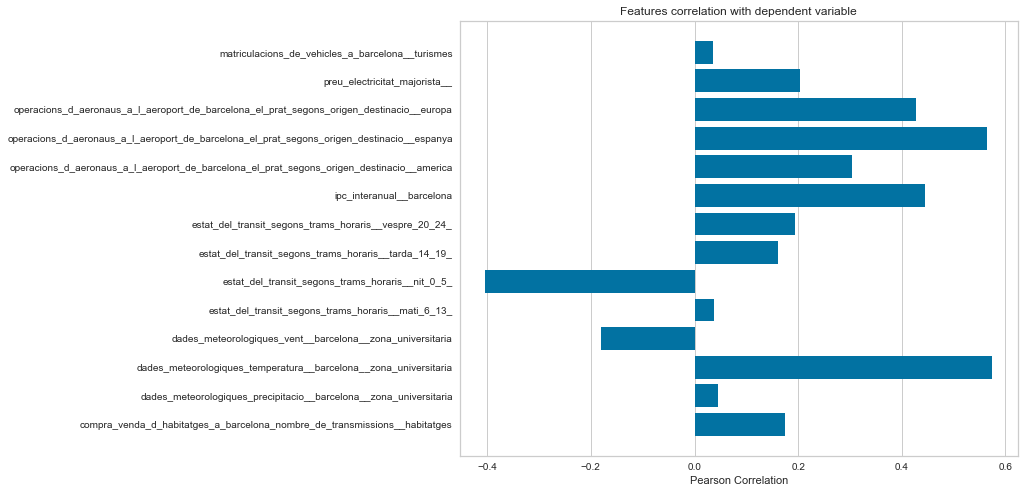

In [19]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns),method='pearson');

##### Antes de proceder a la instanciación del modelo de regresión lineal...

Anteriormente ya hemos visto algunos de los detalles y ya hemos comentado un poco las features y su relación. Ahora pero, comparando cada feature con la variable objetivo, podemos notar muchas más cosas.

Así pues compararemos y comentaremos un poco la dependencia lineal entre la característica objetivo contra las demás características.

Como bien sabemos, el coeficiente de correlación de Pearson puede abarcar un rango de -1 a 1. Y dos características tienen una correlación positiva perfecta si r = 1, ninguna correlación si r = 0 y una correlación negativa perfecta si r = -1. Como podemos ver en la lista anterior, o en los gráficos anteriores, podemos notar, lo siguente, por orden de correlación:

*CORRELACIÓN POSITIVA*

- Existe una relación importante positiva entre la variable de la **temperatura** y el valor de la cotización del IBEX, lo cuál me ha parecido un hecho de notar e interesante analizar. Es cierta esta relación puesto que *casi*, aunque no de forma notable, cada verano el mercado español "dispara" su crecimiento.
- Existe una relación importante positiva entre la varaible **operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya** y la variable objetivo. Esta relación es clara, puesto que el crecimiento del IBEX 35 depende del turismo y los viajes.
- También, como se espera, existe una relación positiva entre el **ipc_interanual__barcelona**, junto con **operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa**, por la misma relación que el punto anterior.

*CORRELACIÓN NEGATIVA*

- Existe una realción importante negativa entre la variable del **estat_del_transit_segons_trams_horaris__nit_0_5_** y la objetivo, este hecho me ha dejado un poco sorprendida, no sé muy bien a qué hecho en específico se puede deber, puesto que el mercado no se abre hasta las 9:00 h y no sé si el hecho de haber más o menos tráfico en esta franja horaria tiene algún peso sobre el crecimiento.

*CORRELACIÓN PRÓXIMA A 0*

Observamos que no existe casi corerlación entre la variables que siguien y la variable objetivo:

- **estat_del_transit_segons_trams_horaris__mati_6_13_**, del mismo modo que el punto sobre el estado del tráfico por la madrugada, tampoco tengo claro por qué a esta variable no se la atribuye apenas relación con el target.        
- **matriculacions_de_vehicles_a_barcelona__turismes**, si no me equivoco creo que ninguna empresa española de coches forma cotiza en el ibex 35, ya que la firma Seat no está en el ibex 35 y otras como Renault, PSA Peugeot, Citroën o Volkswagen cotizan en sus respectivos países. Y solo algunas que fabrican componentes estan en el ibex así que puedo más o menos entender esta correlación. 

- **dades_meteorologiques_precipitacio__barcelona__zona_universitaria**, aquí creo que podríamos abrir un debate, puesto que el hecho de que llueva más o menos en barcelona, depende de la época del año, por ejemplo, cuándo más en otoño. En otoño del pasado año creo que hubo un repunte de la inflación que se debió principalmente al aumento de los precios de la energía que guarda cierta relación con toda la serie de ajustes económicos posteriores a la pandemia. Así que el hecho que no afectase demasiado a la cotización del ibex puede tener más o menos sentido si realmente los cambios y precios no supusieron un gran cambio y fueses simplemente transitorios o bien, el hecho de que llueva en barcelona apenas influye en el mercado.

##### Una vez ajustados los datos aplicamos un  modelo de regresión lineal

In [20]:
lr = LinearRegression();
lr.fit(X_train,y_train);
y_pred = lr.predict(X_train);

weights = lr.coef_
intercept = lr.intercept_

print('Pesos: \n', weights[:])
print('Interceptor: \n', intercept)

Pesos: 
 [   58.31434209   209.05402523   609.23592311  -178.68785895
  -692.97827523  -184.79906129   755.71300833  -477.94449897
  1469.78149657   -68.6249372    865.15651294 -1152.75434966
  -987.04360981  -237.67109317]
Interceptor: 
 8225.473501660545


##### Usando statsmodels generamos una gran cantidad de datos estadísticos que nos pueden ser útiles

In [21]:
import statsmodels.api
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     mercat_bursatil_ibex_35_   R-squared:                       0.709
Model:                                  OLS   Adj. R-squared:                  0.694
Method:                       Least Squares   F-statistic:                     48.15
Date:                      Sun, 30 Oct 2022   Prob (F-statistic):           9.26e-66
Time:                              13:03:48   Log-Likelihood:                -1938.5
No. Observations:                       292   AIC:                             3907.
Df Residuals:                           277   BIC:                             3962.
Df Model:                                14                                         
Covariance Type:                  nonrobust                                         
=============================================================================================================================================================
                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                      8225.4735     67.554    121.761      0.000    8092.489    8358.458
compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges                    58.3143     68.826      0.847      0.398     -77.175     193.803
dades_meteorologiques_precipitacio__barcelona__zona_universitaria                           209.0540    134.025      1.560      0.120     -54.782     472.890
dades_meteorologiques_temperatura__barcelona__zona_universitaria                            609.2359     86.953      7.007      0.000     438.064     780.408
dades_meteorologiques_vent__barcelona__zona_universitaria                                  -178.6879     79.831     -2.238      0.026    -335.841     -21.535
estat_del_transit_segons_trams_horaris__mati_6_13_                                         -692.9783    199.948     -3.466      0.001   -1086.589    -299.367
estat_del_transit_segons_trams_horaris__nit_0_5_                                           -184.7991     83.592     -2.211      0.028    -349.355     -20.244
estat_del_transit_segons_trams_horaris__tarda_14_19_                                        755.7130    223.817      3.376      0.001     315.114    1196.312
estat_del_transit_segons_trams_horaris__vespre_20_24_                                      -477.9445    115.208     -4.149      0.000    -704.739    -251.150
ipc_interanual__barcelona                                                                  1469.7815    108.641     13.529      0.000    1255.915    1683.648
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america   -68.6249    116.684     -0.588      0.557    -298.325     161.075
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya   865.1565    153.017      5.654      0.000     563.933    1166.380
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa  -1152.7543    166.348     -6.930      0.000   -1480.220    -825.288
preu_electricitat_majorista__                                                              -987.0436    151.708     -6.506      0.000   -1285.690    -688.397
matriculacions_de_vehicles_a_barcelona__turismes                                           -237.6711     74.369     -3.196      0.002    -384.071     -91.272
==============================================================================
Omnibus:                        6.142   Durbin-Watson:                   1.877
Prob(Omnibus): 

Ante la salida y esta obtención de datos estadísticos, podemos ver qué variables son relevantes para predecir la variable objetivo. 

En este caso tenemos que con un intervalo de confianza del 95([0,025 0,975]) y con un p menor (0.05), podemos decir qué variables son relevante para predecir el valor de la cotización del ibex 35. Vemos que la mayoria nos pueden servir

Un ejemplo de estas son:

* dades_meteorologiques_temperatura__barcelona__zona_universitaria
* preu_electricitat_majorista__
* operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa
* operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya
* ipc_interanual__barcelona
* estat_del_transit_segons_trams_horaris__vespre_20_24_

##### Podemos ver que el gráfico parece gaussiano(residuos de los datos de entrenamiento) ya que es la suposición de la que partimos.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


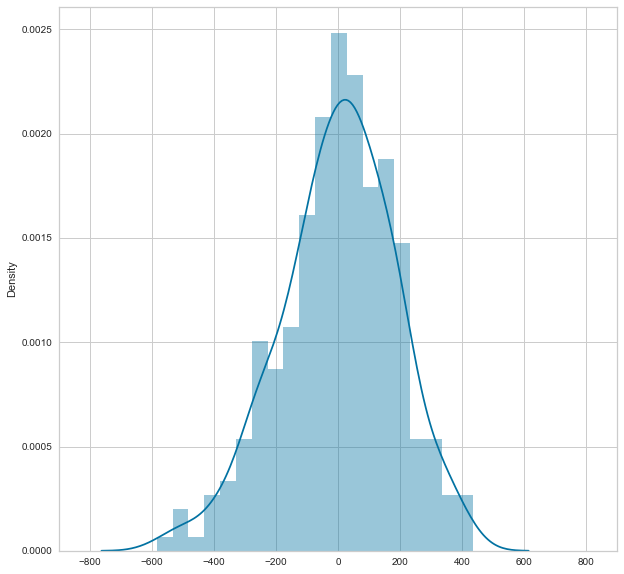

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-900,900])
sns.distplot(result.resid,bins=20);

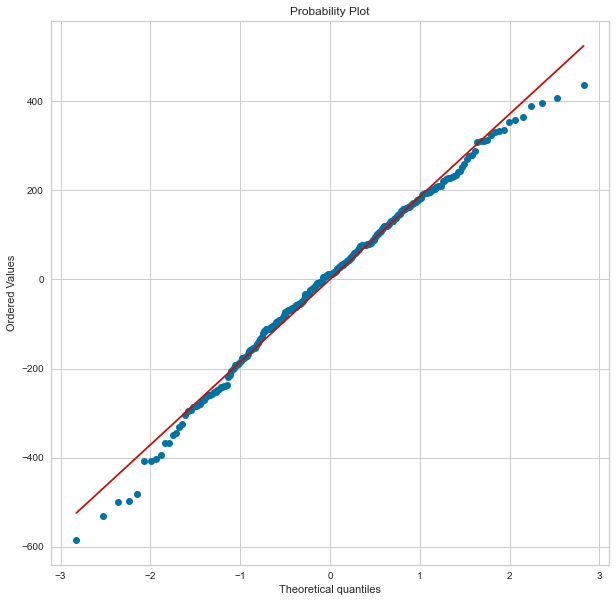

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
stats.probplot(result.resid, plot=plt);

También podemos visualizar los resulatdos aneriores y ver el gráfico de los residuos del conjunto de entrenamiento y test con el qqplot con la librería `yellowbrick`

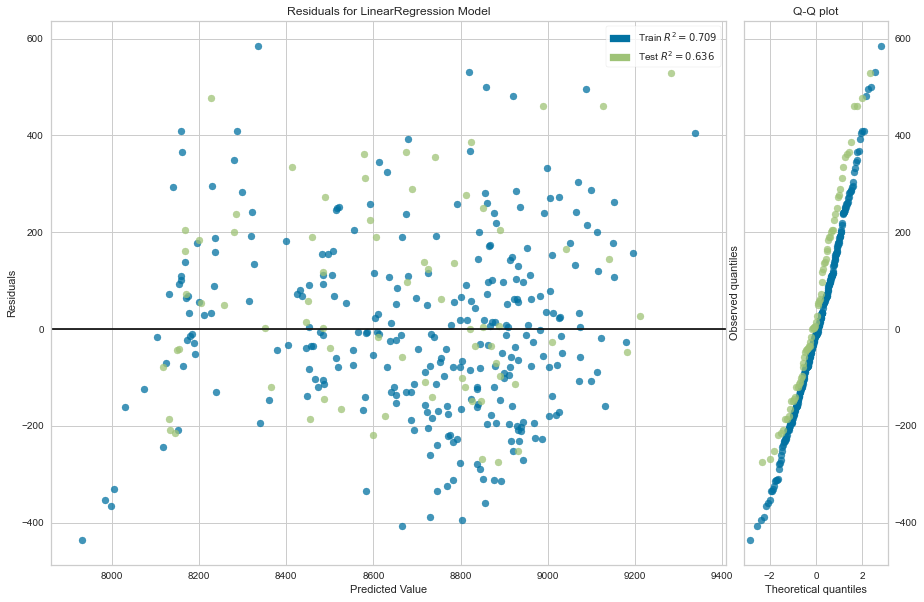

In [24]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(15,10));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

##### Representamos a continuación las predicciones respecto a los valores reales y sobre cuanto se desvían de la predicción ideal

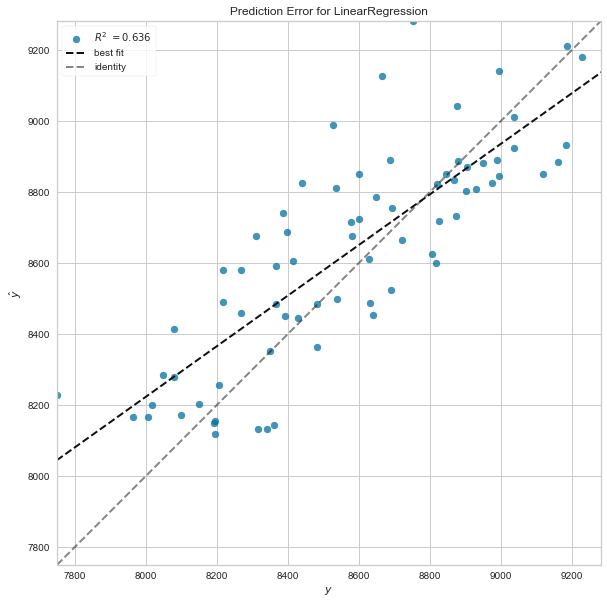

In [25]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(15,10))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True)

##### Podemos usar varias métricas vistas en clase de laboratori para medir el rendimiento de nuestro modelo de regresión

##### $Mean Squared Error$

In [26]:
N = X_train.shape[0]

prediction = result.predict(sm.add_constant(X_train))
mean_square_error = np.sum((y_train - prediction)**2)/N

mean_square_error

34179.20633092831

##### Normalized Mean Squared Error, vemos que el NMSE no llega a 0, lo que nos haría decir que tenemos una predicción perfecta 

In [27]:
norm_mse_sk = 1-r2_score(y_train,prediction)

norm_mse_sk

0.2912433980242074

##### $R^{2}$, vemos que nuestro modelo de regresión lineal solo explica un ~70.87% de la variable objetivo

In [28]:
R_squared_sk = r2_score(y_train,prediction) 

R_squared_sk

0.7087566019757926

##### MAE

In [29]:
mae_sk = mean_absolute_error(y_train,prediction)

mae_sk

145.81904310692846

##### Aplicando validación cruzada (Cross Validation)

Nuestro modelo nos puede llegar a convencer de que consigue muy buenos resultados con los datos de entrenamiento, pero no nos dice nada sobre su capacidad predictora con datos que aún no ha visto. Así que para saber qué tan bueno es nuestro modelo, usaremos la validación cruzada para calcular las métricas y comparar este modelo con futuros modelos para tomar decisiones sobre cuál es mejor y cuál nos ayuda a predecir mejor el valor de la cotización del ibex 35.

In [30]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

#considerar canviar la varible del kf per 5, val no és viable
kf = KFold(n_splits=10)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,11) if j != i]));
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression().fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')

    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse,fold_nmse, fold_r2]
    i+=1

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5, 6, 7, 8, 9, 10]
	MSE: 40589.526 NMSE: 0.386 R2: 0.614
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5, 6, 7, 8, 9, 10]
	MSE: 35090.585 NMSE: 0.313 R2: 0.687
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5, 6, 7, 8, 9, 10]
	MSE: 39689.480 NMSE: 0.411 R2: 0.589
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5, 6, 7, 8, 9, 10]
	MSE: 36320.664 NMSE: 0.427 R2: 0.573
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4, 6, 7, 8, 9, 10]
	MSE: 29562.931 NMSE: 0.263 R2: 0.737
Split 6: 
	Test Folds: [6] 
	Train Folds [1, 2, 3, 4, 5, 7, 8, 9, 10]
	MSE: 51696.772 NMSE: 0.366 R2: 0.634
Split 7: 
	Test Folds: [7] 
	Train Folds [1, 2, 3, 4, 5, 6, 8, 9, 10]
	MSE: 49511.247 NMSE: 0.321 R2: 0.679
Split 8: 
	Test Folds: [8] 
	Train Folds [1, 2, 3, 4, 5, 6, 7, 9, 10]
	MSE: 30408.801 NMSE: 0.289 R2: 0.711
Split 9: 
	Test Folds: [9] 
	Train Folds [1, 2, 3, 4, 5, 6, 7, 8, 10]
	MSE: 34594.818 NMSE: 0.279 R2: 0.721
Split 10: 
	Test Folds: [10]

In [31]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

MSE  norm_MSE        R2
Fold 1   40589.526128  0.385878  0.614122
Fold 2   35090.585262  0.313257  0.686743
Fold 3   39689.479573  0.410623  0.589377
Fold 4   36320.663873  0.427093  0.572907
Fold 5   29562.931432  0.263145  0.736855
Fold 6   51696.771758  0.365642  0.634358
Fold 7   49511.247448  0.320954  0.679046
Fold 8   30408.801138  0.288645  0.711355
Fold 9   34594.818222  0.279094  0.720906
Fold 10  33093.200448  0.300659  0.699341
Mean     38055.802528  0.335499  0.664501

In [32]:
lr = LinearRegression().fit(X_train,y_train);
folds_r2 = cross_val_score(lr, X_train,y_train, cv=10, scoring='r2')
lr_r2 = np.mean(folds_r2) 
folds_r2, lr_r2

(array([0.61412193, 0.68674253, 0.58937706, 0.57290716, 0.73685544,
        0.6343578 , 0.679046  , 0.71135464, 0.72090554, 0.69934143]),
 0.6645009519710174)

In [33]:
r2_results = pd.DataFrame({'lr':lr_r2},index=['CV R2'])
valorLRr2 = lr_r2
r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results

lr
CV R2     0.664501
Train R2  0.708757
lambda    0.000000

#### b) Aplica Análisis de Componentes Principales (PCA) al conjunto de entrenamiento y visualízalo en 2D representando la variable objetivo. ¿ Crees que puede haber una relación entre las variables del conjunto de datos y la variable objetivo? ¿Por qué?

Ahora vamos a usar PCA para hacer una mejor visualización de nuestros datos de entrenamiento.

Dado que tratamos de encontrar patrones entre los conjuntos de datos, queremos que los datos con los que tratemos se distribuyan en cada dimensión. Además, queremos que las dimensiones sean independientes. De modo que si los datos tienen una alta covarianza cuando se representan en n dimensiones, reemplazamos esas n dimensiones con una combinación lineal de esas, ya que si lo hacemos, nuestros datos solo dependerán de la combinación lineal de las n dimensiones que tienen una alta covarianza.

Entonces, lo que haremos será usar el PCA para encontrar un nuevo conjunto de dimensiones(o un conjunto de bases) de modo que todas las dimensiones sean ortogonales (y, por lo tanto, linealmente independientes) y se clasifiquen de acuerdo con la varianza de los datos a lo largo de ellas.

Así pues este análisis de Componentes Princiaples(PCA) se basa en la matriz de covarianza de las variables. Por esta razón, si queremos que funcione de la mejor manera, debemos estandarizar los datos. Esto cambiará los datos para que todas las variables tengan media 0 y desviación estándar 1.

Con esta nueva representación queremos encuentrar las dimensiones linealmente independientes que puedan representar sin pérdidas el conjunto de de datos. Estas dimensiones recién encontradas nos deberían permitir predecir/reconstruir las dimensiones originales. Así pues, si minimizamos el error de reconstrucción/proyección de los datos, nuestra varianza augmentará.

##### Estandarizamos ambos conjuntos de datos, entrenamiento y test respectivamente

In [34]:
X_train_standarized = X_train.copy()
scaler = StandardScaler()
X_train_standarized[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train_standarized.describe().T

count          mean  \
compra_venda_d_habitatges_a_barcelona_nombre_de...  292.0  3.524578e-16   
dades_meteorologiques_precipitacio__barcelona__...  292.0 -1.604500e-16   
dades_meteorologiques_temperatura__barcelona__z...  292.0 -1.897265e-16   
dades_meteorologiques_vent__barcelona__zona_uni...  292.0  2.406751e-16   
estat_del_transit_segons_trams_horaris__mati_6_13_  292.0 -6.330553e-17   
estat_del_transit_segons_trams_horaris__nit_0_5_    292.0  7.300097e-17   
estat_del_transit_segons_trams_horaris__tarda_1...  292.0  1.366867e-16   
estat_del_transit_segons_trams_horaris__vespre_...  292.0 -1.942890e-16   
ipc_interanual__barcelona                           292.0 -2.608264e-16   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  292.0  5.246944e-17   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  292.0  3.726091e-17   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  292.0  1.452415e-16   
preu_electricitat_majorista__                       292.0  3.726091e-17   
matriculacions_de_vehicles_a_barcelona__turismes    292.0  3.098739e-16   

                                                         std       min  \
compra_venda_d_habitatges_a_barcelona_nombre_de...  1.001717 -2.413277   
dades_meteorologiques_precipitacio__barcelona__...  1.001717 -0.233491   
dades_meteorologiques_temperatura__barcelona__z...  1.001717 -2.172762   
dades_meteorologiques_vent__barcelona__zona_uni...  1.001717 -1.793732   
estat_del_transit_segons_trams_horaris__mati_6_13_  1.001717 -2.185952   
estat_del_transit_segons_trams_horaris__nit_0_5_    1.001717 -1.570943   
estat_del_transit_segons_trams_horaris__tarda_1...  1.001717 -2.458151   
estat_del_transit_segons_trams_horaris__vespre_...  1.001717 -2.194059   
ipc_interanual__barcelona                           1.001717 -1.697385   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  1.001717 -1.248511   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  1.001717 -1.919265   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  1.001717 -1.427856   
preu_electricitat_majorista__                       1.001717 -1.556001   
matriculacions_de_vehicles_a_barcelona__turismes    1.001717 -1.523113   

                                                         25%       50%  \
compra_venda_d_habitatges_a_barcelona_nombre_de... -0.517039  0.043677   
dades_meteorologiques_precipitacio__barcelona__... -0.233491 -0.233491   
dades_meteorologiques_temperatura__barcelona__z... -0.856225 -0.093709   
dades_meteorologiques_vent__barcelona__zona_uni... -0.683356 -0.155473   
estat_del_transit_segons_trams_horaris__mati_6_13_ -0.924964  0.397354   
estat_del_transit_segons_trams_horaris__nit_0_5_   -0.640363 -0.207354   
estat_del_transit_segons_trams_horaris__tarda_1... -0.886622  0.208662   
estat_del_transit_segons_trams_horaris__vespre_... -0.536525 -0.113893   
ipc_interanual__barcelona                          -0.567966 -0.151865   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -1.007874 -0.045325   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -1.035715  0.249450   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -1.066104  0.177417   
preu_electricitat_majorista__                      -0.681815 -0.328257   
matriculacions_de_vehicles_a_barcelona__turismes   -0.630248 -0.222081   

                                                         75%        max  
compra_venda_d_habitatges_a_barcelona_nombre_de...  0.726731   2.317125  
dades_meteorologiques_precipitacio__barcelona__... -0.233491  11.269367  
dades_meteorologiques_temperatura__barcelona__z...  1.029046   1.865964  
dades_meteorologiques_vent__barcelona__zona_uni...  0.472527   4.674359  
estat_del_transit_segons_trams_horaris__mati_6_13_  0.794432   1.890186  
estat_del_transit_segons_trams_horaris__nit_0_5_    0.356011   4.289694  
estat_del_transit_segons_trams_horaris__tarda_1...  0.829507   1.695398  
estat_del_transit_segons_trams_horaris__vespre_...  0.376901   4.522735  
ipc_interanual__barcelona             

In [35]:
X_test_standarized = X_test.copy()
X_test_standarized[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test_standarized.describe().T

count      mean       std  \
compra_venda_d_habitatges_a_barcelona_nombre_de...   73.0 -0.244432  1.024871   
dades_meteorologiques_precipitacio__barcelona__...   73.0 -0.116241  0.446843   
dades_meteorologiques_temperatura__barcelona__z...   73.0 -0.316034  1.033048   
dades_meteorologiques_vent__barcelona__zona_uni...   73.0  0.114495  1.290856   
estat_del_transit_segons_trams_horaris__mati_6_13_   73.0 -0.091467  1.070006   
estat_del_transit_segons_trams_horaris__nit_0_5_     73.0 -0.023783  1.031954   
estat_del_transit_segons_trams_horaris__tarda_1...   73.0 -0.103117  1.063760   
estat_del_transit_segons_trams_horaris__vespre_...   73.0 -0.070348  1.304089   
ipc_interanual__barcelona                            73.0 -0.060664  1.160159   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...   73.0  0.106309  1.100918   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...   73.0 -0.140061  1.072710   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...   73.0 -0.063441  1.090936   
preu_electricitat_majorista__                        73.0 -0.082657  1.078255   
matriculacions_de_vehicles_a_barcelona__turismes     73.0 -0.064126  0.961755   

                                                         min       25%  \
compra_venda_d_habitatges_a_barcelona_nombre_de... -2.413277 -0.843273   
dades_meteorologiques_precipitacio__barcelona__... -0.233491 -0.233491   
dades_meteorologiques_temperatura__barcelona__z... -2.134090 -1.041179   
dades_meteorologiques_vent__barcelona__zona_uni... -1.720920 -0.719762   
estat_del_transit_segons_trams_horaris__mati_6_13_ -2.478453 -1.123334   
estat_del_transit_segons_trams_horaris__nit_0_5_   -1.625223 -0.684363   
estat_del_transit_segons_trams_horaris__tarda_1... -2.713032 -0.820895   
estat_del_transit_segons_trams_horaris__vespre_... -2.087401 -0.646183   
ipc_interanual__barcelona                          -1.697385 -0.924625   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -1.248511 -0.767236   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -1.852329 -1.196360   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -1.488148 -1.194225   
preu_electricitat_majorista__                      -1.566745 -0.855532   
matriculacions_de_vehicles_a_barcelona__turismes   -1.523113 -0.655758   

                                                         50%       75%  \
compra_venda_d_habitatges_a_barcelona_nombre_de...  0.002898  0.349522   
dades_meteorologiques_precipitacio__barcelona__... -0.233491 -0.233491   
dades_meteorologiques_temperatura__barcelona__z... -0.672952  0.578011   
dades_meteorologiques_vent__barcelona__zona_uni... -0.137270  0.530169   
estat_del_transit_segons_trams_horaris__mati_6_13_  0.387694  0.654135   
estat_del_transit_segons_trams_horaris__nit_0_5_   -0.225447  0.259787   
estat_del_transit_segons_trams_horaris__tarda_1...  0.146046  0.703572   
estat_del_transit_segons_trams_horaris__vespre_... -0.204219  0.169751   
ipc_interanual__barcelona                          -0.270751  1.274769   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -0.285962  0.917223   
operacions_d_aeronaus_a_l_aeroport_de_barcelona...  0.021869  0.905419   
operacions_d_aeronaus_a_l_aeroport_de_barcelona... -0.086360  1.036578   
preu_electricitat_majorista__                      -0.370754  0.528520   
matriculacions_de_vehicles_a_barcelona__turismes   -0.222081  0.364659   

                                                         max  
compra_venda_d_habitatges_a_barcelona_nombre_de...  2.062254  
dades_meteorologiques_precipitacio__barcelona__...  2.800727  
dades_meteorologiques_temperatura__barcelona__z...  1.758354  
dades_meteorologiques_vent__barcelona__zona_uni...  4.941334  
estat_del_transit_segons_trams_horaris__mati_6_13_  1.493895  
estat_del_transit_segons_trams_horaris__nit_0_5_    3.222180  
estat_del_transit_segons_trams_horaris__tarda_1...  1.579799  
estat_del_transit_segons_trams_horaris__vespre_...  4.522735  
ipc_interanual__barcelona                      

##### Creo que es interesante ver como se verian las variables sin realizar el PCA y por lo tanto la poca informació que podemos sacar de nuestro conjunto de datos

<AxesSubplot:xlabel='dades_meteorologiques_vent__barcelona__zona_universitaria', ylabel='estat_del_transit_segons_trams_horaris__vespre_20_24_'>

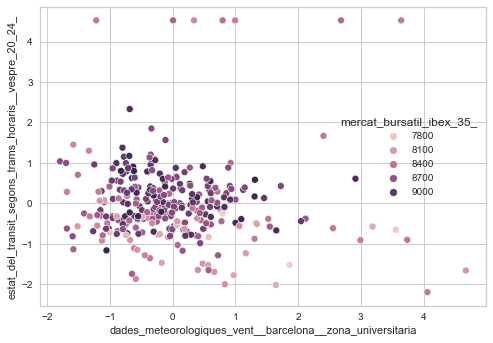

In [36]:
sns.scatterplot(x=X_train_standarized.iloc[:,3], y=X_train_standarized.iloc[:,7], hue=y_train)

<AxesSubplot:xlabel='dades_meteorologiques_vent__barcelona__zona_universitaria', ylabel='dades_meteorologiques_precipitacio__barcelona__zona_universitaria'>

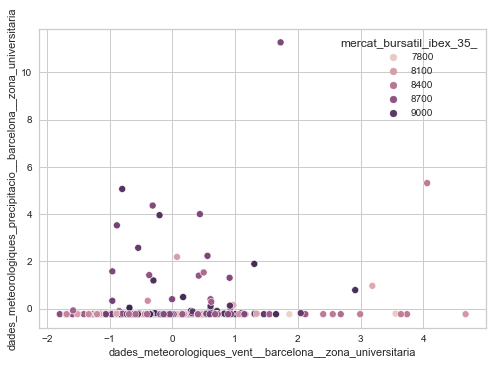

In [37]:
sns.scatterplot(x=X_train_standarized.iloc[:,3], y=X_train_standarized.iloc[:,1], hue=y_train)

##### El método PCA de scikit-learn devolverá la relación de varianza  explicada y todos los parámetros importantes relacionados con PCA

In [38]:
myPCA = PCA().fit(X_train_standarized[X_train.columns]);

#PCA.explained_variance_ratio_ para comprender qué porcentaje de varianza explican los datos
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.38039813 0.16023858 0.11388127 0.08210167 0.08021444 0.05049677
 0.04361016 0.03057515 0.0289902  0.01114009 0.00849532 0.00630022
 0.00193896 0.00161904]
[0.38039813 0.54063671 0.65451798 0.73661965 0.81683408 0.86733086
 0.91094102 0.94151617 0.97050637 0.98164646 0.99014179 0.996442
 0.99838096 1.        ]


##### Scree plot se usa para comprender la cantidad de componentes principales que  se deben usar para capturar la varianza deseada en los datos

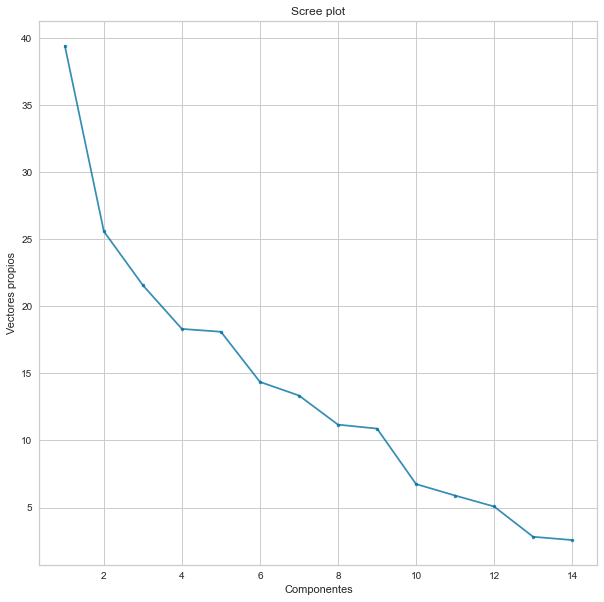

In [39]:
fig = plt.figure(figsize=(10,10));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
#La nueva base son los vectores propios de la matriz de covarianza.
y_label = plt.ylabel('Vectores propios');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

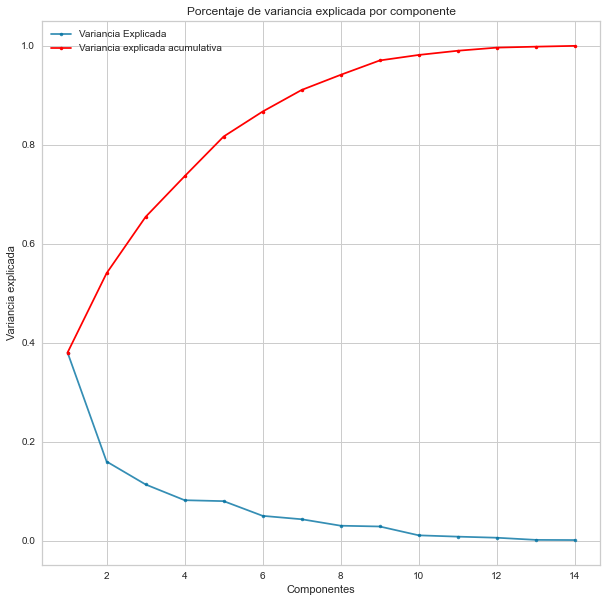

In [40]:
fig = plt.figure(figsize=(10,10));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Vemos que necesitamos muchos componenentes para poder explicar bien la varianza de nuestros datos

In [41]:
#myPCA.components_ para ver los componentes PCA generados
df_std_pca = pd.DataFrame(myPCA.components_).loc[:,:]
df_std_pca

0         1         2         3         4         5         6   \
0   0.098473 -0.033748 -0.153044  0.092800 -0.150965  0.287830 -0.215986   
1  -0.140070 -0.078718  0.293189 -0.037840 -0.582131 -0.020840 -0.541717   
2  -0.646846  0.068407 -0.536934  0.208660 -0.054257 -0.041028 -0.087272   
3   0.120303  0.768333 -0.166801  0.194762 -0.147171  0.093214 -0.125493   
4  -0.083624 -0.248163 -0.282531 -0.721962 -0.120405 -0.019814 -0.106636   
5   0.016567  0.537920  0.101056 -0.545589  0.096227 -0.271409  0.089944   
6   0.049664  0.062722 -0.000416 -0.207027  0.086331  0.886447  0.079083   
7  -0.113053  0.182018  0.100069 -0.173200 -0.273102  0.076878 -0.183181   
8   0.709511 -0.095011 -0.331371  0.060741 -0.192860 -0.132482 -0.175489   
9   0.047459  0.005280 -0.251708 -0.078455  0.111809 -0.131748  0.032984   
10 -0.078306  0.018471  0.540234  0.062401  0.129001 -0.025514 -0.074717   
11 -0.042264 -0.010161 -0.064471 -0.045126  0.037731  0.070469  0.086165   
12  0.041342  0.002105  0.038048  0.001954  0.295348 -0.006762 -0.244925   
13  0.000212  0.011760 -0.061857 -0.030850  0.594090  0.004750 -0.687298   

          7         8         9         10        11        12        13  
0  -0.287295 -0.395967 -0.372401 -0.371910 -0.385591 -0.370751 -0.048777  
1  -0.280967  0.011129  0.201186  0.202868  0.252719 -0.065823 -0.158512  
2   0.017461  0.130571  0.082364 -0.202111 -0.053953  0.206103 -0.349935  
3  -0.150388  0.114915  0.088853 -0.018293  0.027877  0.116538  0.474268  
4  -0.126305  0.113056  0.005622 -0.173406 -0.092534  0.216402  0.435752  
5  -0.172571 -0.101345 -0.110912  0.002196 -0.058886 -0.046480 -0.503478  
6   0.010689  0.031276  0.235565  0.056117  0.119316  0.136010 -0.242440  
7   0.848137  0.002906 -0.131687 -0.124203 -0.049211 -0.210476  0.034522  
8   0.132591  0.262023  0.119901 -0.159119 -0.068954  0.200437 -0.343027  
9   0.047401 -0.327925  0.702422 -0.150350  0.164340 -0.490732  0.060432  
10 -0.053505  0.225902  0.355267 -0.584621 -0.362307  0.147424  0.003852  
11 -0.148731  0.748504 -0.095526  0.014532  0.014005 -0.621274 -0.014534  
12 -0.020369  0.001574 -0.277467 -0.485288  0.731919  0.030784  0.002692  
13  0.072023  0.036200  0.029966  0.324458 -0.236950 -0.026584  0.014796

##### Pesos que le asigna el PCA a cada componente visualizado con un heatmap

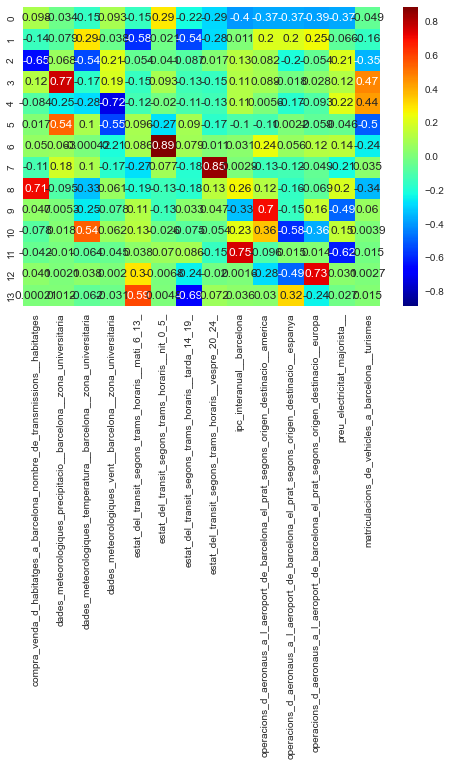

In [42]:
sns.heatmap(myPCA.components_, cmap='jet', xticklabels=list(X_train_standarized.columns[:]), vmin=-np.max(np.abs(myPCA.components_)), vmax=np.max(np.abs(myPCA.components_)),annot=True);

##### Transformamos nuestro conjunto de datos utilizando el PCA

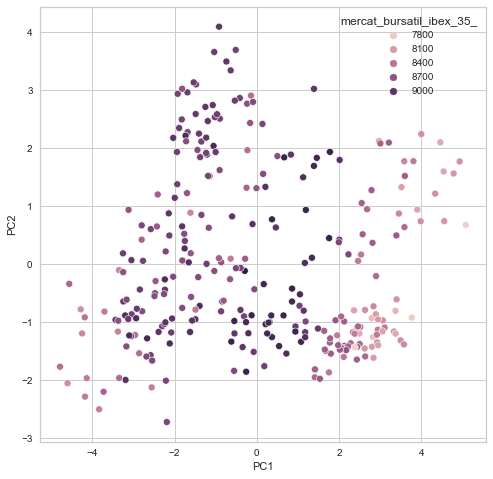

In [43]:
transformed_train = myPCA.transform(X_train_standarized[X_train.columns])

transformed_train

X_train_standarized[['PC1','PC2','PC3']] = transformed_train[:,:3]

fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', data=X_train_standarized, hue=y_train)

In [44]:
import plotly.express as px

fig = px.scatter_3d(X_train_standarized, x='PC1', y='PC2', z='PC3',color=y_train)
fig.show()

Sí, tanto en el gráfico 2D como en este gráfico 3D, podemos ver que hay una relación entre las variables predictoras y la variable objetivo. Podemos ver que para valores de cotización del ibex 35 bajos, con respecto a los máximos(en color amarillo), estos rodean a los valores más grandes de cotización quedando más alejados del origen de los ejes( agrupándose por valores de cotización parecidos) que los valores mayores que si que quedan más agrupados entorno al origen de coordenadas. Así pues en este gráfico PCA vemos los distintos grupos de datos en función del su similitud(valor de cotización del mercado del ibex 35). 

Aún así también vemos valores outliers que no estan en el grupo que les tocaria o que se encuentran un poco alejados. Esto no es muy malo, y no significa que vayamos a hacer predicciones muy malas para estos casos debemos recordar pues que no estamos capturando toda la variación de las features está en las dos primeras CP.

###### Podemos hacer el gráfico de loadings(vectores propios · $\sqrt(valores propios)$ auque con el nombre de variables que tenemos no se aprecia demasiado bien

In [45]:
loadings = myPCA.components_.T * np.sqrt(myPCA.explained_variance_ratio_)

fig = px.scatter(X_train_standarized, x='PC1', y='PC2', color=y_train)

for i, feature in enumerate(X_train.columns):
    fig.add_shape(type='line',x0=0, y0=0,x1=loadings[i, 0],y1=loadings[i, 1])
    fig.add_annotation(x=loadings[i, 0],y=loadings[i, 1],ax=0, ay=0,xanchor="center",yanchor="bottom",text=feature,)
fig.show()

Podemos ver que mediante los ángulos que forman unos vectores con los otros nos ayuda también a interpretar la correlación entre las variables predictoras. Por ejemplo entre las variables:

- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa
- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya
---------
- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya
- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america

In [ ]:
#![newplot-5.png](attachment:newplot-5.png)

In [ ]:
#![newplot-6%202.png](attachment:newplot-6%202.png)

#### c) Ajusta una regresión lineal, una regresión Ridge y una regresión LASSO a los datos ¿Te parece suficientemente bueno el resultado? Representa los valores de la variable objetivo para el conjunto de test contra las predicciones y el qqplot. ¿Qué modelo te parece mejor? ¿Tienen sentido las variables con más peso que aparecen en los modelos para la variable que queremos predecir? Elimina las variables que tienen menos peso en los modelos del conjunto de datos y reajusta el modelo de regresión lineal ¿Cómo ha cambiado el peso de las variables que quedan?

En el apartado **a)** aprovechando que hemos escalado los datos, hemos realizado el ajuste de la regresión lineal. Así que a continuación, ajustaré la regressión regularización usando Ridge y LASSO a nuestro conjunto de datos. 

##### RIDGE REGRESSION

Aplicaremos esta regresión de Ridge, regularizada, para ver si nuestro modelo mejora al añadirle esta regularización mediante el mejor hiperparámetro $\lambda$.

Hemos dicho en la sección anterior que podemos usar métricas de validación cruzada para comparar el rendimiento predictivo de diferentes modelos. Podemos hacer lo mismo para comparar el mismo modelo con diferentes hiperparámetros.

In [46]:
ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
lambdas = [1e-4,1e-3,1e-2,0.04,0.05,0.06,0.065,0.066,0.067,0.068,0.07,0.08,0.09,0.1,0.15,0.2,0.3,0.5,1,5,10,50,100]
# Calculamos las metricas de validación cruzada para cada lambda
for lambda_val in lambdas:
    kf = KFold(n_splits=10) #mejor resultado con 5 que para 10 de 0.665 a 0.0669
    i=1
    cv_mse = []
    cv_nmse = []
    cv_r2 = []
    for train_index, test_index in kf.split(X_train):
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index,:]
        y_test_fold = y_train.values[test_index]

        lr = Ridge(alpha=lambda_val).fit(x_train_fold,y_train_fold)
        y_pred_fold = lr.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        cv_mse.append(fold_mse)
        cv_nmse.append(fold_nmse)
        cv_r2.append(fold_r2)
    ridge_cross_val_metrics.loc[f'Lambda={lambda_val}',:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]
    
ridge_cross_val_metrics.sort_values(by='mean R2',ascending=False)

mean MSE mean norm_MSE   mean R2
Lambda=0.067   37946.983818      0.334387  0.665613
Lambda=0.066   37946.788873      0.334387  0.665613
Lambda=0.068   37947.224214      0.334387  0.665613
Lambda=0.065    37946.63974      0.334388  0.665612
Lambda=0.07    37947.839938      0.334389  0.665611
Lambda=0.06    37946.594102      0.334397  0.665603
Lambda=0.08    37953.527627      0.334422  0.665578
Lambda=0.05    37950.156009      0.334448  0.665552
Lambda=0.09    37963.324273      0.334491  0.665509
Lambda=0.04    37958.928817      0.334546  0.665454
Lambda=0.1     37976.926276      0.334595  0.665405
Lambda=0.01    38021.214577      0.335167  0.664833
Lambda=0.001   38051.995869      0.335463  0.664537
Lambda=0.0001   38055.41828      0.335495  0.664505
Lambda=0.15    38093.072874       0.33555   0.66445
Lambda=0.2     38271.081856      0.337064  0.662936
Lambda=0.3     38744.697796      0.341153  0.658847
Lambda=0.5     39912.187669       0.35133   0.64867
Lambda=1       42962.048166      0.378075  0.621925
Lambda=5       56657.640397       0.49904   0.50096
Lambda=10      63913.689734      0.563416  0.436584
Lambda=50      81878.302386      0.721075  0.278925
Lambda=100     90551.554315      0.795901  0.204099

##### Pesos que asigna el modelo de Ridge

In [47]:
ridge_cv = RidgeCV(alphas=lambdas,cv=10).fit(X_train,y_train)
print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best lambda: 0.067 R2 score: 0.666


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1911: RuntimeWarning:

invalid value encountered in reciprocal



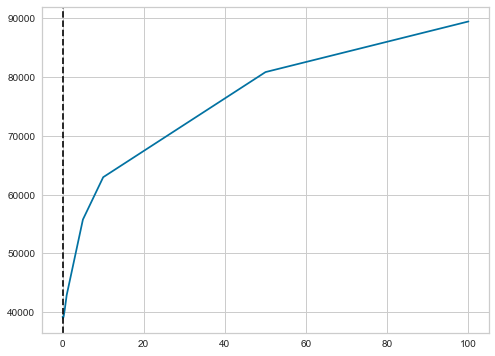

In [48]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(RidgeCV(alphas=lambdas));
vis.fit(X_train, y_train);

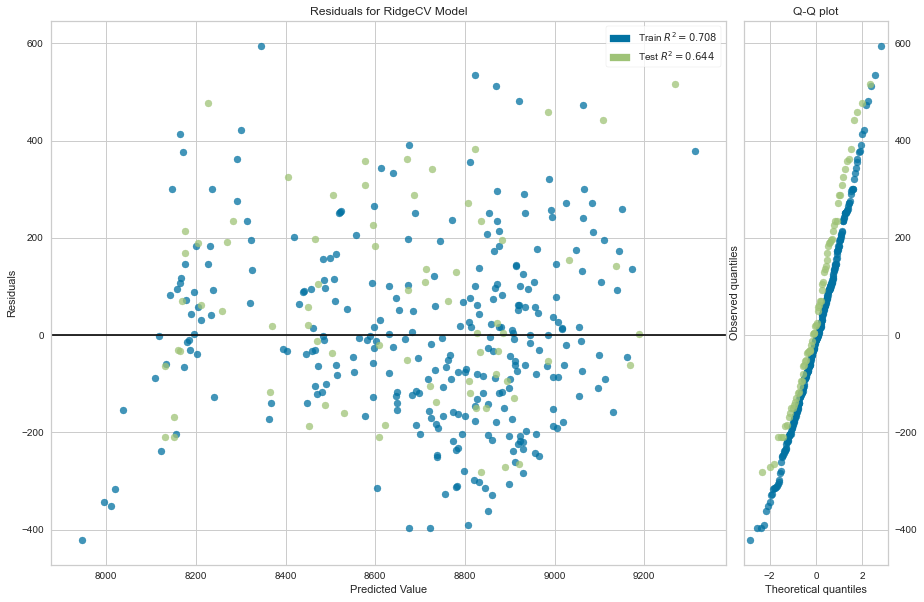

In [49]:
#comparamos los modelos para comprobar el que ajusta mejor y elabora mejores prodecciones sobre el conjunto de test
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(15,10));
viz = residuals_plot(ridge_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

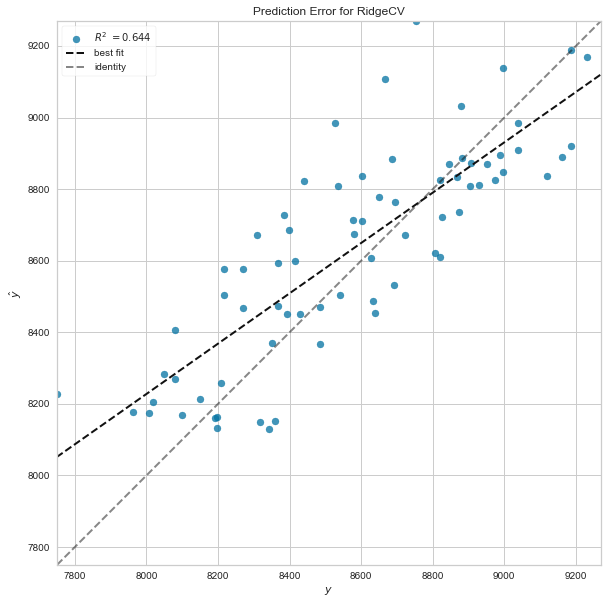

In [50]:
#calculamos el error de predicción del modelo
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(15,10))
visualizer = prediction_error(ridge_cv, X_test, y_test, is_fitted=True)

In [51]:
plt.figure(figsize = (20,1));

weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_},index=X_train.columns)
weights.T

compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges  \
lr                                                32.229213                           
ridge_cv                                          71.252536                           

          dades_meteorologiques_precipitacio__barcelona__zona_universitaria  \
lr                                                 2.565828                   
ridge_cv                                         206.089790                   

          dades_meteorologiques_temperatura__barcelona__zona_universitaria  \
lr                                                91.883379                  
ridge_cv                                         609.462238                  

          dades_meteorologiques_vent__barcelona__zona_universitaria  \
lr                                               -15.503191           
ridge_cv                                        -175.384095           

          estat_del_transit_segons_trams_horaris__mati_6_13_  \
lr                                                 1.366346    
ridge_cv                                        -604.096612    

          estat_del_transit_segons_trams_horaris__nit_0_5_  \
lr                                              -39.502408   
ridge_cv                                       -191.054571   

          estat_del_transit_segons_trams_horaris__tarda_14_19_  \
lr                                                19.272115      
ridge_cv                                         657.005522      

          estat_del_transit_segons_trams_horaris__vespre_20_24_  \
lr                                                12.277267       
ridge_cv                                        -451.227519       

          ipc_interanual__barcelona  \
lr                        67.305776   
ridge_cv                1420.607916   

          operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america  \
lr                                                24.531779                                           
ridge_cv                                        -101.425713                                           

          operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya  \
lr                                                87.602147                                           
ridge_cv                                         814.885154                                           

          operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa  \
lr                                                58.918115                                          
ridge_cv                                       -1068.116120                                          

          preu_electricitat_majorista__  \
lr                             8.103275   
ridge_cv                    -924.747132   

          matriculacions_de_vehicles_a_barcelona__turismes  
lr                                                1.604977  
ridge_cv                                       -230.993415

<Figure size 1440x72 with 0 Axes>

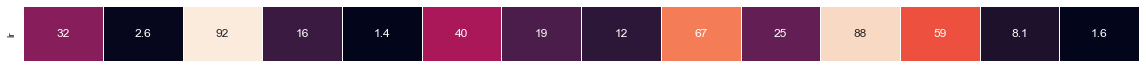

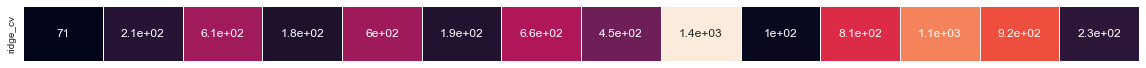

In [52]:
fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False);

In [53]:
r2_results2 = pd.DataFrame({'ridge_cv':ridge_cv.best_score_},index=['CV R2'])

r2_results2.loc['Train R2', :] =[r2_score(y_train,ridge_cv.predict(X_train))]
r2_results2.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results2

ridge_cv
CV R2     0.665613
Train R2  0.708001
lambda    0.067000

Vemos que aunque hagamos aplicado la regresión regularizada de Ridge no parece mejorar los resultados de la regresión lineal. Veamos si usando la regresión de LASSO funciona mejor.

##### LASSO REGRESSION

Ahora mediante el método CV de scikit-learn para calcular la mejor $\lambda$ directamente.

In [54]:
lasso_cv =LassoCV(alphas=lambdas,cv=10).fit(X_train,y_train)
lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.1 R2 score: 0.6684543074640008


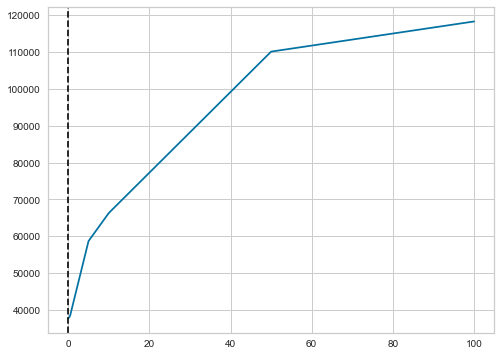

In [55]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

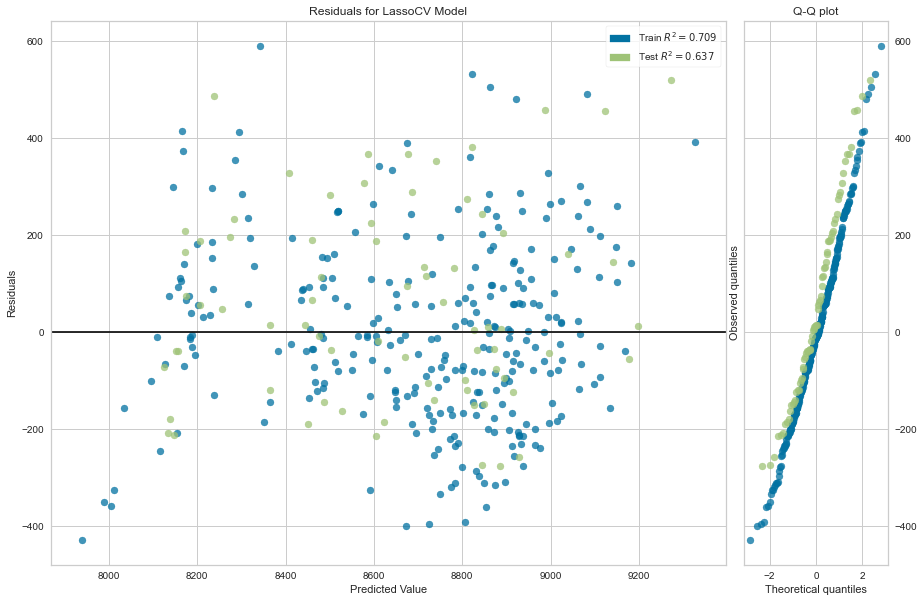

In [56]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(15,10));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

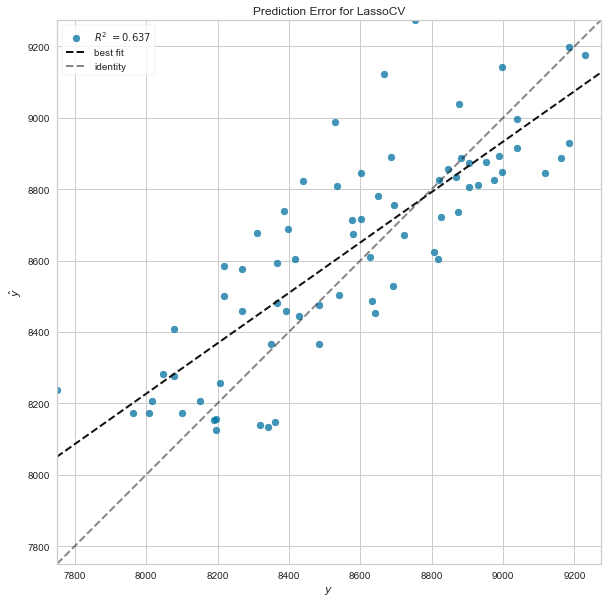

In [57]:
#calculamos el error de predicción del modelo
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(15,10))
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True)

In [58]:
weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_, 'lasso_cv':lasso_cv.coef_},index=X_train.columns)
weights.T

compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges  \
lr                                                32.229213                           
ridge_cv                                          71.252536                           
lasso_cv                                          60.526091                           

          dades_meteorologiques_precipitacio__barcelona__zona_universitaria  \
lr                                                 2.565828                   
ridge_cv                                         206.089790                   
lasso_cv                                         196.357654                   

          dades_meteorologiques_temperatura__barcelona__zona_universitaria  \
lr                                                91.883379                  
ridge_cv                                         609.462238                  
lasso_cv                                         608.689338                  

          dades_meteorologiques_vent__barcelona__zona_universitaria  \
lr                                               -15.503191           
ridge_cv                                        -175.384095           
lasso_cv                                        -174.101703           

          estat_del_transit_segons_trams_horaris__mati_6_13_  \
lr                                                 1.366346    
ridge_cv                                        -604.096612    
lasso_cv                                        -633.189954    

          estat_del_transit_segons_trams_horaris__nit_0_5_  \
lr                                              -39.502408   
ridge_cv                                       -191.054571   
lasso_cv                                       -183.086058   

          estat_del_transit_segons_trams_horaris__tarda_14_19_  \
lr                                                19.272115      
ridge_cv                                         657.005522      
lasso_cv                                         688.206925      

          estat_del_transit_segons_trams_horaris__vespre_20_24_  \
lr                                                12.277267       
ridge_cv                                        -451.227519       
lasso_cv                                        -459.244934       

          ipc_interanual__barcelona  \
lr                        67.305776   
ridge_cv                1420.607916   
lasso_cv                1450.674081   

          operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america  \
lr                                                24.531779                                           
ridge_cv                                        -101.425713                                           
lasso_cv                                         -75.260643                                           

          operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya  \
lr                                                87.602147                                           
ridge_cv                                         814.885154                                           
lasso_cv                                         852.107540                                           

          operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa  \
lr                                                58.918115                                          
ridge_cv                                       -1068.116120                                          
lasso_cv                                       -1126.210411                                          

          preu_electricitat_majorista__  \
lr                             8.103275   
ridge_cv                    -924.747132   
lasso_cv                    -963.836060   

          matriculacions_de_vehicles_a_barcelona__turismes  
lr                                                1.604977  
ridge_cv           

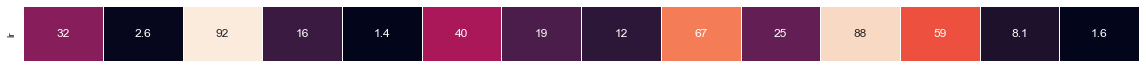

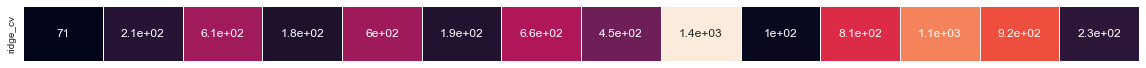

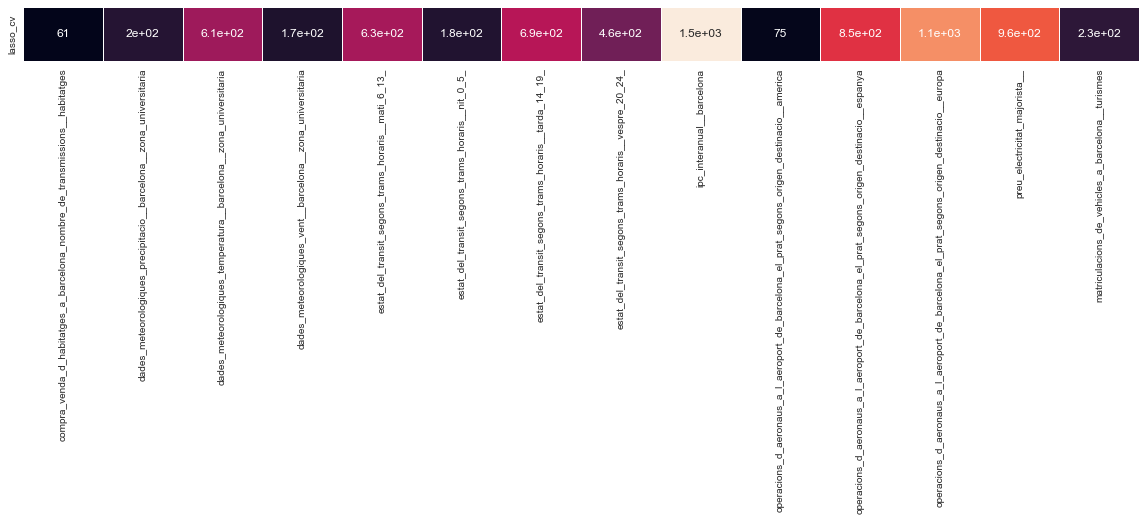

In [59]:
fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

In [60]:
r2_results3 = pd.DataFrame({'lasso_cv':lasso_r2},index=['CV R2'])

r2_results3.loc['Train R2', :] =[r2_score(y_train,lasso_cv.predict(X_train))]
r2_results3.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results3

lasso_cv
CV R2     0.668454
Train R2  0.708548
lambda    0.100000

In [61]:
r2_results3 = pd.DataFrame({'lr':valorLRr2,'ridge_cv':ridge_cv.best_score_,'lasso_cv':lasso_r2},index=['CV R2'])
comparacioResultatsD = r2_results3
r2_results3

lr  ridge_cv  lasso_cv
CV R2  0.664501  0.665613  0.668454

#### Elección del modelo usando el conjunto de test

Ya hemos visto en función del modelo el valor de $R^{2}$ usando el conjunto test. Ahora pues solo nos queda razonar cuál es *mejor*. Según nuestras métricas de validación, el mejor modelo es **lasso_cv** con una lambda de 0.1 utilizada con el conjunto de datos estandarizados. Aún así, vemos que usando el conjunto de test para los modelos, el mejor $R^{2}$ lo obtenemos con el modelo de Ridge ya que Lasso sobrejausta un poco poco más obteninendo una $R^{2}$ ligeramente inferior a Ridge y superior al modelo de regresión lineal.

Aún así, ambos modelos regularizados, tanto Ridge, como LASSO no se comportan de la forma que deseariamos. Si nos fijamos, lasso ajusta peor los datos de entrenamiento que el modelo de regressión lineal, aunque por una diferencia muy pequeña: (LASSO)0.708548 vs (LR)0.708757. 

Así pues, de los tres modelos nos quedamos con el modelo de **ridge_cv**, aunque **lasso_cv** tampoco seria una mala opción, como el mejor modelo para predecir el valor de la cotización del ibex 35.

Notamos que hemos descartamos el modelo de regresión lineal, ya que no obtenemos un buen valor de R^2 para el conjunto de CV.

#### 4 Variables predictoras que más peso tienen en los modelos(LR,Ridge y LASSO) para la variable que queremos predecir

##### Variables a los que el modelo de regressión lineal atribuye más peso(por order creciente):

- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa
- ipc_interanual__barcelona 
- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya
- dades_meteorologiques_temperatura__barcelona__zona_universitaria

##### Variables a los que el modelo de regressión regularizada de Ridge atribuyen más peso(por order creciente):

- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya 
- preu_electricitat_majorista__
- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa
- ipc_interanual__barcelona   

##### Variables a los que el modelo de regressión regularizada de Lasso atribuyen más peso(por order creciente):

- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya 
- preu_electricitat_majorista__
- operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa
- ipc_interanual__barcelona 

Lasso a diferencia de Ridge atribuye más peso a cada una de las variables aunque consideren ambos las mismas.

Las variables con más peso que considera el modelo de regressión lineal considero que son las correctas, ya que se corresponden con las variables que más correlación tienen con la variable objetivo cuando hemos realizado la exploración de los datos y la comparación de variables con el método `feature_correlation` o con los `regplot`. 

A diferencia del modelo de regressión lineal, Ridge y Lasso no consideran que la temperatura sea el factor más importante que contribuye a predecir correctamente el valor de la cotización del mercado español. Esto, es un grave error, ya que para Ridge, le atribuye el sexto peso más grande y Lasso el séptimo. Ambos consideran que el **ipc_interanual__barcelona** es la variable mas decisiva juntamente con la variable **preu_electricitat_majorista__**. En cambio la LR, no considera esta última. 

Además tanto Ridge como Lasso dan importancia a la variable **estat_del_transit_segons_trams_horaris__mati_6_13_**, cosa que es sorprendente, ya que el modelo de regresión lineal le ha atribuido el menor peso.

También sucede lo mismo con la variable **estat_del_transit_segons_trams_horaris__tarda_14_19_**. Y por el contrario, cuando Ridge y Lasso no atribuyen importancia a como está el tránsito de madrugada, el model de RL le da un peso bastante notable.

#### Eliminamos las variables que tienen menos peso en los modelos del conjunto de datos y reajustamos el modelo de regresión lineal

##### Variables a los que el modelo de regressión lineal le ha asignado menor peso:

- estat_del_transit_segons_trams_horaris__mati_6_13_
- matriculacions_de_vehicles_a_barcelona__turismes
- dades_meteorologiques_precipitacio__barcelona__zona_universitaria

##### Reajustamos el modelo de regresión lineal

In [62]:
#creamos el nuevo modelo eliminando las variables que menos peso tienen
X = bcn_ibex_data.loc[:,bcn_ibex_data.columns != 'mercat_bursatil_ibex_35_']
X = X.loc[:,X.columns != 'dades_meteorologiques_precipitacio__barcelona__zona_universitaria']
X = X.loc[:,X.columns != 'estat_del_transit_segons_trams_horaris__mati_6_13_']
X = X.loc[:,X.columns != 'matriculacions_de_vehicles_a_barcelona__turismes']
y = bcn_ibex_data['mercat_bursatil_ibex_35_']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
#escalamos para que todas las variables tengan el mismo rango para que aprovechemos mejor nuestros modelos
def scaling_preprocessing(X, y, scaler=None):
    numerical_columns = [c for c in X.columns]
    if scaler is None: 
        # datos de entrenamiento
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        # datos de test
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    return X, y, scaler

X_train, y_train, scaler = scaling_preprocessing(X_train,y_train)
X_test, y_test, _ = scaling_preprocessing(X_test,y_test,scaler)

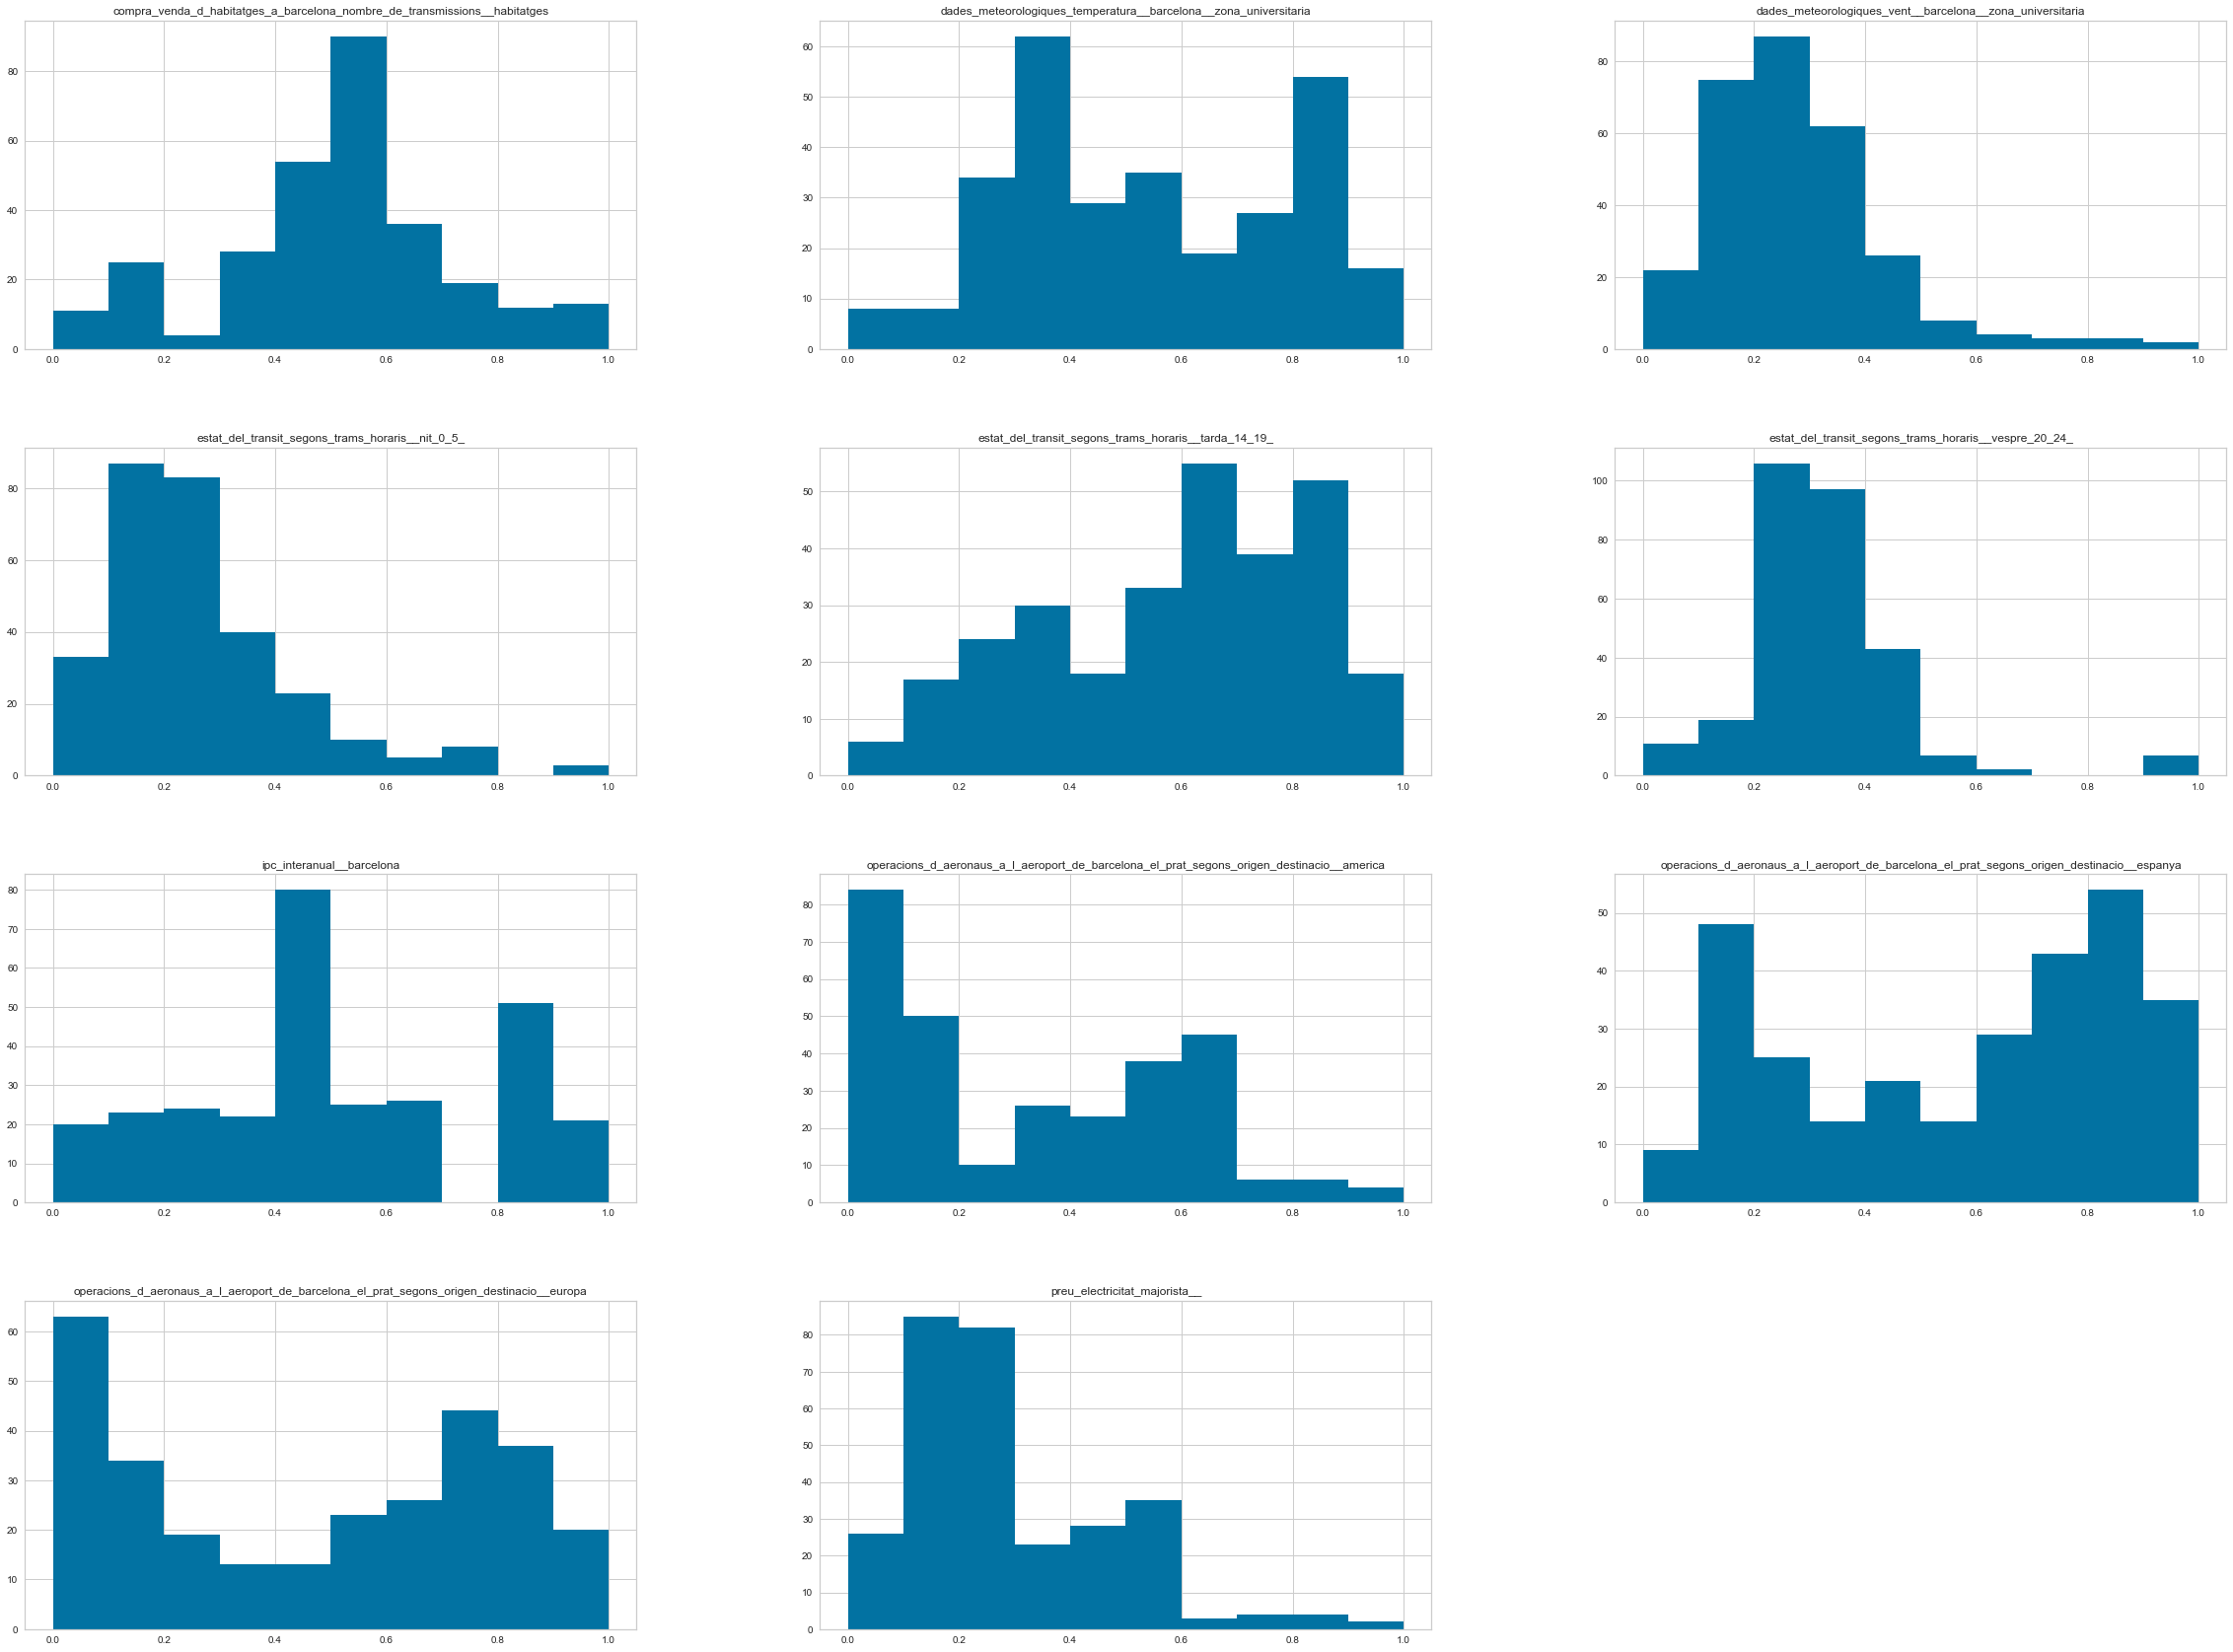

In [64]:
X_train.hist(figsize=(40,30));

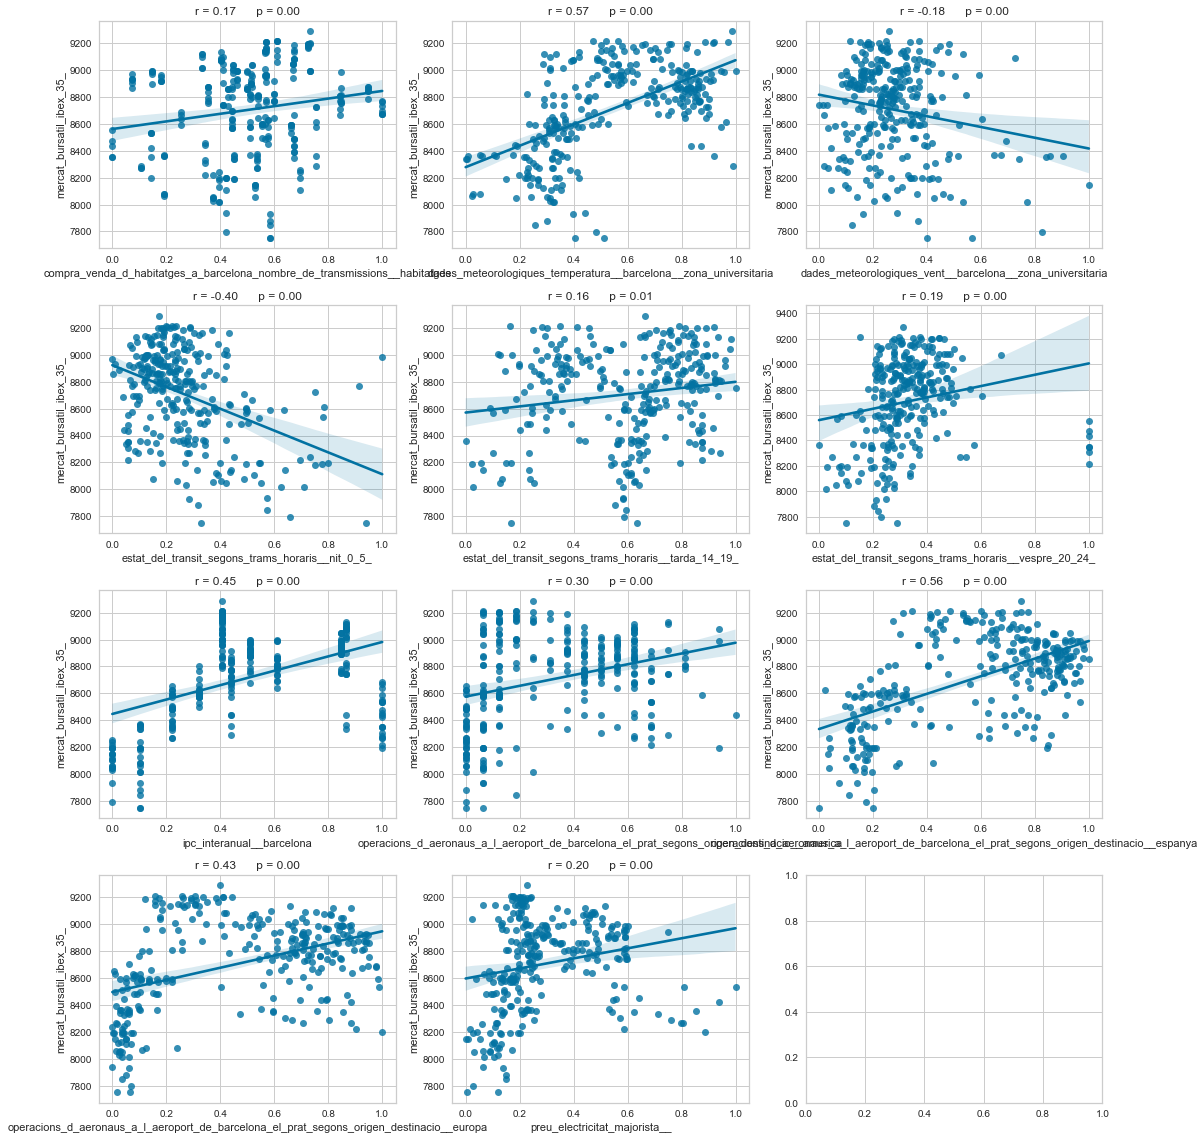

In [65]:
nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

li_num_feats = list(X_train.columns)
li_plot_num_feats = [c for c in list(X_train.columns)]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=X_train[li_plot_num_feats[i]], y=y_train, ax = axs[r][c])
            #primer atribut(r) és la correlació, segon atribut(p) és p-value
            stp = stats.pearsonr(X_train[li_plot_num_feats[i]], y_train)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=12)
            
plt.tight_layout()    
plt.show()

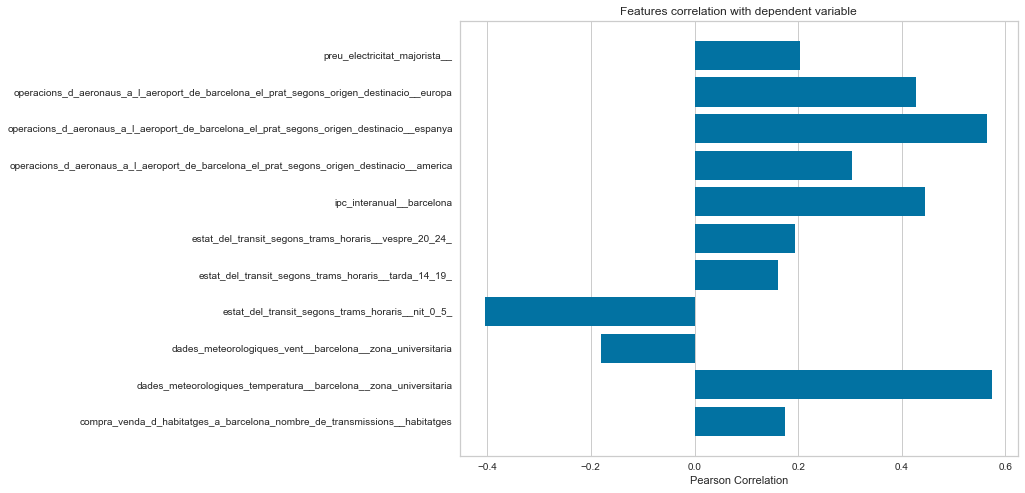

In [66]:
plt.figure(figsize=(10,8))
visualizer = feature_correlation(X_train, y_train, labels=list(X_train.columns),method='pearson');

In [67]:
lr = LinearRegression();
lr.fit(X_train,y_train);
y_pred = lr.predict(X_train);

weights = lr.coef_
intercept = lr.intercept_

print('Pesos: \n', weights[:])
print('Interceptor: \n', intercept)

Pesos: 
 [   16.73115757   576.87226132  -173.75777041  -192.33826866
    24.8522238   -426.07117602  1479.2922833    -94.64403396
   951.07977545 -1108.34422267 -1049.00222213]
Interceptor: 
 8205.417498668858


In [68]:
import statsmodels.api
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     mercat_bursatil_ibex_35_   R-squared:                       0.685
Model:                                  OLS   Adj. R-squared:                  0.672
Method:                       Least Squares   F-statistic:                     55.29
Date:                      Sun, 30 Oct 2022   Prob (F-statistic):           1.13e-63
Time:                              13:04:07   Log-Likelihood:                -1950.0
No. Observations:                       292   AIC:                             3924.
Df Residuals:                           280   BIC:                             3968.
Df Model:                                11                                         
Covariance Type:                  nonrobust                                         
=============================================================================================================================================================
                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                      8205.4175     69.472    118.112      0.000    8068.664    8342.171
compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges                    16.7312     67.159      0.249      0.803    -115.469     148.932
dades_meteorologiques_temperatura__barcelona__zona_universitaria                            576.8723     89.258      6.463      0.000     401.170     752.574
dades_meteorologiques_vent__barcelona__zona_universitaria                                  -173.7578     79.736     -2.179      0.030    -330.716     -16.800
estat_del_transit_segons_trams_horaris__nit_0_5_                                           -192.3383     86.407     -2.226      0.027    -362.428     -22.248
estat_del_transit_segons_trams_horaris__tarda_14_19_                                         24.8522     73.928      0.336      0.737    -120.673     170.377
estat_del_transit_segons_trams_horaris__vespre_20_24_                                      -426.0712    117.020     -3.641      0.000    -656.422    -195.720
ipc_interanual__barcelona                                                                  1479.2923    111.072     13.318      0.000    1260.650    1697.934
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america   -94.6440    119.636     -0.791      0.430    -330.144     140.856
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya   951.0798    156.598      6.073      0.000     642.822    1259.338
operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa  -1108.3442    171.624     -6.458      0.000   -1446.181    -770.507
preu_electricitat_majorista__                                                             -1049.0022    156.214     -6.715      0.000   -1356.504    -741.500
==============================================================================
Omnibus:                       13.239   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.767
Skew:                          -0.493   Prob(JB):                      0.00102
Kurtosis:                       3.398   Cond. No.                         36.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

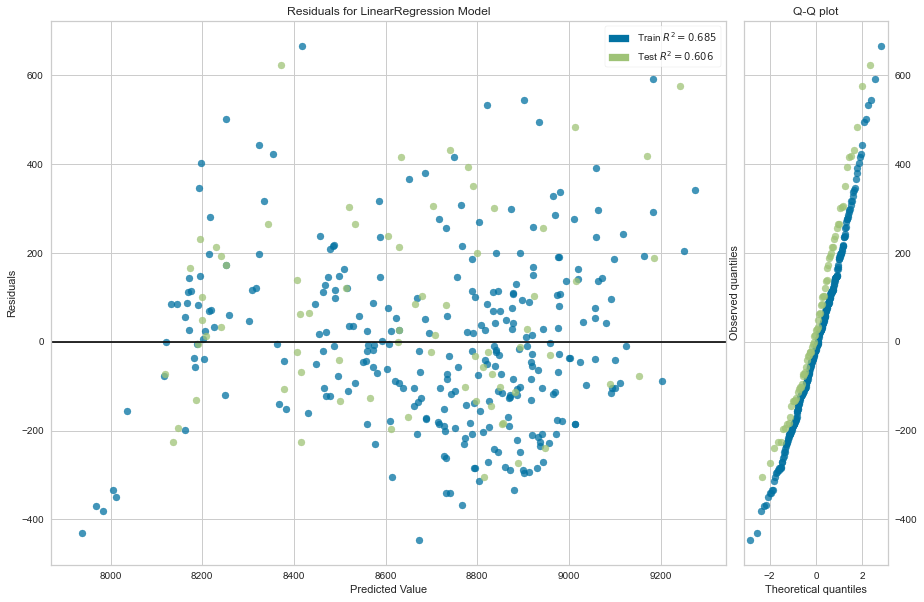

In [69]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(15,10));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

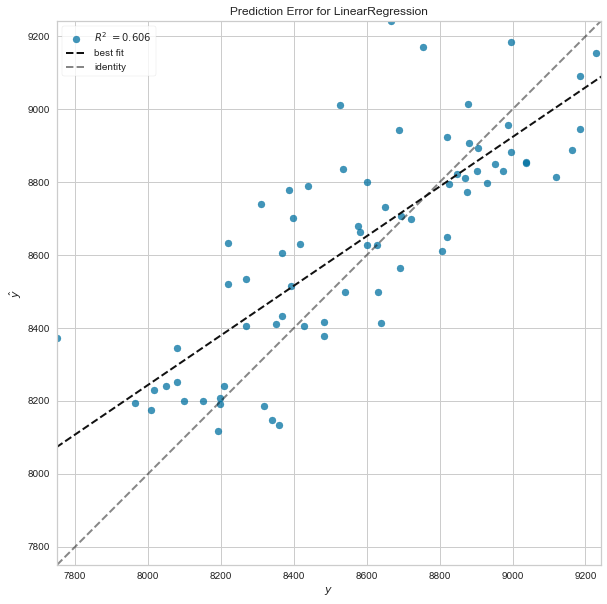

In [70]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(15,10))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True)

In [71]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

#considerar canviar la varible del kf per 5, val no és viable
kf = KFold(n_splits=10)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,11) if j != i]));
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression().fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')

    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse,fold_nmse, fold_r2]
    i+=1

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5, 6, 7, 8, 9, 10]
	MSE: 39423.613 NMSE: 0.375 R2: 0.625
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5, 6, 7, 8, 9, 10]
	MSE: 38783.460 NMSE: 0.346 R2: 0.654
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5, 6, 7, 8, 9, 10]
	MSE: 41357.037 NMSE: 0.428 R2: 0.572
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5, 6, 7, 8, 9, 10]
	MSE: 34760.526 NMSE: 0.409 R2: 0.591
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4, 6, 7, 8, 9, 10]
	MSE: 35994.665 NMSE: 0.320 R2: 0.680
Split 6: 
	Test Folds: [6] 
	Train Folds [1, 2, 3, 4, 5, 7, 8, 9, 10]
	MSE: 52925.938 NMSE: 0.374 R2: 0.626
Split 7: 
	Test Folds: [7] 
	Train Folds [1, 2, 3, 4, 5, 6, 8, 9, 10]
	MSE: 49651.442 NMSE: 0.322 R2: 0.678
Split 8: 
	Test Folds: [8] 
	Train Folds [1, 2, 3, 4, 5, 6, 7, 9, 10]
	MSE: 36042.411 NMSE: 0.342 R2: 0.658
Split 9: 
	Test Folds: [9] 
	Train Folds [1, 2, 3, 4, 5, 6, 7, 8, 10]
	MSE: 32815.961 NMSE: 0.265 R2: 0.735
Split 10: 
	Test Folds: [10]

In [72]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

lr = LinearRegression().fit(X_train,y_train);
folds_r2 = cross_val_score(lr, X_train,y_train, cv=10, scoring='r2')
lr_r2 = np.mean(folds_r2) 
folds_r2, lr_r2

r2_results = pd.DataFrame({'lr':lr_r2},index=['CV R2'])
valorLRr2 = lr_r2
r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results

lr
CV R2     0.647138
Train R2  0.684759
lambda    0.000000

##### Vemos como ha cambiado el peso de las variables que quedan:

Index(['compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges',
       'dades_meteorologiques_temperatura__barcelona__zona_universitaria',
       'dades_meteorologiques_vent__barcelona__zona_universitaria',
       'estat_del_transit_segons_trams_horaris__nit_0_5_',
       'estat_del_transit_segons_trams_horaris__tarda_14_19_',
       'estat_del_transit_segons_trams_horaris__vespre_20_24_',
       'ipc_interanual__barcelona',
       'operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__america',
       'operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__espanya',
       'operacions_d_aeronaus_a_l_aeroport_de_barcelona_el_prat_segons_origen_destinacio__europa',
       'preu_electricitat_majorista__'],
      dtype='object')


<Figure size 1440x72 with 0 Axes>

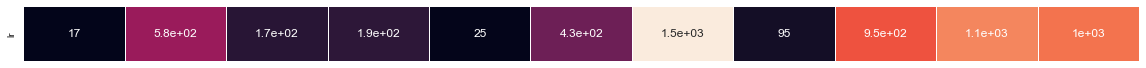

In [73]:
plt.figure(figsize = (20,1));
weights = pd.DataFrame({'lr':lr.coef_},index=X_train.columns)

print(X_train.columns)

fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

Al quitar las variables de menos peso del modelo de RL, ahora el modelo ha repartido los pesos y ha atribuido un mayor peso a otras variables y uno menor a otras. 

En concreto si nos fijamos hay variables que ya tenien un peso grande pero que ahora tienen un peso mucho mas importante. Aún así, si nos fijamos, ahora este modelo nos predice peor la cotización, ya que obtenemos una $R^{2}$ más baja tanto para el conjnto de entrenamiento, como para el conjunto de CV. 

Ahora pero, el modelo aribuye un peso destacable a **preu_electricitat_majorista__**, variable a la que tanto Ridge y Lasso atribuian un peso importante, pero ha atribuido un peso peor a **compra_venda_d_habitatges_a_barcelona_nombre_de_transmissions__habitatges**.

Podemos ver que las variables que menos peso tienen siguen, las podemos seguir viendo en el statsmodel de GLM, fijandonos si en la columna de P>|t|, tenemos un valor superior de 0.05.

#### d) Al ser un problema complejo, igual hay interacciones entre variables que explican mejor la variable objetivo. Usa la función $\texttt{PolynomialFeatures}$ de scikit-learn para añadir al conjunto de datos original características que correspondan a polinomios de grado 2. Vuelve a ajustar la regresión Ridge y la regresión LASSO. ¿Han mejorado los modelos? Fíjate en las variables a las que LASSO no les ha dado un peso 0. ¿Se corresponden con interacciones entre variables?

#### Añadimos las polynomial features al conjunto de datos original

In [74]:
from sklearn.preprocessing import PolynomialFeatures

trans = PolynomialFeatures(degree=2)

X = bcn_ibex_data.loc[:,bcn_ibex_data.columns != 'mercat_bursatil_ibex_35_']
y = bcn_ibex_data['mercat_bursatil_ibex_35_']

data = X[:].values
data = trans.fit_transform(data)
#ara tenim moltes més features de 14 a 120
dataset = pd.DataFrame(data)

data_X_train, data_X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)

#### Escalamos el nuevo conjunto de datos obtenido

In [75]:
def scaling_preprocessing(X, y, scaler=None):
    # Escalamos las variables numericas
    if scaler is None: 
        # datos de entrenamiento
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    else: 
        # datos de test
        X = scaler.transform(X)
    return X, y, scaler

X_train, y_train, scaler = scaling_preprocessing(data_X_train,y_train)
X_test, y_test, _ = scaling_preprocessing(data_X_test,y_test,scaler)

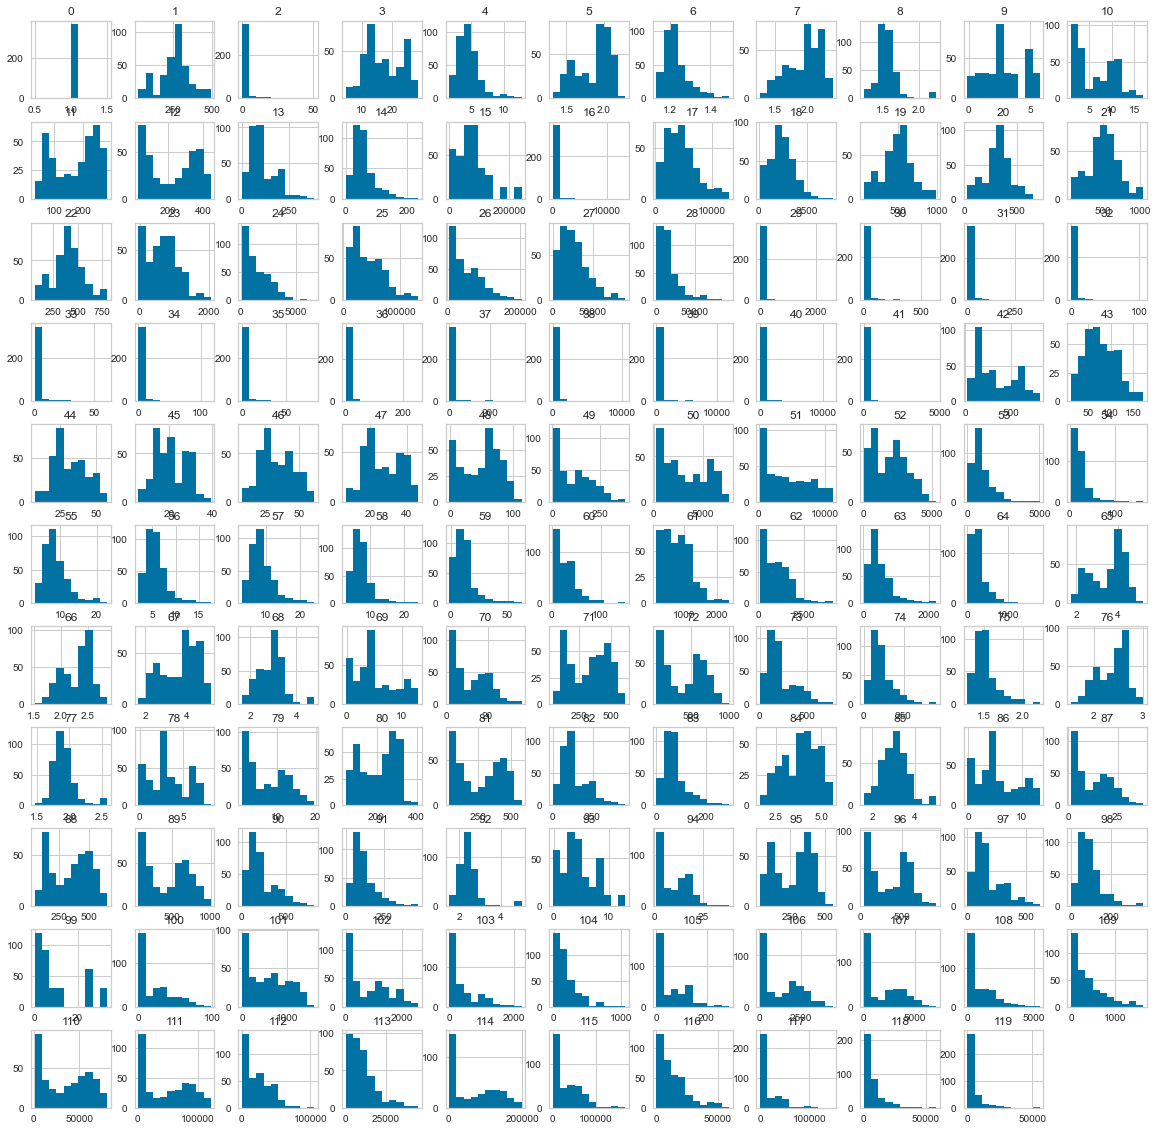

In [76]:
dataset.hist(figsize = (20,20));

#### RIDGE REGRESSION

In [77]:
ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
lambdas = [1e-4,1e-3,1e-2,0.04,0.05,0.06,0.065,0.066,0.067,0.068,0.07,0.073,0.074,0.075,0.0753,0.076,0.077,0.08,0.085,0.09,0.1,0.15,0.2,0.3,0.5,1,5,10,50,100]
# Calculamos las metricas de validación cruzada para cada lambda
for lambda_val in lambdas:
    kf = KFold(n_splits=10) #mejor resultado con 5 que para 10 de 0.665 a 0.0669
    i=1
    cv_mse = []
    cv_nmse = []
    cv_r2 = []
    for train_index, test_index in kf.split(X_train):
        x_train_fold = X_train[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train[test_index,:]
        y_test_fold = y_train.values[test_index]

        lr = Ridge(alpha=lambda_val).fit(x_train_fold,y_train_fold)
        y_pred_fold = lr.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        cv_mse.append(fold_mse)
        cv_nmse.append(fold_nmse)
        cv_r2.append(fold_r2)
    ridge_cross_val_metrics.loc[f'Lambda={lambda_val}',:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]
    
ridge_cross_val_metrics.sort_values(by='mean R2',ascending=False)

mean MSE mean norm_MSE   mean R2
Lambda=0.0753  24660.913824      0.216555  0.783445
Lambda=0.075   24660.889986      0.216555  0.783445
Lambda=0.076   24661.035933      0.216555  0.783445
Lambda=0.074   24660.937122      0.216556  0.783444
Lambda=0.077   24661.367912      0.216557  0.783443
Lambda=0.073   24661.184742      0.216559  0.783441
Lambda=0.08    24663.414463      0.216574  0.783426
Lambda=0.07    24663.210373      0.216579  0.783421
Lambda=0.068   24665.717154      0.216603  0.783397
Lambda=0.067   24667.346178      0.216619  0.783381
Lambda=0.085   24669.976897      0.216629  0.783371
Lambda=0.066   24669.239632      0.216636  0.783364
Lambda=0.065   24671.408759      0.216657  0.783343
Lambda=0.09    24679.937545      0.216715  0.783285
Lambda=0.06    24686.830863      0.216799  0.783201
Lambda=0.1      24708.09377       0.21696   0.78304
Lambda=0.05    24747.142416      0.217351  0.782649
Lambda=0.04    24868.349175      0.218455  0.781545
Lambda=0.15    24942.924293      0.219023  0.780977
Lambda=0.2     25245.443321      0.221679  0.778321
Lambda=0.3     25897.291002      0.227382  0.772618
Lambda=0.01    26908.341303      0.237111  0.762889
Lambda=0.5     27153.351974      0.238319  0.761681
Lambda=1       29680.258392      0.260247  0.739753
Lambda=0.001   37989.670839      0.336306  0.663694
Lambda=5       38619.983197      0.338069  0.661931
Lambda=10      44179.088813      0.386943  0.613057
Lambda=0.0001  63297.391607      0.543928  0.456072
Lambda=50      61928.497237      0.544357  0.455643
Lambda=100      69944.21531      0.615583  0.384417

Best lambda: 0.0753 R2 score: 0.783


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1911: RuntimeWarning:

invalid value encountered in reciprocal



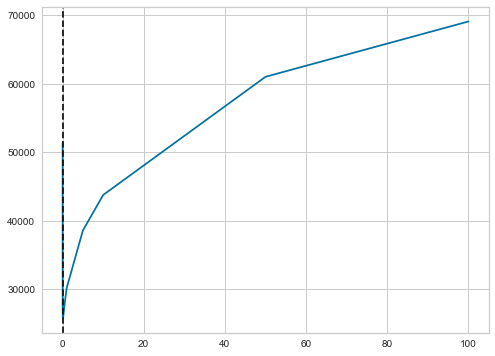

In [78]:
ridge_cv = RidgeCV(alphas=lambdas,cv=10).fit(X_train,y_train)
print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

plt.figure(figsize=(8,6))
vis = AlphaSelection(RidgeCV(alphas=lambdas));
vis.fit(X_train, y_train);

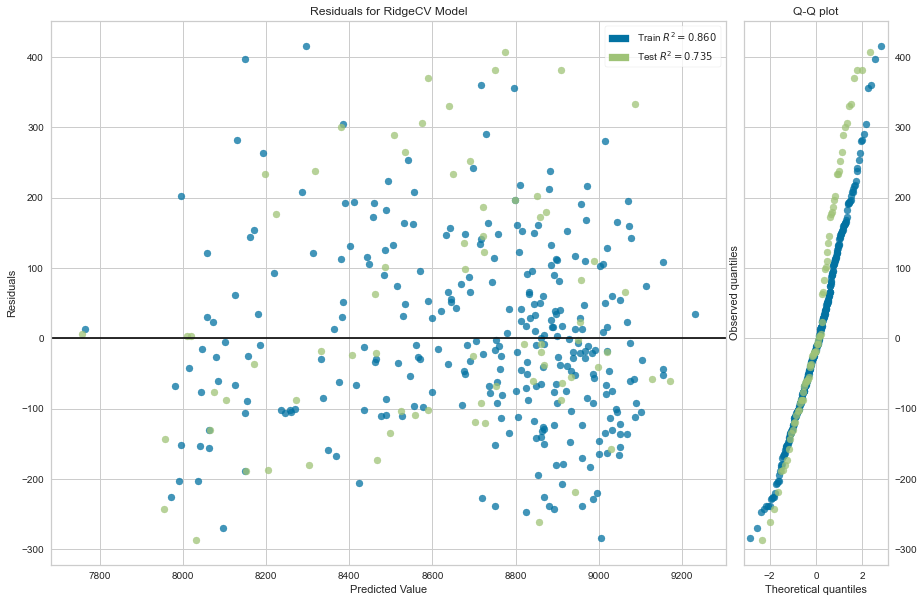

In [79]:
#comparamos los modelos para comprobar el que ajusta mejor y elabora mejores prodecciones sobre el conjunto de test
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(15,10));
viz = residuals_plot(ridge_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

#### Calculamos el error de predicción del modelo

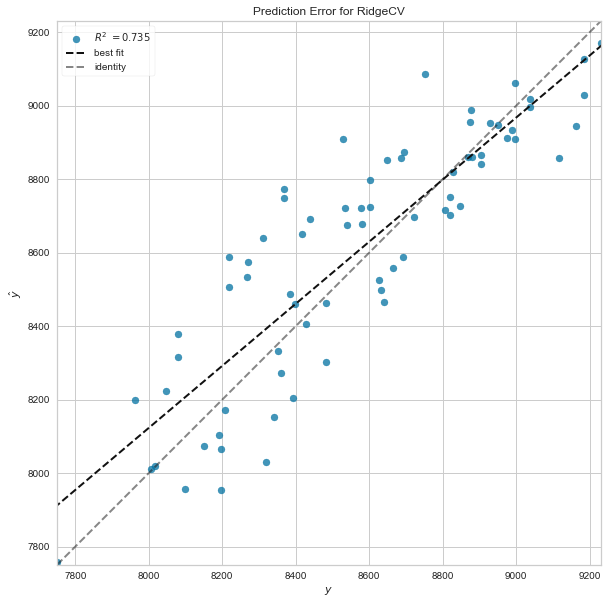

In [80]:
from yellowbrick.regressor import prediction_error
plt.figure(figsize=(15,10))
visualizer = prediction_error(ridge_cv, X_test, y_test, is_fitted=True)

In [81]:
plt.figure(figsize = (20,5));

weights = pd.DataFrame({'ridge_cv':ridge_cv.coef_},index=dataset.columns)
weights.T

0          1          2          3           4          5    \
ridge_cv  0.0  54.015918  82.120325  485.05325  303.862097  41.458488   

                 6           7           8           9    ...         110  \
ridge_cv -166.249413  141.277469  209.840476  390.376463  ... -456.201873   

                 111         112         113       114         115        116  \
ridge_cv -387.180576  102.139532  293.062151  382.0455  389.329462 -311.62268   

                 117         118         119  
ridge_cv -139.741044  209.126692 -347.409626  

[1 rows x 120 columns]

<Figure size 1440x360 with 0 Axes>

#### Pesos que hemos obtenido con el nuevo modelo de regresión regularizada

In [82]:
y_test_predicted = ridge_cv.predict(X_test)
r2_ridge = ridge_cv.score(X_test,y_test)

print('MSE: {}'.format(mean_squared_error(y_test,y_test_predicted)))
print('R2: {}'.format(r2_ridge))

MSE: 31400.325277109023
R2: 0.734753047031182


#### LASSO REGRESSION

In [83]:
lasso_cv =LassoCV(alphas=lambdas,cv=10).fit(X_train,y_train)
lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)
#Best lambda: 0.2 R2 score: 0.7586493833879594

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7250.929306217469, tolerance: 3106.52832529771

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21870.705670414492, tolerance: 3106.52832529771

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 80196.95874230191, tolerance: 3106.52832529771

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. 

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 38991.653786133975, tolerance: 3146.076309239544

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23446.330161283724, tolerance: 3146.076309239544

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 50653.43051645346, tolerance: 3146.076309239544

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 93421.45669941884, tolerance: 3090.37874844867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 54075.9747441113, tolerance: 3090.37874844867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 16936.686246483587, tolerance: 3090.37874844867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. D

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8251.391344911419, tolerance: 2978.7239946007608

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8065.824486427009, tolerance: 2978.7239946007608

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8625.713138680905, tolerance: 2978.7239946007608

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13510.277109032497, tolerance: 3050.5816328669207

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14973.323289483786, tolerance: 3050.5816328669207

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 17066.30883716792, tolerance: 3050.5816328669207

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8656.82279487094, tolerance: 2584.77084

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 26711.924306261353, tolerance: 2584.77084

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 118633.69652079977, tolerance: 2584.77084

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 22596

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 106503.6286450373, tolerance: 2516.691601818182

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 817949.6238090567, tolerance: 2516.691601818182

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 888547.8916367239, tolerance: 2516.691601818182

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23124.312831442803, tolerance: 2363.9454219238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12446.230206183158, tolerance: 2363.9454219238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 15693.22602333501, tolerance: 2363.9454219238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13046.759899646044, tolerance: 2456.5069063809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20785.279272571206, tolerance: 2456.5069063809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8265.629669178277, tolerance: 2456.5069063809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23248.806402828544, tolerance: 2439.5405304952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20570.04692035541, tolerance: 2439.5405304952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 18594.711615348235, tolerance: 2439.5405304952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 65470.56439652853, tolerance: 2679.007501559809

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 69967.81828814652, tolerance: 2679.007501559809

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 59262.10425366508, tolerance: 2679.007501559809

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 991567.2571333849, tolerance: 2548.6245343444975

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 956209.653162524, tolerance: 2548.6245343444975

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 15064.313540347852, tolerance: 2554.4124978755985

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7601.7940896283835, tolerance: 2588.721707828572

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7925.984777613543, tolerance: 2588.721707828572

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8009.601604716387, tolerance: 2588.721707828572

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4375.820125048049, tolerance: 2473.7628859809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3546.0777860265225, tolerance: 2473.7628859809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10120.703420410864, tolerance: 2473.7628859809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 15376.571229435038, tolerance: 2570.1779551238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11232.736833704636, tolerance: 2570.1779551238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7807.598734387197, tolerance: 2570.1779551238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8892.27952690795, tolerance: 2681.189784195238

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21403.080762647092, tolerance: 2681.189784195238

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 40881.17554479092, tolerance: 2681.189784195238

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 101783.57268230198, tolerance: 2362.4897141952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 143060.69246237352, tolerance: 2362.4897141952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 106362.0744557092, tolerance: 2362.4897141952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 905987.2643694633, tolerance: 2419.4156847666673

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 978589.15144606, tolerance: 2419.4156847666673

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 931035.6837818687, tolerance: 2419.4156847666673

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20104.220480680466, tolerance: 2494.407248691944

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 97184.40483890707, tolerance: 2494.407248691944

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 171116.82485879795, tolerance: 2494.407248691944

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10943.817804242484, tolerance: 2422.6580778862567

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8799.071086476091, tolerance: 2422.6580778862567

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 22394.080814893357, tolerance: 2422.6580778862567

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2373.8946240739897, tolerance: 2356.3237645213276

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5783.7281450890005, tolerance: 2356.3237645213276

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6369.335773268715, tolerance: 2356.3237645213276

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 31034.001115507912, tolerance: 2482.8786336952385

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 56867.472578111105, tolerance: 2482.8786336952385

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 67195.23299691267, tolerance: 2482.8786336952385

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 76536.85241481196, tolerance: 2413.448361566667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 50954.07389712613, tolerance: 2413.448361566667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 93462.03491606982, tolerance: 2413.448361566667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1017968.3025693346, tolerance: 2386.0969821142867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1082146.7455410324, tolerance: 2386.0969821142867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1038268.5433193102, tolerance: 2386.0969821142867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iter

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 256149.79947273084, tolerance: 2379.931902947868

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 922362.5101613891, tolerance: 2379.931902947868

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 933658.2165321367, tolerance: 2379.931902947868

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 33577.123715964146, tolerance: 2360.4607676208534

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 138316.92963368678, tolerance: 2360.4607676208534

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 178191.08595058462, tolerance: 2360.4607676208534

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iter

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 36146.15743692126, tolerance: 2486.1254757819916

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34647.75907530589, tolerance: 2486.1254757819916

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 39281.64588220604, tolerance: 2486.1254757819916

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 74797.52961215097, tolerance: 2413.486076957143

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 35479.232020995114, tolerance: 2413.486076957143

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30681.604174151085, tolerance: 2413.486076957143

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 64564.58630961366, tolerance: 2442.7360696952387

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 38987.75110839587, tolerance: 2442.7360696952387

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 25769.21595247276, tolerance: 2442.7360696952387

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 22938.1272447668, tolerance: 2434.7147920379152

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 35954.98264074512, tolerance: 2434.7147920379152

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 72474.25922098011, tolerance: 2434.7147920379152

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 906942.7917082964, tolerance: 2377.132005611375

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 963713.1469538971, tolerance: 2377.132005611375

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 920955.5551845635, tolerance: 2377.132005611375

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6218.680381998885, tolerance: 2376.7556634597163

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6058.642925107852, tolerance: 2376.7556634597163

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20489.64497511182, tolerance: 2376.7556634597163

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

Best lambda: 0.2 R2 score: 0.7586493833879594


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 43218.56107453816, tolerance: 2500.071045317536

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 149061.674643707, tolerance: 2500.071045317536

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 273853.6580607868, tolerance: 2500.071045317536

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7875.555716223083, tolerance: 2760.0299017768243

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23873.95470505953, tolerance: 2760.0299017768243

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4737.323671470396, tolerance: 2760.0299017768243

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3506.6095047029667, tolerance: 2866.0792017510735

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3995.590222689323, tolerance: 2866.0792017510735

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9696.882341932505, tolerance: 2866.0792017510735

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 978936.1756872542, tolerance: 2676.7739002905987

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074050.52217938, tolerance: 2676.7739002905987

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1034228.730483006, tolerance: 2676.7739002905987

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14640.048192183487, tolerance: 2724.3905178461537

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 22746.78936434444, tolerance: 2724.3905178461537

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21843.116322647315, tolerance: 2724.3905178461537

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

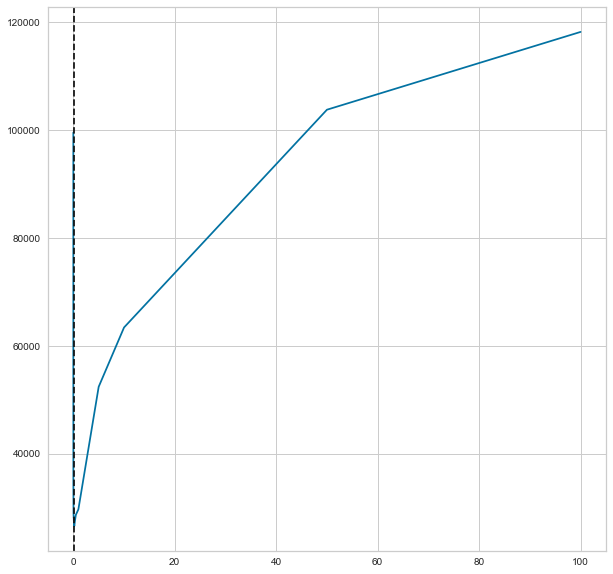

In [84]:
plt.figure(figsize=(10,10))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

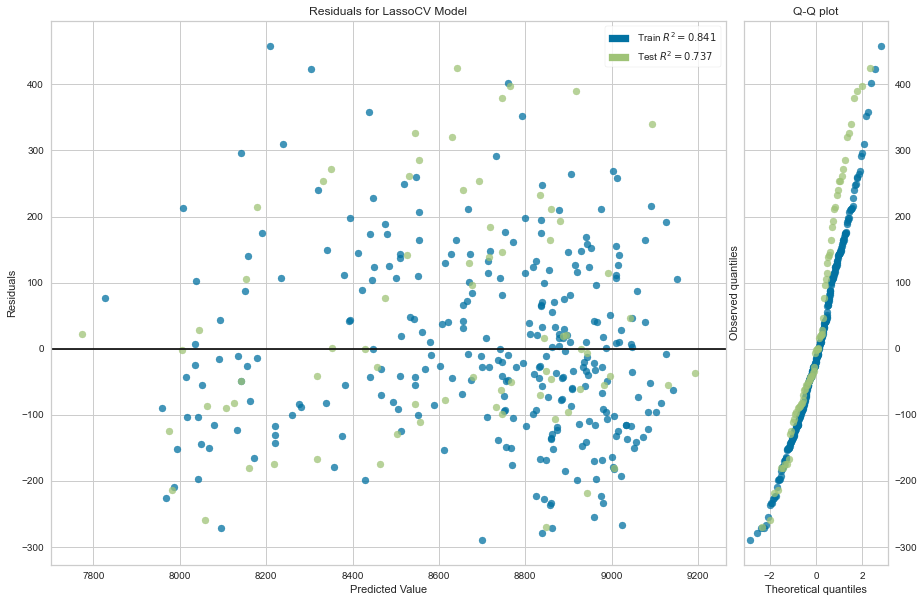

In [85]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(15,10));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

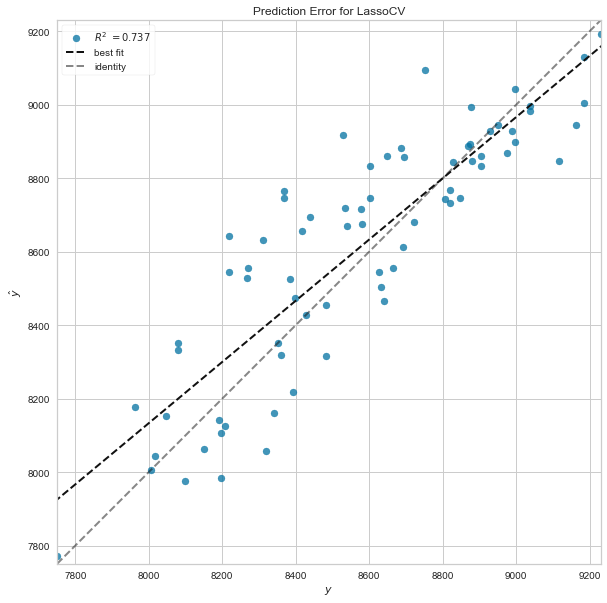

In [86]:
#calculamos el error de predicción del modelo
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(15,10))
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True)

In [87]:
weights = pd.DataFrame({'lasso_cv':lasso_cv.coef_},index=dataset.columns)
weights.T

0    1    2    3    4    5    6         7    8            9    ...  \
lasso_cv  0.0  0.0  0.0  0.0  0.0 -0.0 -0.0  7.227684 -0.0  1230.339629  ...   

                 110  111  112  113         114  115  116  117  118  \
lasso_cv -637.083823 -0.0 -0.0  0.0  247.775791  0.0 -0.0 -0.0  0.0   

                 119  
lasso_cv -249.068449  

[1 rows x 120 columns]

lasso_cv
CV R2     0.758649
Train R2  0.840716
lambda    0.200000

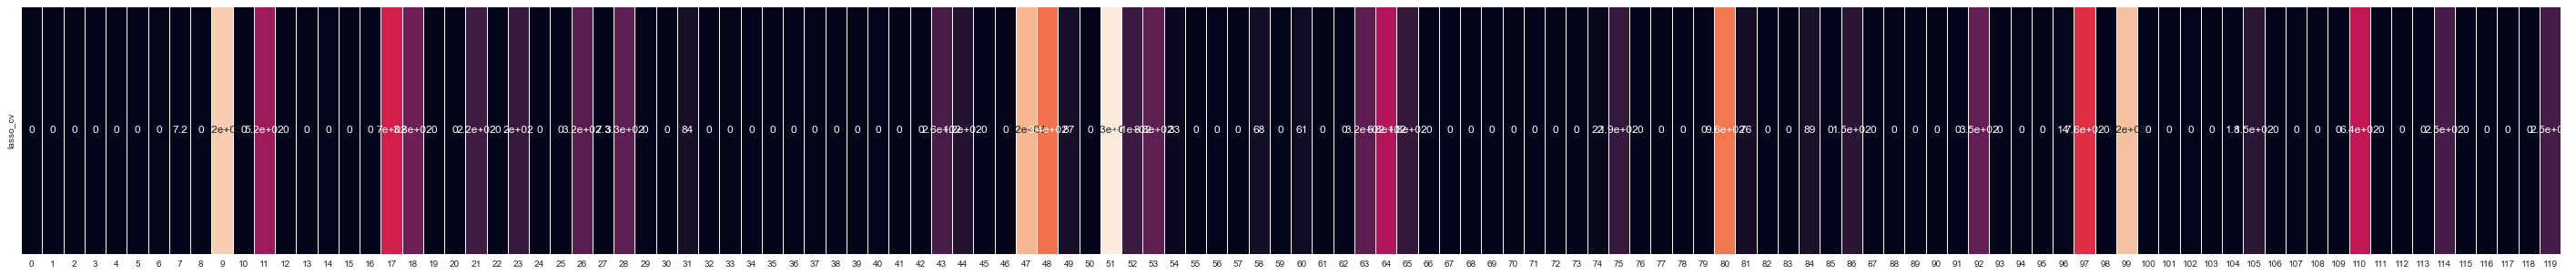

In [88]:
plt.figure(figsize = (50,5));
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

r2_results3 = pd.DataFrame({'lasso_cv':lasso_r2},index=['CV R2'])

r2_results3.loc['Train R2', :] =[r2_score(y_train,lasso_cv.predict(X_train))]
r2_results3.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results3

In [89]:
y_test_predicted = lasso_cv.predict(X_test)
r2_lasso = lasso_cv.score(X_test,y_test)

print('MSE: {}'.format(mean_squared_error(y_test,y_test_predicted)))
print('R2: {}'.format(r2_lasso))

MSE: 31187.23100069244
R2: 0.7365531114259225


In [90]:
r2_results3 = pd.DataFrame({'ridge_cv':ridge_cv.best_score_,'lasso_cv':lasso_r2},index=['CV R2'])
r2_results3

#lasso : Train R2 -> 0.840716, test R2 -> 0.7365531114259225
#ridge: Train R2 -> 0.859681, test R2 -> 0.734753047031182

ridge_cv  lasso_cv
CV R2  0.783445  0.758649

### COMPARANDO RESULTADOS

##### Resultados obtenidos para el modelo RL, Ridge y el modelo Lasso en el apartado c)

In [91]:
comparacioResultatsD

lr  ridge_cv  lasso_cv
CV R2  0.664501  0.665613  0.668454

##### Resultados obtenidos para el modelo Ridge y el modelo Lasso en el apartado usando Polynomial Features

In [92]:
r2_results3 = pd.DataFrame({'ridge_cv':ridge_cv.best_score_,'lasso_cv':lasso_r2},index=['CV R2'])
r2_results3

ridge_cv  lasso_cv
CV R2  0.783445  0.758649

Como podemos observar ambos modelos han mejorado **significativamente**, sobretodo el modelo de regresión regularizada de Ridge. En un primer instante podriamos pensar que al introduir más features hubiera podido dar como resultado un sobreajuste muy grande de los datos y, por tanto, peores resultados con los nuevos modelos. Pero vemos que no ha sido así, ya que gracias al enfoque que usa Ridge mediante el hiperparámetro ha hecho que no se produzca un notable sobreajuste de estos. Así pues nuestro modelo de Ridge es muy eficiente aprovechando las features adicionales que le proporcionamos y controla de forma eficiente el sobreajuste. 

De forma contraria, Lasso si que se puede apreciar que lasso sobrejusta un poco más los datos de test con respecto a los datos de entrenamiento y validación cruzada. 

Una posible prueba podria ser ver como se comportan los modelos añadiendo al conjunto de datos original características que correspondan a polinomios de grado mayor a 2. Ya que una posible hipótesis seria plantear si al añadir más features, conduce a modelos demasiado complejos que sobreajustan los datos, tanto para Ridge y de forma más notable Lasso. 


##### ¿Las variables a las que LASSO no les ha dado un peso 0, se corresponden con interacciones entre variables?
Sí, en total, dadas las 120 features, 40 de las 120 son no nulas(`print(np.sum(weights != 0)`), entonces lo que entiendo que hace Lasso es lograr la misma regularización que hace Ridge disminuyendo por completo la importancia otorgada a algunas características (haciendo que el peso sea cero ya que considera que son las variables menos influyentes), mientras que la regresión de Ridge logra la regularización al reducir la importancia otorgada a algunas de las características y no al anular la importancia de las características.

Lo que sucede es que al tener tantas nuevas features que estan algunas muy correlacionadas, Lasso elige solo alguna de ellas y reduce los pesos de las demás a cero. Además, Lasso no necesita verificar la correlación para todo par de variables, ya que Lasso elimina cualquier variable que no es útil para minimizar la pérdida de predicción y además al tener tantas features totalmente colineales, hará que más de una variable en algun grupo de variables(como se ve en el heatmap de abajo) sean más o menos redundantes en la predicción.

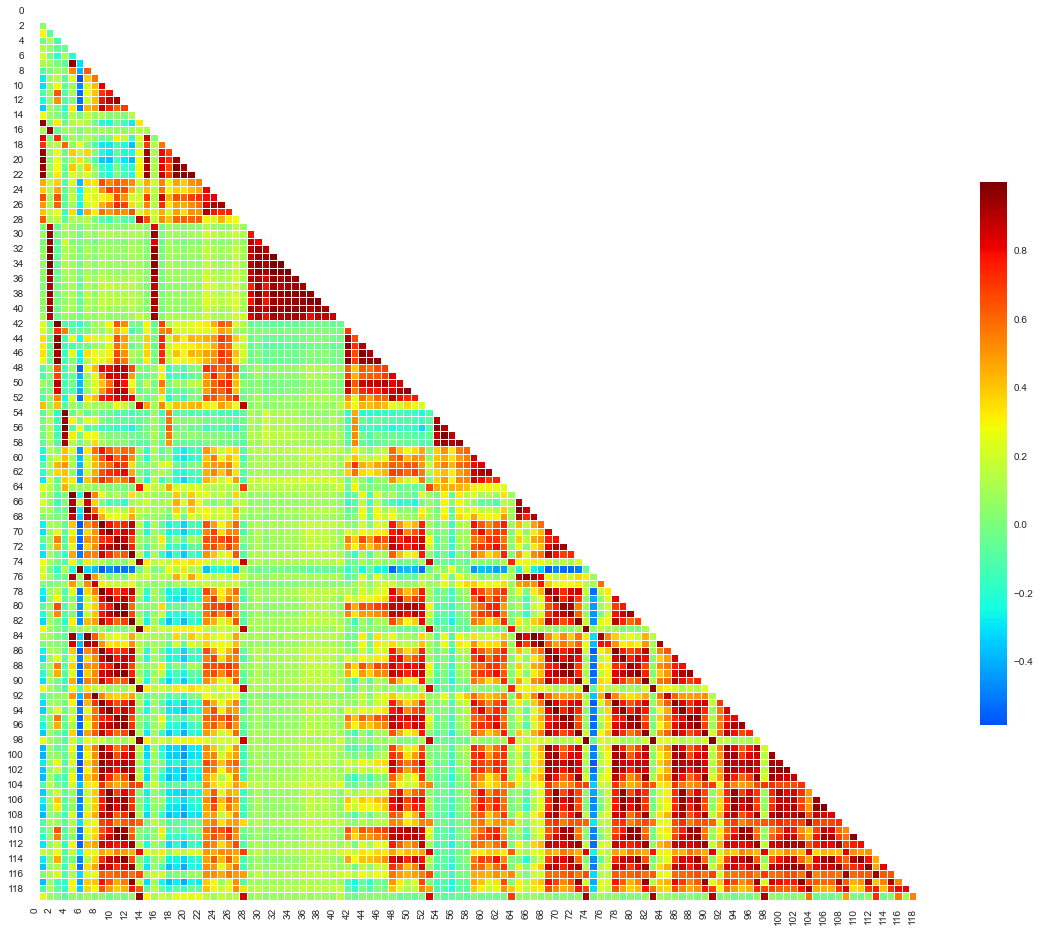

In [93]:
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap='jet',  center=0, square=True, linewidths=.8, cbar_kws={"shrink": .5});

--------
### CURIOSIDADES

Podemos intentar afirmar o desmentir la hipótesis planteada en las conclusiones del apartado anterior.

**Añadiendo al conjunto de datos original características que corresponden a polinomios de grado mayor a 2 tenemos no tendremos un sobreajuste de los datos por parte del modelo de regularización de Ridge pero si por parte del modelo de Lasso**

Grau: 2, Features: 120


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7254.18582473509, tolerance: 3106.52832529771

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21870.382708130404, tolerance: 3106.52832529771

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 80196.8114238549, tolerance: 3106.52832529771

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Du

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 33470.646677498706, tolerance: 3077.9431278015268

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 137558.7934052376, tolerance: 3077.9431278015268

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 327784.30113775283, tolerance: 3077.9431278015268

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 28378.011778539047, tolerance: 3148.626666874525

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 22931.20194981573, tolerance: 3148.626666874525

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 24218.698303952813, tolerance: 3148.626666874525

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1226274.2424898085, tolerance: 3090.37874844867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1371885.0068025468, tolerance: 3090.37874844867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1326783.2718192404, tolerance: 3090.37874844867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4617.421930353623, tolerance: 2978.7239946007608

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4089.019720693119, tolerance: 2978.7239946007608

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 17171.361052902415, tolerance: 2978.7239946007608

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14492.17453855928, tolerance: 3050.5816328669207

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5146.261372436304, tolerance: 3050.5816328669207

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3827.5152683230117, tolerance: 3050.5816328669207

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6553.590040391311, tolerance: 2584.77084

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 18634.501806940883, tolerance: 2584.77084

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5339.66623327136, tolerance: 2584.77084

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 32427.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 29338.378735534847, tolerance: 2469.496581244019

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 112432.79610614246, tolerance: 2469.496581244019

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 223189.97473528842, tolerance: 2469.496581244019

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 221636.436833926, tolerance: 2482.798773066667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 887961.7902755288, tolerance: 2482.798773066667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1006406.9425238302, tolerance: 2482.798773066667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3952.6895482833497, tolerance: 2363.9454219238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2962.3229167032987, tolerance: 2363.9454219238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2417.22436695965, tolerance: 2363.9454219238096

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 923565.4366565921, tolerance: 2505.613759828572

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13042.488093100488, tolerance: 2456.5069063809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20783.859635921195, tolerance: 2456.5069063809524

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14241.555415681563, tolerance: 2439.5405304952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21129.376409106422, tolerance: 2439.5405304952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23248.80655410327, tolerance: 2439.5405304952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14256.345758593641, tolerance: 2679.007501559809

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 26059.360513996333, tolerance: 2679.007501559809

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 24945.53660115134, tolerance: 2679.007501559809

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11166.582108038478, tolerance: 2548.6245343444975

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 28185.673126885667, tolerance: 2548.6245343444975

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 77871.21585643571, tolerance: 2548.6245343444975

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8476.002798825502, tolerance: 2588.721707828572

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5930.316118261777, tolerance: 2588.721707828572

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4232.62451786641, tolerance: 2588.721707828572

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 954831.7341973169, tolerance: 2535.664828266667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 977603.4800276114, tolerance: 2535.664828266667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 927358.6166849361, tolerance: 2535.664828266667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 35718.60121187661, tolerance: 2609.147533066667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 44758.95110483654, tolerance: 2609.147533066667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 50195.03475321457, tolerance: 2609.147533066667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 41422.74762114044, tolerance: 2545.0169947809527

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 35671.060111076105, tolerance: 2545.0169947809527

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 28020.10960821435, tolerance: 2545.0169947809527

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 959526.072901964, tolerance: 2681.189784195238

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053258.9573839833, tolerance: 2681.189784195238

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1021323.9284308485, tolerance: 2681.189784195238

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13929.090725113638, tolerance: 2362.4897141952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 44786.77463666117, tolerance: 2362.4897141952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 124416.32524025813, tolerance: 2362.4897141952383

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4329.942811700981, tolerance: 2389.9133321142863

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6017.476678344421, tolerance: 2389.9133321142863

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11793.198282096535, tolerance: 2389.9133321142863

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 89746.43568254448, tolerance: 2280.1582345876786

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 50460.63521413598, tolerance: 2280.1582345876786

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 40925.4433169812, tolerance: 2280.1582345876786

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 39686.54332639091, tolerance: 2372.228370521328

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11453.185879298486, tolerance: 2372.228370521328

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 27103.909330833703, tolerance: 2372.228370521328

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteratio

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5351.122023408301, tolerance: 2356.3237645213276

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 17183.76959801605, tolerance: 2356.3237645213276

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 94967.36179737234, tolerance: 2356.3237645213276

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 67195.0191838746, tolerance: 2482.8786336952385

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 72288.82241459936, tolerance: 2482.8786336952385

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 56483.131507182494, tolerance: 2482.8786336952385

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1004009.5605411525, tolerance: 2357.8062725952386

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 951132.5639576397, tolerance: 2357.8062725952386

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20024.49489225354, tolerance: 2413.448361566667

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 29708.721032548696, tolerance: 2386.0969821142867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 28198.425589498598, tolerance: 2386.0969821142867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 24286.96383762732, tolerance: 2386.0969821142867

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 45668.87095330376, tolerance: 2379.931902947868

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 37698.77924342174, tolerance: 2379.931902947868

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 24418.058332612738, tolerance: 2379.931902947868

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1007870.7154243665, tolerance: 2322.5959129383896

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1054469.7323248785, tolerance: 2322.5959129383896

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 999981.5659803705, tolerance: 2322.5959129383896

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4876.06985444203, tolerance: 2349.922430625593

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20920.89994168654, tolerance: 2349.922430625593

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 31944.78318798635, tolerance: 2349.922430625593

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 80250.39855546504, tolerance: 2536.1836112571427

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 104301.75590631738, tolerance: 2536.1836112571427

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 145213.34013621137, tolerance: 2536.1836112571427

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7513.198278040625, tolerance: 2413.486076957143

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 24683.04367317166, tolerance: 2413.486076957143

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 70292.47460243385, tolerance: 2413.486076957143

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 22985.190128651913, tolerance: 2442.7360696952387

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20482.17717439402, tolerance: 2442.7360696952387

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4645.968838193454, tolerance: 2442.7360696952387

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 198819.90739275934, tolerance: 2434.7147920379152

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 129266.34293128457, tolerance: 2434.7147920379152

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 47514.8321426576, tolerance: 2434.7147920379152

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterat

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 223742.9649499245, tolerance: 2377.132005611375

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 906942.7916886397, tolerance: 2377.132005611375

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 963713.1469489317, tolerance: 2377.132005611375

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 960938.0253110302, tolerance: 2376.7556634597163

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 929620.8229397534, tolerance: 2376.7556634597163

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12911.371691118926, tolerance: 2500.071045317536

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

Grau: 3, Features: 680


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.422e+03, tolerance: 3.107e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e+04, tolerance: 3.107e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.732e+04, tolerance: 3.107e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.856e+04, tolerance: 3.078e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+04, tolerance: 3.078e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.985e+04, tolerance: 3.078e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.477e+04, tolerance: 3.146e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e+05, tolerance: 3.146e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e+05, tolerance: 3.146e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.127e+05, tolerance: 3.149e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e+05, tolerance: 3.149e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+05, tolerance: 3.149e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e+05, tolerance: 3.090e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e+05, tolerance: 3.090e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.537e+05, tolerance: 3.090e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.775e+04, tolerance: 3.012e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.622e+04, tolerance: 3.012e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.966e+04, tolerance: 3.012e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.080e+04, tolerance: 2.979e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.561e+04, tolerance: 2.979e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.678e+04, tolerance: 2.979e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e+04, tolerance: 3.119e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.987e+04, tolerance: 3.119e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.779e+04, tolerance: 3.119e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.465e+04, tolerance: 3.051e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.292e+04, tolerance: 3.051e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.955e+04, tolerance: 3.051e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e+04, tolerance: 3.103e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+04, tolerance: 3.103e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e+04, tolerance: 3.103e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.958e+04, tolerance: 2.585e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+04, tolerance: 2.585e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+04, tolerance: 2.585e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e+04, tolerance: 2.469e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e+04, tolerance: 2.469e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.857e+04, tolerance: 2.469e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.474e+04, tolerance: 2.517e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.183e+04, tolerance: 2.517e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.113e+04, tolerance: 2.517e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.534e+04, tolerance: 2.431e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.378e+04, tolerance: 2.431e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+05, tolerance: 2.431e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e+05, tolerance: 2.364e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e+05, tolerance: 2.364e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.002e+05, tolerance: 2.364e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.399e+05, tolerance: 2.506e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.622e+05, tolerance: 2.506e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e+04, tolerance: 2.457e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e+05, tolerance: 2.457e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.510e+03, tolerance: 2.440e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e+04, tolerance: 2.440e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e+03, tolerance: 2.576e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e+04, tolerance: 2.576e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.457e+04, tolerance: 2.576e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.510e+03, tolerance: 2.679e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+04, tolerance: 2.679e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.792e+04, tolerance: 2.679e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.172e+04, tolerance: 2.549e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+04, tolerance: 2.549e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.688e+04, tolerance: 2.549e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e+04, tolerance: 2.554e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+04, tolerance: 2.554e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+05, tolerance: 2.554e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.146e+04, tolerance: 2.589e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.038e+05, tolerance: 2.589e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+05, tolerance: 2.589e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.040e+05, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e+05, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e+05, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.603e+04, tolerance: 2.474e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.285e+04, tolerance: 2.474e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.544e+04, tolerance: 2.474e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.061e+04, tolerance: 2.609e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.583e+04, tolerance: 2.609e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.271e+04, tolerance: 2.609e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.284e+04, tolerance: 2.570e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.496e+04, tolerance: 2.570e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.840e+04, tolerance: 2.570e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.068e+04, tolerance: 2.545e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.501e+04, tolerance: 2.545e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.247e+04, tolerance: 2.545e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.647e+04, tolerance: 2.681e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.159e+04, tolerance: 2.681e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e+04, tolerance: 2.681e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.450e+04, tolerance: 2.490e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+04, tolerance: 2.490e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.917e+04, tolerance: 2.490e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.540e+04, tolerance: 2.362e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e+04, tolerance: 2.362e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e+04, tolerance: 2.362e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.446e+04, tolerance: 2.419e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.500e+04, tolerance: 2.419e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.478e+04, tolerance: 2.419e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.668e+04, tolerance: 2.390e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.720e+04, tolerance: 2.390e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.269e+04, tolerance: 2.390e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.017e+04, tolerance: 2.494e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.461e+04, tolerance: 2.494e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.096e+04, tolerance: 2.494e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.226e+04, tolerance: 2.280e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+04, tolerance: 2.280e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.969e+04, tolerance: 2.280e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e+04, tolerance: 2.423e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e+04, tolerance: 2.423e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e+04, tolerance: 2.423e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.915e+04, tolerance: 2.372e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.876e+04, tolerance: 2.372e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.661e+04, tolerance: 2.372e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e+04, tolerance: 2.356e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+04, tolerance: 2.356e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+04, tolerance: 2.356e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.855e+04, tolerance: 2.493e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.505e+04, tolerance: 2.493e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e+05, tolerance: 2.493e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.564e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e+05, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e+04, tolerance: 2.358e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e+05, tolerance: 2.358e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e+05, tolerance: 2.358e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.654e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.574e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e+05, tolerance: 2.386e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e+05, tolerance: 2.386e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+04, tolerance: 2.485e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.434e+05, tolerance: 2.485e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.584e+04, tolerance: 2.380e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.342e+04, tolerance: 2.380e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e+04, tolerance: 2.323e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.732e+04, tolerance: 2.323e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.799e+04, tolerance: 2.323e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.953e+04, tolerance: 2.360e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.632e+04, tolerance: 2.360e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+05, tolerance: 2.360e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e+04, tolerance: 2.350e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.711e+04, tolerance: 2.350e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.980e+04, tolerance: 2.350e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e+05, tolerance: 2.486e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+05, tolerance: 2.486e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+05, tolerance: 2.486e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+05, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.679e+04, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.698e+04, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.161e+04, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.829e+04, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.273e+04, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e+04, tolerance: 2.468e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+04, tolerance: 2.468e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e+04, tolerance: 2.468e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.982e+04, tolerance: 2.443e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.467e+04, tolerance: 2.443e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.433e+04, tolerance: 2.443e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e+04, tolerance: 2.540e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+04, tolerance: 2.540e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.191e+03, tolerance: 2.540e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e+04, tolerance: 2.435e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e+04, tolerance: 2.435e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+04, tolerance: 2.435e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.805e+04, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.716e+04, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.121e+04, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+04, tolerance: 2.428e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.832e+04, tolerance: 2.428e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.205e+04, tolerance: 2.428e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.916e+04, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+05, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.958e+05, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+05, tolerance: 2.500e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.488e+05, tolerance: 2.500e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+05, tolerance: 2.724e+03



Grau: 4, Features: 3060


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.432e+03, tolerance: 3.107e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.007e+04, tolerance: 3.107e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.203e+04, tolerance: 3.107e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.040e+04, tolerance: 3.078e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e+04, tolerance: 3.078e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.818e+04, tolerance: 3.078e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.219e+04, tolerance: 3.146e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e+04, tolerance: 3.146e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.783e+04, tolerance: 3.146e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.405e+03, tolerance: 3.149e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.918e+04, tolerance: 3.149e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.419e+04, tolerance: 3.149e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+04, tolerance: 3.090e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.851e+04, tolerance: 3.090e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.579e+04, tolerance: 3.090e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.145e+03, tolerance: 3.012e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.861e+04, tolerance: 3.012e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.910e+04, tolerance: 3.012e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.123e+03, tolerance: 2.979e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.877e+03, tolerance: 2.979e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e+04, tolerance: 2.979e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+05, tolerance: 2.979e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.689e+03, tolerance: 3.119e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e+04, tolerance: 3.119e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+05, tolerance: 3.119e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.147e+03, tolerance: 3.051e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e+04, tolerance: 3.051e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e+05, tolerance: 3.051e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.212e+03, tolerance: 3.103e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.472e+04, tolerance: 3.103e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e+05, tolerance: 3.103e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.903e+05, tolerance: 3.427e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e+04, tolerance: 2.585e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e+05, tolerance: 2.585e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.122e+04, tolerance: 2.585e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.172e+03, tolerance: 2.469e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e+05, tolerance: 2.469e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.067e+04, tolerance: 2.469e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.402e+03, tolerance: 2.517e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e+05, tolerance: 2.517e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.677e+04, tolerance: 2.517e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e+05, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.383e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+04, tolerance: 2.431e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.236e+04, tolerance: 2.431e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+03, tolerance: 2.364e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+04, tolerance: 2.364e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.913e+04, tolerance: 2.364e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.090e+03, tolerance: 2.506e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+04, tolerance: 2.506e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.700e+04, tolerance: 2.506e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.664e+03, tolerance: 2.457e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.581e+04, tolerance: 2.457e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.506e+04, tolerance: 2.457e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e+04, tolerance: 2.440e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+04, tolerance: 2.440e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.024e+04, tolerance: 2.440e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.053e+03, tolerance: 2.576e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e+04, tolerance: 2.576e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.291e+04, tolerance: 2.576e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.194e+05, tolerance: 2.760e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.914e+03, tolerance: 2.679e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e+05, tolerance: 2.679e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+05, tolerance: 2.679e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.533e+03, tolerance: 2.549e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+05, tolerance: 2.549e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.046e+04, tolerance: 2.549e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+04, tolerance: 2.554e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e+05, tolerance: 2.554e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+05, tolerance: 2.554e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+04, tolerance: 2.589e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e+05, tolerance: 2.589e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.524e+04, tolerance: 2.589e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.181e+03, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e+05, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.294e+04, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.348e+03, tolerance: 2.474e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e+05, tolerance: 2.474e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.436e+04, tolerance: 2.474e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e+04, tolerance: 2.609e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+05, tolerance: 2.609e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.598e+04, tolerance: 2.609e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+04, tolerance: 2.570e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+05, tolerance: 2.570e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.422e+04, tolerance: 2.570e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.870e+03, tolerance: 2.545e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+05, tolerance: 2.545e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+05, tolerance: 2.545e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.627e+03, tolerance: 2.681e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e+05, tolerance: 2.681e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.567e+04, tolerance: 2.681e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.601e+04, tolerance: 2.866e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e+05, tolerance: 2.490e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e+05, tolerance: 2.490e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+05, tolerance: 2.490e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+05, tolerance: 2.362e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e+05, tolerance: 2.362e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.707e+04, tolerance: 2.362e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+05, tolerance: 2.419e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+05, tolerance: 2.419e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+05, tolerance: 2.419e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.640e+05, tolerance: 2.390e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e+05, tolerance: 2.390e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.462e+04, tolerance: 2.390e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.456e+04, tolerance: 2.494e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.059e+05, tolerance: 2.494e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+05, tolerance: 2.494e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.702e+04, tolerance: 2.280e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.848e+04, tolerance: 2.280e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e+05, tolerance: 2.280e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.873e+04, tolerance: 2.423e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.818e+04, tolerance: 2.423e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e+05, tolerance: 2.423e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e+04, tolerance: 2.372e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.731e+04, tolerance: 2.372e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.545e+04, tolerance: 2.372e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.620e+04, tolerance: 2.356e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.566e+04, tolerance: 2.356e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.815e+04, tolerance: 2.356e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e+04, tolerance: 2.493e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.073e+04, tolerance: 2.493e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.875e+04, tolerance: 2.493e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.727e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.606e+04, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+05, tolerance: 2.483e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e+04, tolerance: 2.358e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.989e+04, tolerance: 2.358e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.074e+04, tolerance: 2.358e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.264e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.325e+04, tolerance: 2.386e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e+05, tolerance: 2.386e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+05, tolerance: 2.386e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e+05, tolerance: 2.485e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.024e+05, tolerance: 2.485e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+05, tolerance: 2.485e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+05, tolerance: 2.380e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e+05, tolerance: 2.380e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.566e+04, tolerance: 2.380e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e+05, tolerance: 2.323e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e+05, tolerance: 2.323e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.719e+04, tolerance: 2.323e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e+05, tolerance: 2.360e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e+05, tolerance: 2.360e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.297e+04, tolerance: 2.360e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e+05, tolerance: 2.350e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e+05, tolerance: 2.350e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.553e+04, tolerance: 2.350e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e+05, tolerance: 2.486e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.640e+04, tolerance: 2.486e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e+04, tolerance: 2.670e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.618e+05, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+05, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.782e+04, tolerance: 2.536e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.381e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e+05, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.245e+04, tolerance: 2.413e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.568e+05, tolerance: 2.468e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e+05, tolerance: 2.468e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.877e+04, tolerance: 2.468e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e+05, tolerance: 2.443e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e+05, tolerance: 2.443e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.078e+04, tolerance: 2.443e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+05, tolerance: 2.540e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e+05, tolerance: 2.540e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.029e+04, tolerance: 2.540e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e+05, tolerance: 2.435e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+05, tolerance: 2.435e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.666e+04, tolerance: 2.435e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e+05, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e+05, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.454e+04, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e+05, tolerance: 2.428e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+05, tolerance: 2.428e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.267e+04, tolerance: 2.428e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.455e+05, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e+05, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.269e+04, tolerance: 2.377e+03

/Users/mac/opt/anaconda3/lib/python3.

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.593e+05, tolerance: 2.500e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e+05, tolerance: 2.500e+03

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.648e+04, tolerance: 2.500e+03

/Users/mac/opt/anaconda3/lib/python3.

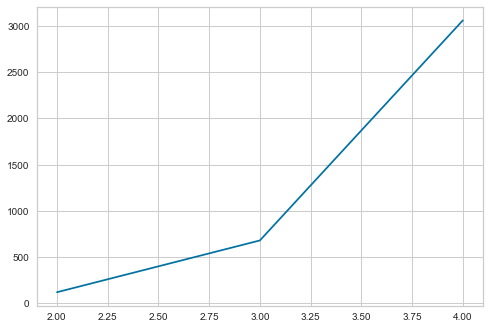

In [94]:
X = bcn_ibex_data.loc[:,bcn_ibex_data.columns != 'mercat_bursatil_ibex_35_']
y = bcn_ibex_data['mercat_bursatil_ibex_35_']

alpha_ridge = []
cv_ridge = []
train_ridge = []

alpha_lasso = []
cv_lasso = []
train_lasso = []

graus = [i for i in range(2, 5)]
num_features = []

for g in graus:
    trans = PolynomialFeatures(degree=g)
    data = X[:].values
    data = trans.fit_transform(X)
    dataset = pd.DataFrame(data)
    num_features.append(data.shape[1])
    print('Grau: %d, Features: %d' % (g, data.shape[1]))
    
    data_X_train, data_X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)
    

    X_train, y_train, scaler = scaling_preprocessing(data_X_train,y_train)
    X_test, y_test, _ = scaling_preprocessing(data_X_test,y_test,scaler)
    
    #ridge
    ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
    lambdas = [1e-4,1e-3,1e-2,0.04,0.05,0.06,0.065,0.066,0.067,0.068,0.07,0.073,0.074,0.075,0.0753,0.076,0.077,0.08,0.085,0.09,0.1,0.15,0.2,0.3,0.5,1,5,8,10,13,15,20,25,30,50,60,70,80,90,100]
    # Calculamos las metricas de validación cruzada para cada lambda
    for lambda_val in lambdas:
        kf = KFold(n_splits=10) #mejor resultado con 5 que para 10 de 0.665 a 0.0669
        i=1
        cv_mse = []
        cv_nmse = []
        cv_r2 = []
        for train_index, test_index in kf.split(X_train):
            x_train_fold = X_train[train_index]
            y_train_fold = y_train.values[train_index]
            x_test_fold = X_train[test_index,:]
            y_test_fold = y_train.values[test_index]

            lr = Ridge(alpha=lambda_val).fit(x_train_fold,y_train_fold)
            y_pred_fold = lr.predict(x_test_fold)
            fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
            fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
            fold_r2 = r2_score(y_test_fold, y_pred_fold)
            cv_mse.append(fold_mse)
            cv_nmse.append(fold_nmse)
            cv_r2.append(fold_r2)
        ridge_cross_val_metrics.loc[f'Lambda={lambda_val}',:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]
    ridge_cross_val_metrics.sort_values(by='mean R2',ascending=False)
    
    ridge_cv = RidgeCV(alphas=lambdas,cv=10).fit(X_train,y_train)
    #print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')
    
    cv_ridge.append(ridge_cv.best_score_)
    train_ridge.append(r2_score(y_train,ridge_cv.predict(X_train)))
    alpha_ridge.append(ridge_cv.alpha_)
    
    #lasso
    lasso_cv = LassoCV(alphas=lambdas,cv=10).fit(X_train,y_train);
    lasso_r2 = np.mean(cross_val_score(lasso_cv, X_train,y_train));

    #print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)
    alpha_lasso.append(lasso_cv.alpha_)
    cv_lasso.append(lasso_r2)
    train_lasso.append(r2_score(y_train,lasso_cv.predict(X_train)))
    
plt.plot(graus, num_features)
plt.show()

In [95]:
cv_ridge, train_ridge, alpha_ridge

([0.7834454854016312, 0.7938614841354242, 0.7911258382619843],
 [0.8596810329927388, 0.8840095789828266, 0.8737871156091137],
 [0.0753, 0.5, 5.0])

In [96]:
cv_lasso, train_lasso, alpha_lasso

([0.7586493833879594, 0.7703607877384225, 0.772433772310776],
 [0.8407161767393553, 0.870262772780505, 0.9289067885312488],
 [0.2, 0.3, 0.1])